In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, SpectralNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.constraints import Constraint
import pickle

In [ ]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [ ]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [ ]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [ ]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if (i+1) % 5 == 0:
            C_A_list.append(C_A - C_As)  # in deviation form
            T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [ ]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [ ]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [ ]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, -T_input, -CA_input, -Q_input, -CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 8)


In [ ]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]


In [ ]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [ ]:
# checking output
print(RNN_output[0, :5])

[[-75.72458929   1.4325163 ]
 [-76.84802004   1.4248451 ]
 [-77.97016868   1.41722366]
 [-79.09094468   1.40964998]
 [-80.21026299   1.40212216]]


In [ ]:
DEFAULT_EPS_SPECTRAL = 1e-3
DEFAULT_MAXITER_SPECTRAL = 10
SWAP_MEMORY = True
STOP_GRAD_SPECTRAL = True

def normalize_kernel(
    kernel,
    u,
    adjustment_coef,
    eps_spectral=DEFAULT_EPS_SPECTRAL,
    maxiter_spectral=DEFAULT_MAXITER_SPECTRAL,
):
    """
    Perform spectral normalization to the kernel given as input. It
    apply the power method to find the largest singular value and apply the spectral
    normalization.

    Args:
        kernel (tf.Tensor): the kernel to orthogonalize
        u (tf.Tensor): the vector used to do the power iteration method
        adjustment_coef (float): the adjustment coefficient as used in convolution
        eps_spectral (float): stopping criterion in spectral algorithm
        maxiter_spectral (int): maximum number of iterations for the power iteration

    Returns:
        tf.Tensor: the normalized kernel, the new u, and sigma which is the largest
            singular value

    """
    W_shape = kernel.shape

    # Flatten the Tensor
    W_reshaped = tf.reshape(kernel, [-1, W_shape[-1]])

    W_bar, u, sigma = spectral_normalization(
        W_reshaped, u, eps=eps_spectral, maxiter=maxiter_spectral
    )

    W_bar = W_bar * adjustment_coef
    W_bar = K.reshape(W_bar, kernel.shape)
    return W_bar, u, sigma

def _power_iteration(
    linear_operator,
    adjoint_operator,
    u,
    eps=DEFAULT_EPS_SPECTRAL,
    maxiter=DEFAULT_MAXITER_SPECTRAL,
    axis=None,
):
    """Internal function that performs the power iteration algorithm to estimate the
    largest singular vector of a linear operator.

    Args:
        linear_operator (Callable): a callable object that maps a linear operation.
        adjoint_operator (Callable): a callable object that maps the adjoint of the
            linear operator.
        u (tf.Tensor): initialization of the singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.
        axis (int/list, optional): dimension along which to normalize. Can be set for
            depthwise convolution for example. Defaults to None.

    Returns:
        tf.Tensor: the maximum singular vector.
    """

    # Prepare while loop variables
    u = tf.math.l2_normalize(u, axis=axis)
    # create a fake old_w that doesn't pass the loop condition, it will be overwritten
    old_u = u + 2 * eps

    # Loop body
    def body(u, old_u):
        old_u = u
        v = linear_operator(u)
        u = adjoint_operator(v)

        u = tf.math.l2_normalize(u, axis=axis)

        return u, old_u

    # Loop stopping condition
    def cond(u, old_u):
        return tf.linalg.norm(u - old_u) >= eps

    # Run the while loop
    u, _ = tf.while_loop(
        cond,
        body,
        (u, old_u),
        maximum_iterations=maxiter,
        swap_memory=SWAP_MEMORY,
    )

    # Prevent gradient to back-propagate into the while loop
    if STOP_GRAD_SPECTRAL:
        u = tf.stop_gradient(u)

    return u

def spectral_normalization(
    kernel, u, eps=DEFAULT_EPS_SPECTRAL, maxiter=DEFAULT_MAXITER_SPECTRAL
):
    """
    Normalize the kernel to have its maximum singular value equal to 1.

    Args:
        kernel (tf.Tensor): the kernel to normalize, assuming a 2D kernel.
        u (tf.Tensor): initialization of the maximum singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.

    Returns:
        the normalized kernel, the maximum singular vector, and the maximum singular
            value.
    """

    if u is None:
        u = tf.random.uniform(
            shape=(1, kernel.shape[-1]), minval=0.0, maxval=1.0, dtype=kernel.dtype
        )

    def linear_op(u):
        return u @ tf.transpose(kernel)

    def adjoint_op(v):
        return v @ kernel

    u = _power_iteration(linear_op, adjoint_op, u, eps, maxiter)

    # Compute the largest singular value and the normalized kernel.
    # We assume that in the worst case we converged to sigma + eps (as u and v are
    # normalized after each iteration)
    # In order to be sure that operator norm of normalized kernel is strictly less than
    # one we use sigma + eps
    sigma = tf.reshape(tf.norm(linear_op(u)), (1, 1))
    normalized_kernel = kernel / (sigma + eps)
    return normalized_kernel, u, sigma

In [ ]:
class SpectralConstraint(Constraint):
    def __init__(
        self,
        k_coef_lip=1.0,
        eps_spectral=DEFAULT_EPS_SPECTRAL,
        u=None,
    ) -> None:
        """
        Ensure that maximum singular values of the weight matrix less than 1.

        Args:
            k_coef_lip (float): lipschitz coefficient of the weight matrix
            eps_spectral (float): stopping criterion for the iterative power algorithm.
            u (tf.Tensor): vector used for iterated power method, can be set to None
                (used for serialization/deserialization purposes).
        """
        self.eps_spectral = eps_spectral
        self.k_coef_lip = k_coef_lip
        if not (isinstance(u, tf.Tensor) or (u is None)):
            u = tf.convert_to_tensor(u)
        self.u = u
        super(SpectralConstraint, self).__init__()

    def __call__(self, w):
        # clip to ensure non-negative weight
        w = K.clip(w, 0, w)

        # perform spectral normalization to the kernel
        wbar, _, _ = normalize_kernel(
            w,
            self.u,
            self.k_coef_lip,
            self.eps_spectral,
        )

        return wbar

    def get_config(self):
        config = {
            "k_coef_lip": self.k_coef_lip,
            "eps_spectral": self.eps_spectral,
            "u": None if self.u is None else self.u.numpy(),
        }
        base_config = super(SpectralConstraint, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def check_non_negative_weights_ignore_bias(model):
    all_non_negative = True
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # tf the layer has weights
            # check only the weight matrices (ignoring biases if present)
            weight_only = weights[0]  # assume weights are the first element, bias (if any) is second
            if not np.all(weight_only >= 0):
                print(f"Non-negative check failed in layer: {layer.name}")
                all_non_negative = False
    if all_non_negative:
        print("All weights are non-negative (ignoring biases).")
    else:
        print("Some weights are negative (ignoring biases).")

In [ ]:
def evaluate_lip_const(model: Model, x, eps, seed=None):
    """
    Evaluate the Lipschitz constant of a model, with the naive method.
    Please note that the estimation of the lipschitz constant is done locally around
    input sample. This may not correctly estimate the behaviour in the whole domain.

    Args:
        model: built keras model used to make predictions
        x: inputs used to compute the lipschitz constant
        eps (float): magnitude of noise to add to input in order to compute the constant
        seed (int): seed used when generating the noise ( can be set to None )

    Returns:
        float: the empirically evaluated lipschitz constant. The computation might also
            be inaccurate in high dimensional space.

    """
    y_pred = model.predict(x)
    x_var = x + K.random_uniform(
        shape=x.shape, minval=eps * 0.25, maxval=eps, seed=seed
    )
#     x_var = x + K.random_normal(
#         shape=x.shape, mean=0, stddev=eps, seed=seed
#     )
    y_pred_var = model.predict(x_var)
    dx = x - x_var
    dfx = y_pred - y_pred_var
    ndx = K.sqrt(K.sum(K.square(dx), axis=range(1, len(x.shape))))
    ndfx = K.sqrt(K.sum(K.square(dfx), axis=range(1, len(y_pred.shape))))
    lip_cst = K.max(ndfx / ndx)
    print(f"lip cst: {lip_cst:.3f}")
    return lip_cst

In [ ]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*19
test_loss = [0]*19
lip = [0]*19
noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for i in range(19):
    num_dims = 8

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

    # define scalers for both X and y base on training data only
    scaler_X = preprocessing.MinMaxScaler().fit(X_train.reshape(-1, num_dims))
    scaler_y = preprocessing.MinMaxScaler().fit(y_train.reshape(-1, 2))

    X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

    # X is just the initial condition, so we introduce noise to the output trajectory y
    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    # ICLRNN
    nh = 64
    constraint = SpectralConstraint()
    input = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = SimpleRNN(nh,
          activation='relu',
          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
          recurrent_initializer=initializers.Orthogonal(0.1),
          return_sequences=True,
          kernel_constraint=constraint,
          recurrent_constraint=constraint
          )(input)
    x = SimpleRNN(nh,
          activation='relu',
          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
          recurrent_initializer=initializers.Orthogonal(0.1),
          return_sequences=True,
          kernel_constraint=constraint,
          recurrent_constraint=constraint
          )(x)
    x = Dense(2,
            activation='relu',
            kernel_constraint=constraint
            )(x)
    model = Model(input, x)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

    training_loss[i] = history.history['val_loss'][-1]
    print(noise)
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    # check convexity by checking the weights
    check_non_negative_weights_ignore_bias(model)

    # compute the Lipschitz constant for the 2-layer RNN
    lipschitz_constant = evaluate_lip_const(model, X_train, 1e-04, 42)
    print(f"Estimated Lipschitz constant of the 2-layer RNN: {lipschitz_constant}")

    lip[i] = lipschitz_constant

model.summary()

Epoch 1/1000
26/26 - 2s - loss: 162.0313 - mean_squared_error: 162.0313 - val_loss: 101.4374 - val_mean_squared_error: 101.4374 - 2s/epoch - 72ms/step
Epoch 2/1000
26/26 - 0s - loss: 66.7289 - mean_squared_error: 66.7289 - val_loss: 38.2278 - val_mean_squared_error: 38.2278 - 254ms/epoch - 10ms/step
Epoch 3/1000
26/26 - 0s - loss: 25.7272 - mean_squared_error: 25.7272 - val_loss: 15.6683 - val_mean_squared_error: 15.6683 - 317ms/epoch - 12ms/step
Epoch 4/1000
26/26 - 0s - loss: 11.1567 - mean_squared_error: 11.1567 - val_loss: 7.2868 - val_mean_squared_error: 7.2868 - 260ms/epoch - 10ms/step
Epoch 5/1000
26/26 - 0s - loss: 5.3618 - mean_squared_error: 5.3618 - val_loss: 3.6627 - val_mean_squared_error: 3.6627 - 309ms/epoch - 12ms/step
Epoch 6/1000
26/26 - 0s - loss: 2.7902 - mean_squared_error: 2.7902 - val_loss: 1.9949 - val_mean_squared_error: 1.9949 - 331ms/epoch - 13ms/step
Epoch 7/1000
26/26 - 0s - loss: 1.5644 - mean_squared_error: 1.5644 - val_loss: 1.1628 - val_mean_squared_err

Epoch 57/1000
26/26 - 0s - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - 201ms/epoch - 8ms/step
Epoch 58/1000
26/26 - 0s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 215ms/epoch - 8ms/step
Epoch 59/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1228 - val_mean_squared_error: 0.1228 - 185ms/epoch - 7ms/step
Epoch 60/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1205 - val_mean_squared_error: 0.1205 - 199ms/epoch - 8ms/step
Epoch 61/1000
26/26 - 0s - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 0.1182 - val_mean_squared_error: 0.1182 - 201ms/epoch - 8ms/step
Epoch 62/1000
26/26 - 0s - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.1159 - val_mean_squared_error: 0.1159 - 200ms/epoch - 8ms/step
Epoch 63/1000
26/26 - 0s - loss: 0.1144 - mean_squared_error: 0.1144 - val_loss: 0.1137 - val_mean_squared_error: 0.1137 - 2

Epoch 113/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - 281ms/epoch - 11ms/step
Epoch 114/1000
26/26 - 0s - loss: 0.0615 - mean_squared_error: 0.0615 - val_loss: 0.0612 - val_mean_squared_error: 0.0612 - 231ms/epoch - 9ms/step
Epoch 115/1000
26/26 - 0s - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - 189ms/epoch - 7ms/step
Epoch 116/1000
26/26 - 0s - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - 223ms/epoch - 9ms/step
Epoch 117/1000
26/26 - 0s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0598 - val_mean_squared_error: 0.0598 - 190ms/epoch - 7ms/step
Epoch 118/1000
26/26 - 0s - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - 218ms/epoch - 8ms/step
Epoch 119/1000
26/26 - 0s - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0590 - val_mean_squared_error: 0.

Epoch 169/1000
26/26 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - 330ms/epoch - 13ms/step
Epoch 170/1000
26/26 - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - 285ms/epoch - 11ms/step
Epoch 171/1000
26/26 - 0s - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - 270ms/epoch - 10ms/step
Epoch 172/1000
26/26 - 0s - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - 274ms/epoch - 11ms/step
Epoch 173/1000
26/26 - 0s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - 248ms/epoch - 10ms/step
Epoch 174/1000
26/26 - 0s - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 260ms/epoch - 10ms/step
Epoch 175/1000
26/26 - 0s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0416 - val_mean_squared_erro

Epoch 225/1000
26/26 - 0s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 297ms/epoch - 11ms/step
Epoch 226/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 328ms/epoch - 13ms/step
Epoch 227/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 295ms/epoch - 11ms/step
Epoch 228/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 214ms/epoch - 8ms/step
Epoch 229/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 362ms/epoch - 14ms/step
Epoch 230/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - 268ms/epoch - 10ms/step
Epoch 231/1000
26/26 - 0s - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0219 - val_mean_squared_error

Epoch 281/1000
26/26 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 357ms/epoch - 14ms/step
Epoch 282/1000
26/26 - 0s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 285ms/epoch - 11ms/step
Epoch 283/1000
26/26 - 0s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - 251ms/epoch - 10ms/step
Epoch 284/1000
26/26 - 0s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - 287ms/epoch - 11ms/step
Epoch 285/1000
26/26 - 0s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - 291ms/epoch - 11ms/step
Epoch 286/1000
26/26 - 0s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - 250ms/epoch - 10ms/step
Epoch 287/1000
26/26 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0077 - val_mean_squared_erro

Epoch 337/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 348ms/epoch - 13ms/step
Epoch 338/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 402ms/epoch - 15ms/step
Epoch 339/1000
26/26 - 0s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - 249ms/epoch - 10ms/step
Epoch 340/1000
26/26 - 0s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - 337ms/epoch - 13ms/step
Epoch 341/1000
26/26 - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - 244ms/epoch - 9ms/step
Epoch 342/1000
26/26 - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - 267ms/epoch - 10ms/step
Epoch 343/1000
26/26 - 0s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0038 - val_mean_squared_error

Epoch 393/1000
26/26 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - 314ms/epoch - 12ms/step
Epoch 394/1000
26/26 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - 317ms/epoch - 12ms/step
Epoch 395/1000
26/26 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - 271ms/epoch - 10ms/step
Epoch 396/1000
26/26 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - 264ms/epoch - 10ms/step
Epoch 397/1000
26/26 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - 358ms/epoch - 14ms/step
Epoch 398/1000
26/26 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - 281ms/epoch - 11ms/step
Epoch 399/1000
26/26 - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_erro

Epoch 449/1000
26/26 - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 332ms/epoch - 13ms/step
Epoch 450/1000
26/26 - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 286ms/epoch - 11ms/step
Epoch 451/1000
26/26 - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 260ms/epoch - 10ms/step
Epoch 452/1000
26/26 - 0s - loss: 9.9745e-04 - mean_squared_error: 9.9745e-04 - val_loss: 9.9741e-04 - val_mean_squared_error: 9.9741e-04 - 264ms/epoch - 10ms/step
Epoch 453/1000
26/26 - 0s - loss: 9.8612e-04 - mean_squared_error: 9.8612e-04 - val_loss: 9.8814e-04 - val_mean_squared_error: 9.8814e-04 - 324ms/epoch - 12ms/step
Epoch 454/1000
26/26 - 0s - loss: 9.7162e-04 - mean_squared_error: 9.7162e-04 - val_loss: 9.7466e-04 - val_mean_squared_error: 9.7466e-04 - 252ms/epoch - 10ms/step
Epoch 455/1000
26/26 - 0s - loss: 9.5963e-04 - mean_squared_erro

Epoch 500/1000
26/26 - 0s - loss: 5.2235e-04 - mean_squared_error: 5.2235e-04 - val_loss: 5.2458e-04 - val_mean_squared_error: 5.2458e-04 - 297ms/epoch - 11ms/step
Epoch 501/1000
26/26 - 0s - loss: 5.1599e-04 - mean_squared_error: 5.1599e-04 - val_loss: 5.1838e-04 - val_mean_squared_error: 5.1838e-04 - 304ms/epoch - 12ms/step
Epoch 502/1000
26/26 - 0s - loss: 5.0852e-04 - mean_squared_error: 5.0852e-04 - val_loss: 5.0994e-04 - val_mean_squared_error: 5.0994e-04 - 268ms/epoch - 10ms/step
Epoch 503/1000
26/26 - 0s - loss: 5.0307e-04 - mean_squared_error: 5.0307e-04 - val_loss: 5.0574e-04 - val_mean_squared_error: 5.0574e-04 - 244ms/epoch - 9ms/step
Epoch 504/1000
26/26 - 0s - loss: 4.9548e-04 - mean_squared_error: 4.9548e-04 - val_loss: 4.9729e-04 - val_mean_squared_error: 4.9729e-04 - 313ms/epoch - 12ms/step
Epoch 505/1000
26/26 - 0s - loss: 4.8933e-04 - mean_squared_error: 4.8933e-04 - val_loss: 4.8602e-04 - val_mean_squared_error: 4.8602e-04 - 372ms/epoch - 14ms/step
Epoch 506/1000
26

Epoch 550/1000
26/26 - 0s - loss: 2.8319e-04 - mean_squared_error: 2.8319e-04 - val_loss: 2.8238e-04 - val_mean_squared_error: 2.8238e-04 - 332ms/epoch - 13ms/step
Epoch 551/1000
26/26 - 0s - loss: 2.7929e-04 - mean_squared_error: 2.7929e-04 - val_loss: 2.8058e-04 - val_mean_squared_error: 2.8058e-04 - 382ms/epoch - 15ms/step
Epoch 552/1000
26/26 - 0s - loss: 2.7603e-04 - mean_squared_error: 2.7603e-04 - val_loss: 2.7841e-04 - val_mean_squared_error: 2.7841e-04 - 330ms/epoch - 13ms/step
Epoch 553/1000
26/26 - 0s - loss: 2.7314e-04 - mean_squared_error: 2.7314e-04 - val_loss: 2.7330e-04 - val_mean_squared_error: 2.7330e-04 - 286ms/epoch - 11ms/step
Epoch 554/1000
26/26 - 0s - loss: 2.7063e-04 - mean_squared_error: 2.7063e-04 - val_loss: 2.7204e-04 - val_mean_squared_error: 2.7204e-04 - 269ms/epoch - 10ms/step
Epoch 555/1000
26/26 - 0s - loss: 2.6680e-04 - mean_squared_error: 2.6680e-04 - val_loss: 2.7927e-04 - val_mean_squared_error: 2.7927e-04 - 284ms/epoch - 11ms/step
Epoch 556/1000
2

26/26 - 0s - loss: 1.8081e-04 - mean_squared_error: 1.8081e-04 - val_loss: 1.8110e-04 - val_mean_squared_error: 1.8110e-04 - 205ms/epoch - 8ms/step
Epoch 601/1000
26/26 - 0s - loss: 1.7967e-04 - mean_squared_error: 1.7967e-04 - val_loss: 1.7990e-04 - val_mean_squared_error: 1.7990e-04 - 249ms/epoch - 10ms/step
Epoch 602/1000
26/26 - 0s - loss: 1.9122e-04 - mean_squared_error: 1.9122e-04 - val_loss: 1.7941e-04 - val_mean_squared_error: 1.7941e-04 - 200ms/epoch - 8ms/step
Epoch 603/1000
26/26 - 0s - loss: 1.7758e-04 - mean_squared_error: 1.7758e-04 - val_loss: 1.9178e-04 - val_mean_squared_error: 1.9178e-04 - 226ms/epoch - 9ms/step
Epoch 604/1000
26/26 - 0s - loss: 1.7897e-04 - mean_squared_error: 1.7897e-04 - val_loss: 2.0368e-04 - val_mean_squared_error: 2.0368e-04 - 268ms/epoch - 10ms/step
Epoch 605/1000
26/26 - 0s - loss: 1.7553e-04 - mean_squared_error: 1.7553e-04 - val_loss: 1.9399e-04 - val_mean_squared_error: 1.9399e-04 - 243ms/epoch - 9ms/step
Epoch 606/1000
26/26 - 0s - loss: 1

Epoch 651/1000
26/26 - 0s - loss: 1.3955e-04 - mean_squared_error: 1.3955e-04 - val_loss: 1.3824e-04 - val_mean_squared_error: 1.3824e-04 - 216ms/epoch - 8ms/step
Epoch 652/1000
26/26 - 0s - loss: 1.3972e-04 - mean_squared_error: 1.3972e-04 - val_loss: 1.4081e-04 - val_mean_squared_error: 1.4081e-04 - 268ms/epoch - 10ms/step
Epoch 653/1000
26/26 - 0s - loss: 1.6204e-04 - mean_squared_error: 1.6204e-04 - val_loss: 1.3985e-04 - val_mean_squared_error: 1.3985e-04 - 223ms/epoch - 9ms/step
Epoch 654/1000
26/26 - 0s - loss: 1.4291e-04 - mean_squared_error: 1.4291e-04 - val_loss: 1.5166e-04 - val_mean_squared_error: 1.5166e-04 - 253ms/epoch - 10ms/step
Epoch 655/1000
26/26 - 0s - loss: 1.7643e-04 - mean_squared_error: 1.7643e-04 - val_loss: 1.6687e-04 - val_mean_squared_error: 1.6687e-04 - 214ms/epoch - 8ms/step
Epoch 656/1000
26/26 - 0s - loss: 1.5105e-04 - mean_squared_error: 1.5105e-04 - val_loss: 2.0637e-04 - val_mean_squared_error: 2.0637e-04 - 236ms/epoch - 9ms/step
Epoch 657/1000
26/26

26/26 - 0s - loss: 1.5403e-04 - mean_squared_error: 1.5403e-04 - val_loss: 1.3465e-04 - val_mean_squared_error: 1.3465e-04 - 258ms/epoch - 10ms/step
Epoch 702/1000
26/26 - 0s - loss: 1.3770e-04 - mean_squared_error: 1.3770e-04 - val_loss: 1.3735e-04 - val_mean_squared_error: 1.3735e-04 - 353ms/epoch - 14ms/step
Epoch 703/1000
26/26 - 0s - loss: 1.6459e-04 - mean_squared_error: 1.6459e-04 - val_loss: 1.2318e-04 - val_mean_squared_error: 1.2318e-04 - 321ms/epoch - 12ms/step
Epoch 704/1000
26/26 - 0s - loss: 1.4035e-04 - mean_squared_error: 1.4035e-04 - val_loss: 2.6599e-04 - val_mean_squared_error: 2.6599e-04 - 315ms/epoch - 12ms/step
Epoch 705/1000
26/26 - 0s - loss: 1.4151e-04 - mean_squared_error: 1.4151e-04 - val_loss: 1.1957e-04 - val_mean_squared_error: 1.1957e-04 - 345ms/epoch - 13ms/step
Epoch 706/1000
26/26 - 0s - loss: 1.2736e-04 - mean_squared_error: 1.2736e-04 - val_loss: 1.6723e-04 - val_mean_squared_error: 1.6723e-04 - 268ms/epoch - 10ms/step
Epoch 707/1000
26/26 - 0s - los

Epoch 752/1000
26/26 - 0s - loss: 1.3952e-04 - mean_squared_error: 1.3952e-04 - val_loss: 1.3190e-04 - val_mean_squared_error: 1.3190e-04 - 232ms/epoch - 9ms/step
Epoch 753/1000
26/26 - 0s - loss: 1.4836e-04 - mean_squared_error: 1.4836e-04 - val_loss: 1.1406e-04 - val_mean_squared_error: 1.1406e-04 - 206ms/epoch - 8ms/step
Epoch 754/1000
26/26 - 0s - loss: 1.2480e-04 - mean_squared_error: 1.2480e-04 - val_loss: 1.2652e-04 - val_mean_squared_error: 1.2652e-04 - 248ms/epoch - 10ms/step
Epoch 755/1000
26/26 - 0s - loss: 1.4552e-04 - mean_squared_error: 1.4552e-04 - val_loss: 1.4353e-04 - val_mean_squared_error: 1.4353e-04 - 322ms/epoch - 12ms/step
Epoch 756/1000
26/26 - 0s - loss: 1.3896e-04 - mean_squared_error: 1.3896e-04 - val_loss: 1.3498e-04 - val_mean_squared_error: 1.3498e-04 - 313ms/epoch - 12ms/step
Epoch 757/1000
26/26 - 0s - loss: 1.2001e-04 - mean_squared_error: 1.2001e-04 - val_loss: 1.5390e-04 - val_mean_squared_error: 1.5390e-04 - 298ms/epoch - 11ms/step
Epoch 758/1000
26/

Epoch 802/1000
26/26 - 0s - loss: 2.3514e-04 - mean_squared_error: 2.3514e-04 - val_loss: 2.3055e-04 - val_mean_squared_error: 2.3055e-04 - 355ms/epoch - 14ms/step
Epoch 803/1000
26/26 - 0s - loss: 2.3508e-04 - mean_squared_error: 2.3508e-04 - val_loss: 1.8857e-04 - val_mean_squared_error: 1.8857e-04 - 398ms/epoch - 15ms/step
Epoch 804/1000
26/26 - 0s - loss: 3.1112e-04 - mean_squared_error: 3.1112e-04 - val_loss: 1.5498e-04 - val_mean_squared_error: 1.5498e-04 - 305ms/epoch - 12ms/step
Epoch 805/1000
26/26 - 0s - loss: 2.3638e-04 - mean_squared_error: 2.3638e-04 - val_loss: 2.4116e-04 - val_mean_squared_error: 2.4116e-04 - 299ms/epoch - 11ms/step
Epoch 806/1000
26/26 - 0s - loss: 2.6770e-04 - mean_squared_error: 2.6770e-04 - val_loss: 2.2993e-04 - val_mean_squared_error: 2.2993e-04 - 359ms/epoch - 14ms/step
Epoch 807/1000
26/26 - 0s - loss: 2.5135e-04 - mean_squared_error: 2.5135e-04 - val_loss: 2.0851e-04 - val_mean_squared_error: 2.0851e-04 - 311ms/epoch - 12ms/step
Epoch 808/1000
2

26/26 - 0s - loss: 3.2898e-04 - mean_squared_error: 3.2898e-04 - val_loss: 3.0792e-04 - val_mean_squared_error: 3.0792e-04 - 310ms/epoch - 12ms/step
Epoch 853/1000
26/26 - 0s - loss: 3.3653e-04 - mean_squared_error: 3.3653e-04 - val_loss: 2.1436e-04 - val_mean_squared_error: 2.1436e-04 - 383ms/epoch - 15ms/step
Epoch 854/1000
26/26 - 0s - loss: 2.3987e-04 - mean_squared_error: 2.3987e-04 - val_loss: 3.5502e-04 - val_mean_squared_error: 3.5502e-04 - 329ms/epoch - 13ms/step
Epoch 855/1000
26/26 - 0s - loss: 2.4758e-04 - mean_squared_error: 2.4758e-04 - val_loss: 2.4113e-04 - val_mean_squared_error: 2.4113e-04 - 406ms/epoch - 16ms/step
Epoch 856/1000
26/26 - 0s - loss: 2.6256e-04 - mean_squared_error: 2.6256e-04 - val_loss: 2.6092e-04 - val_mean_squared_error: 2.6092e-04 - 259ms/epoch - 10ms/step
Epoch 857/1000
26/26 - 0s - loss: 2.9381e-04 - mean_squared_error: 2.9381e-04 - val_loss: 3.8238e-04 - val_mean_squared_error: 3.8238e-04 - 282ms/epoch - 11ms/step
Epoch 858/1000
26/26 - 0s - los

Epoch 903/1000
26/26 - 0s - loss: 3.4168e-04 - mean_squared_error: 3.4168e-04 - val_loss: 3.5827e-04 - val_mean_squared_error: 3.5827e-04 - 329ms/epoch - 13ms/step
Epoch 904/1000
26/26 - 0s - loss: 3.2233e-04 - mean_squared_error: 3.2233e-04 - val_loss: 3.0986e-04 - val_mean_squared_error: 3.0986e-04 - 295ms/epoch - 11ms/step
Epoch 905/1000
26/26 - 0s - loss: 2.9937e-04 - mean_squared_error: 2.9937e-04 - val_loss: 2.3052e-04 - val_mean_squared_error: 2.3052e-04 - 232ms/epoch - 9ms/step
Epoch 906/1000
26/26 - 0s - loss: 3.0895e-04 - mean_squared_error: 3.0895e-04 - val_loss: 2.3324e-04 - val_mean_squared_error: 2.3324e-04 - 279ms/epoch - 11ms/step
Epoch 907/1000
26/26 - 0s - loss: 3.6541e-04 - mean_squared_error: 3.6541e-04 - val_loss: 2.2834e-04 - val_mean_squared_error: 2.2834e-04 - 409ms/epoch - 16ms/step
Epoch 908/1000
26/26 - 0s - loss: 3.5455e-04 - mean_squared_error: 3.5455e-04 - val_loss: 3.3315e-04 - val_mean_squared_error: 3.3315e-04 - 471ms/epoch - 18ms/step
Epoch 909/1000
26

26/26 - 0s - loss: 2.9983e-04 - mean_squared_error: 2.9983e-04 - val_loss: 3.5132e-04 - val_mean_squared_error: 3.5132e-04 - 215ms/epoch - 8ms/step
Epoch 954/1000
26/26 - 0s - loss: 3.6502e-04 - mean_squared_error: 3.6502e-04 - val_loss: 2.1552e-04 - val_mean_squared_error: 2.1552e-04 - 213ms/epoch - 8ms/step
Epoch 955/1000
26/26 - 0s - loss: 3.7542e-04 - mean_squared_error: 3.7542e-04 - val_loss: 7.2554e-04 - val_mean_squared_error: 7.2554e-04 - 242ms/epoch - 9ms/step
Epoch 956/1000
26/26 - 0s - loss: 3.9695e-04 - mean_squared_error: 3.9695e-04 - val_loss: 4.0605e-04 - val_mean_squared_error: 4.0605e-04 - 221ms/epoch - 9ms/step
Epoch 957/1000
26/26 - 0s - loss: 4.8405e-04 - mean_squared_error: 4.8405e-04 - val_loss: 2.4842e-04 - val_mean_squared_error: 2.4842e-04 - 300ms/epoch - 12ms/step
Epoch 958/1000
26/26 - 0s - loss: 3.1084e-04 - mean_squared_error: 3.1084e-04 - val_loss: 8.4973e-04 - val_mean_squared_error: 8.4973e-04 - 221ms/epoch - 8ms/step
Epoch 959/1000
26/26 - 0s - loss: 4.

271/271 [==============================] - 0s 1ms/step
lip cst: 0.789
Estimated Lipschitz constant of the 2-layer RNN: 0.7885929346084595
Epoch 1/1000
26/26 - 2s - loss: 160.8661 - mean_squared_error: 160.8661 - val_loss: 105.0875 - val_mean_squared_error: 105.0876 - 2s/epoch - 65ms/step
Epoch 2/1000
26/26 - 0s - loss: 71.2154 - mean_squared_error: 71.2154 - val_loss: 42.2549 - val_mean_squared_error: 42.2549 - 239ms/epoch - 9ms/step
Epoch 3/1000
26/26 - 0s - loss: 28.6306 - mean_squared_error: 28.6306 - val_loss: 17.2438 - val_mean_squared_error: 17.2438 - 279ms/epoch - 11ms/step
Epoch 4/1000
26/26 - 0s - loss: 12.0725 - mean_squared_error: 12.0725 - val_loss: 7.6663 - val_mean_squared_error: 7.6663 - 237ms/epoch - 9ms/step
Epoch 5/1000
26/26 - 0s - loss: 5.5637 - mean_squared_error: 5.5637 - val_loss: 3.6873 - val_mean_squared_error: 3.6873 - 290ms/epoch - 11ms/step
Epoch 6/1000
26/26 - 0s - loss: 2.7676 - mean_squared_error: 2.7676 - val_loss: 1.9221 - val_mean_squared_error: 1.9221

Epoch 56/1000
26/26 - 0s - loss: 0.1422 - mean_squared_error: 0.1422 - val_loss: 0.1403 - val_mean_squared_error: 0.1403 - 275ms/epoch - 11ms/step
Epoch 57/1000
26/26 - 0s - loss: 0.1397 - mean_squared_error: 0.1397 - val_loss: 0.1378 - val_mean_squared_error: 0.1378 - 366ms/epoch - 14ms/step
Epoch 58/1000
26/26 - 0s - loss: 0.1372 - mean_squared_error: 0.1372 - val_loss: 0.1352 - val_mean_squared_error: 0.1352 - 376ms/epoch - 14ms/step
Epoch 59/1000
26/26 - 0s - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - 409ms/epoch - 16ms/step
Epoch 60/1000
26/26 - 0s - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 0.1301 - val_mean_squared_error: 0.1301 - 312ms/epoch - 12ms/step
Epoch 61/1000
26/26 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1276 - val_mean_squared_error: 0.1276 - 409ms/epoch - 16ms/step
Epoch 62/1000
26/26 - 0s - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1251 - val_mean_squared_error: 0.12

Epoch 112/1000
26/26 - 0s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 277ms/epoch - 11ms/step
Epoch 113/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 263ms/epoch - 10ms/step
Epoch 114/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0621 - val_mean_squared_error: 0.0621 - 275ms/epoch - 11ms/step
Epoch 115/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0617 - val_mean_squared_error: 0.0617 - 284ms/epoch - 11ms/step
Epoch 116/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - 230ms/epoch - 9ms/step
Epoch 117/1000
26/26 - 0s - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - 249ms/epoch - 10ms/step
Epoch 118/1000
26/26 - 0s - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0605 - val_mean_squared_error

Epoch 168/1000
26/26 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - 296ms/epoch - 11ms/step
Epoch 169/1000
26/26 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - 276ms/epoch - 11ms/step
Epoch 170/1000
26/26 - 0s - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - 282ms/epoch - 11ms/step
Epoch 171/1000
26/26 - 0s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 322ms/epoch - 12ms/step
Epoch 172/1000
26/26 - 0s - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - 352ms/epoch - 14ms/step
Epoch 173/1000
26/26 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - 296ms/epoch - 11ms/step
Epoch 174/1000
26/26 - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0429 - val_mean_squared_erro

Epoch 224/1000
26/26 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - 258ms/epoch - 10ms/step
Epoch 225/1000
26/26 - 0s - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - 293ms/epoch - 11ms/step
Epoch 226/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - 234ms/epoch - 9ms/step
Epoch 227/1000
26/26 - 0s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - 233ms/epoch - 9ms/step
Epoch 228/1000
26/26 - 0s - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - 226ms/epoch - 9ms/step
Epoch 229/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 327ms/epoch - 13ms/step
Epoch 230/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0230 - val_mean_squared_error: 

Epoch 280/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 322ms/epoch - 12ms/step
Epoch 281/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 250ms/epoch - 10ms/step
Epoch 282/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 237ms/epoch - 9ms/step
Epoch 283/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 310ms/epoch - 12ms/step
Epoch 284/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 300ms/epoch - 12ms/step
Epoch 285/1000
26/26 - 0s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 241ms/epoch - 9ms/step
Epoch 286/1000
26/26 - 0s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0098 - val_mean_squared_error:

Epoch 336/1000
26/26 - 0s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - 313ms/epoch - 12ms/step
Epoch 337/1000
26/26 - 0s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - 263ms/epoch - 10ms/step
Epoch 338/1000
26/26 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - 249ms/epoch - 10ms/step
Epoch 339/1000
26/26 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - 298ms/epoch - 11ms/step
Epoch 340/1000
26/26 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - 267ms/epoch - 10ms/step
Epoch 341/1000
26/26 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - 313ms/epoch - 12ms/step
Epoch 342/1000
26/26 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0064 - val_mean_squared_erro

Epoch 392/1000
26/26 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - 300ms/epoch - 12ms/step
Epoch 393/1000
26/26 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - 310ms/epoch - 12ms/step
Epoch 394/1000
26/26 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - 267ms/epoch - 10ms/step
Epoch 395/1000
26/26 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - 410ms/epoch - 16ms/step
Epoch 396/1000
26/26 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - 323ms/epoch - 12ms/step
Epoch 397/1000
26/26 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - 468ms/epoch - 18ms/step
Epoch 398/1000
26/26 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_erro

Epoch 448/1000
26/26 - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - 328ms/epoch - 13ms/step
Epoch 449/1000
26/26 - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - 427ms/epoch - 16ms/step
Epoch 450/1000
26/26 - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 369ms/epoch - 14ms/step
Epoch 451/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 260ms/epoch - 10ms/step
Epoch 452/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 268ms/epoch - 10ms/step
Epoch 453/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 246ms/epoch - 9ms/step
Epoch 454/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error

Epoch 504/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 359ms/epoch - 14ms/step
Epoch 505/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 328ms/epoch - 13ms/step
Epoch 506/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 328ms/epoch - 13ms/step
Epoch 507/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 312ms/epoch - 12ms/step
Epoch 508/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 422ms/epoch - 16ms/step
Epoch 509/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 297ms/epoch - 11ms/step
Epoch 510/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_erro

Epoch 560/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 261ms/epoch - 10ms/step
Epoch 561/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 257ms/epoch - 10ms/step
Epoch 562/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 245ms/epoch - 9ms/step
Epoch 563/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 299ms/epoch - 11ms/step
Epoch 564/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 364ms/epoch - 14ms/step
Epoch 565/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 278ms/epoch - 11ms/step
Epoch 566/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error

Epoch 616/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 279ms/epoch - 11ms/step
Epoch 617/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 287ms/epoch - 11ms/step
Epoch 618/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 300ms/epoch - 12ms/step
Epoch 619/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 206ms/epoch - 8ms/step
Epoch 620/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 245ms/epoch - 9ms/step
Epoch 621/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 264ms/epoch - 10ms/step
Epoch 622/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error:

Epoch 672/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 346ms/epoch - 13ms/step
Epoch 673/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 376ms/epoch - 14ms/step
Epoch 674/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 328ms/epoch - 13ms/step
Epoch 675/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 342ms/epoch - 13ms/step
Epoch 676/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 286ms/epoch - 11ms/step
Epoch 677/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 281ms/epoch - 11ms/step
Epoch 678/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 728/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 336ms/epoch - 13ms/step
Epoch 729/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 225ms/epoch - 9ms/step
Epoch 730/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 223ms/epoch - 9ms/step
Epoch 731/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 267ms/epoch - 10ms/step
Epoch 732/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 238ms/epoch - 9ms/step
Epoch 733/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 199ms/epoch - 8ms/step
Epoch 734/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_squared_error: 0

Epoch 784/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 277ms/epoch - 11ms/step
Epoch 785/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 304ms/epoch - 12ms/step
Epoch 786/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 297ms/epoch - 11ms/step
Epoch 787/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 360ms/epoch - 14ms/step
Epoch 788/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 360ms/epoch - 14ms/step
Epoch 789/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 375ms/epoch - 14ms/step
Epoch 790/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_erro

Epoch 840/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 281ms/epoch - 11ms/step
Epoch 841/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 266ms/epoch - 10ms/step
Epoch 842/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 281ms/epoch - 11ms/step
Epoch 843/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 263ms/epoch - 10ms/step
Epoch 844/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 218ms/epoch - 8ms/step
Epoch 845/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 234ms/epoch - 9ms/step
Epoch 846/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0029 - val_mean_squared_error:

Epoch 896/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 220ms/epoch - 8ms/step
Epoch 897/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - 264ms/epoch - 10ms/step
Epoch 898/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 281ms/epoch - 11ms/step
Epoch 899/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 240ms/epoch - 9ms/step
Epoch 900/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 208ms/epoch - 8ms/step
Epoch 901/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 248ms/epoch - 10ms/step
Epoch 902/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 

Epoch 952/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 246ms/epoch - 9ms/step
Epoch 953/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - 277ms/epoch - 11ms/step
Epoch 954/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 259ms/epoch - 10ms/step
Epoch 955/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 244ms/epoch - 9ms/step
Epoch 956/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - 271ms/epoch - 10ms/step
Epoch 957/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 258ms/epoch - 10ms/step
Epoch 958/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error:

Epoch 3/1000
26/26 - 0s - loss: 24.9135 - mean_squared_error: 24.9135 - val_loss: 14.9419 - val_mean_squared_error: 14.9419 - 264ms/epoch - 10ms/step
Epoch 4/1000
26/26 - 0s - loss: 10.5477 - mean_squared_error: 10.5477 - val_loss: 6.7350 - val_mean_squared_error: 6.7350 - 287ms/epoch - 11ms/step
Epoch 5/1000
26/26 - 0s - loss: 4.9454 - mean_squared_error: 4.9454 - val_loss: 3.2994 - val_mean_squared_error: 3.2994 - 278ms/epoch - 11ms/step
Epoch 6/1000
26/26 - 0s - loss: 2.5023 - mean_squared_error: 2.5023 - val_loss: 1.7369 - val_mean_squared_error: 1.7369 - 297ms/epoch - 11ms/step
Epoch 7/1000
26/26 - 0s - loss: 1.3707 - mean_squared_error: 1.3707 - val_loss: 1.0036 - val_mean_squared_error: 1.0036 - 262ms/epoch - 10ms/step
Epoch 8/1000
26/26 - 0s - loss: 0.8293 - mean_squared_error: 0.8293 - val_loss: 0.6427 - val_mean_squared_error: 0.6427 - 236ms/epoch - 9ms/step
Epoch 9/1000
26/26 - 0s - loss: 0.5568 - mean_squared_error: 0.5568 - val_loss: 0.4576 - val_mean_squared_error: 0.4576

Epoch 59/1000
26/26 - 0s - loss: 0.1158 - mean_squared_error: 0.1158 - val_loss: 0.1145 - val_mean_squared_error: 0.1145 - 241ms/epoch - 9ms/step
Epoch 60/1000
26/26 - 0s - loss: 0.1137 - mean_squared_error: 0.1137 - val_loss: 0.1124 - val_mean_squared_error: 0.1124 - 227ms/epoch - 9ms/step
Epoch 61/1000
26/26 - 0s - loss: 0.1117 - mean_squared_error: 0.1117 - val_loss: 0.1104 - val_mean_squared_error: 0.1104 - 256ms/epoch - 10ms/step
Epoch 62/1000
26/26 - 0s - loss: 0.1098 - mean_squared_error: 0.1098 - val_loss: 0.1085 - val_mean_squared_error: 0.1085 - 457ms/epoch - 18ms/step
Epoch 63/1000
26/26 - 0s - loss: 0.1079 - mean_squared_error: 0.1079 - val_loss: 0.1067 - val_mean_squared_error: 0.1067 - 421ms/epoch - 16ms/step
Epoch 64/1000
26/26 - 0s - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.1049 - val_mean_squared_error: 0.1049 - 422ms/epoch - 16ms/step
Epoch 65/1000
26/26 - 0s - loss: 0.1044 - mean_squared_error: 0.1044 - val_loss: 0.1032 - val_mean_squared_error: 0.1032

Epoch 115/1000
26/26 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0672 - val_mean_squared_error: 0.0672 - 313ms/epoch - 12ms/step
Epoch 116/1000
26/26 - 0s - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - 328ms/epoch - 13ms/step
Epoch 117/1000
26/26 - 0s - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - 374ms/epoch - 14ms/step
Epoch 118/1000
26/26 - 0s - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0664 - val_mean_squared_error: 0.0664 - 329ms/epoch - 13ms/step
Epoch 119/1000
26/26 - 0s - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - 344ms/epoch - 13ms/step
Epoch 120/1000
26/26 - 0s - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - 469ms/epoch - 18ms/step
Epoch 121/1000
26/26 - 0s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0656 - val_mean_squared_erro

Epoch 171/1000
26/26 - 0s - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - 344ms/epoch - 13ms/step
Epoch 172/1000
26/26 - 0s - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - 328ms/epoch - 13ms/step
Epoch 173/1000
26/26 - 0s - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - 360ms/epoch - 14ms/step
Epoch 174/1000
26/26 - 0s - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 0.0530 - val_mean_squared_error: 0.0530 - 297ms/epoch - 11ms/step
Epoch 175/1000
26/26 - 0s - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0528 - val_mean_squared_error: 0.0528 - 313ms/epoch - 12ms/step
Epoch 176/1000
26/26 - 0s - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0525 - val_mean_squared_error: 0.0525 - 375ms/epoch - 14ms/step
Epoch 177/1000
26/26 - 0s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0522 - val_mean_squared_erro

Epoch 227/1000
26/26 - 0s - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - 344ms/epoch - 13ms/step
Epoch 228/1000
26/26 - 0s - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - 359ms/epoch - 14ms/step
Epoch 229/1000
26/26 - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - 375ms/epoch - 14ms/step
Epoch 230/1000
26/26 - 0s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - 437ms/epoch - 17ms/step
Epoch 231/1000
26/26 - 0s - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - 299ms/epoch - 11ms/step
Epoch 232/1000
26/26 - 0s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - 295ms/epoch - 11ms/step
Epoch 233/1000
26/26 - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0338 - val_mean_squared_erro

Epoch 283/1000
26/26 - 0s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - 328ms/epoch - 13ms/step
Epoch 284/1000
26/26 - 0s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - 328ms/epoch - 13ms/step
Epoch 285/1000
26/26 - 0s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - 250ms/epoch - 10ms/step
Epoch 286/1000
26/26 - 0s - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - 313ms/epoch - 12ms/step
Epoch 287/1000
26/26 - 0s - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - 297ms/epoch - 11ms/step
Epoch 288/1000
26/26 - 0s - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - 344ms/epoch - 13ms/step
Epoch 289/1000
26/26 - 0s - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0175 - val_mean_squared_erro

Epoch 339/1000
26/26 - 0s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - 297ms/epoch - 11ms/step
Epoch 340/1000
26/26 - 0s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - 391ms/epoch - 15ms/step
Epoch 341/1000
26/26 - 0s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - 312ms/epoch - 12ms/step
Epoch 342/1000
26/26 - 0s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - 297ms/epoch - 11ms/step
Epoch 343/1000
26/26 - 0s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - 266ms/epoch - 10ms/step
Epoch 344/1000
26/26 - 0s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - 250ms/epoch - 10ms/step
Epoch 345/1000
26/26 - 0s - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0137 - val_mean_squared_erro

Epoch 395/1000
26/26 - 0s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - 281ms/epoch - 11ms/step
Epoch 396/1000
26/26 - 0s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - 313ms/epoch - 12ms/step
Epoch 397/1000
26/26 - 0s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - 375ms/epoch - 14ms/step
Epoch 398/1000
26/26 - 0s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - 297ms/epoch - 11ms/step
Epoch 399/1000
26/26 - 0s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - 266ms/epoch - 10ms/step
Epoch 400/1000
26/26 - 0s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - 281ms/epoch - 11ms/step
Epoch 401/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0120 - val_mean_squared_erro

Epoch 451/1000
26/26 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 406ms/epoch - 16ms/step
Epoch 452/1000
26/26 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 453ms/epoch - 17ms/step
Epoch 453/1000
26/26 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 359ms/epoch - 14ms/step
Epoch 454/1000
26/26 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 250ms/epoch - 10ms/step
Epoch 455/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 250ms/epoch - 10ms/step
Epoch 456/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 359ms/epoch - 14ms/step
Epoch 457/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0110 - val_mean_squared_erro

Epoch 507/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 328ms/epoch - 13ms/step
Epoch 508/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 375ms/epoch - 14ms/step
Epoch 509/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 250ms/epoch - 10ms/step
Epoch 510/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 297ms/epoch - 11ms/step
Epoch 511/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 313ms/epoch - 12ms/step
Epoch 512/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 312ms/epoch - 12ms/step
Epoch 513/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0105 - val_mean_squared_erro

Epoch 563/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 469ms/epoch - 18ms/step
Epoch 564/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 375ms/epoch - 14ms/step
Epoch 565/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 407ms/epoch - 16ms/step
Epoch 566/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 359ms/epoch - 14ms/step
Epoch 567/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 328ms/epoch - 13ms/step
Epoch 568/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 422ms/epoch - 16ms/step
Epoch 569/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_erro

Epoch 619/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 329ms/epoch - 13ms/step
Epoch 620/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 453ms/epoch - 17ms/step
Epoch 621/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 453ms/epoch - 17ms/step
Epoch 622/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 266ms/epoch - 10ms/step
Epoch 623/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 375ms/epoch - 14ms/step
Epoch 624/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 297ms/epoch - 11ms/step
Epoch 625/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 675/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 266ms/epoch - 10ms/step
Epoch 676/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 469ms/epoch - 18ms/step
Epoch 677/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 375ms/epoch - 14ms/step
Epoch 678/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 360ms/epoch - 14ms/step
Epoch 679/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 328ms/epoch - 13ms/step
Epoch 680/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 453ms/epoch - 17ms/step
Epoch 681/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 731/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 281ms/epoch - 11ms/step
Epoch 732/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 313ms/epoch - 12ms/step
Epoch 733/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 297ms/epoch - 11ms/step
Epoch 734/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 375ms/epoch - 14ms/step
Epoch 735/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 266ms/epoch - 10ms/step
Epoch 736/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 361ms/epoch - 14ms/step
Epoch 737/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 787/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 469ms/epoch - 18ms/step
Epoch 788/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 314ms/epoch - 12ms/step
Epoch 789/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 297ms/epoch - 11ms/step
Epoch 790/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 344ms/epoch - 13ms/step
Epoch 791/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 297ms/epoch - 11ms/step
Epoch 792/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 266ms/epoch - 10ms/step
Epoch 793/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 843/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 266ms/epoch - 10ms/step
Epoch 844/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 250ms/epoch - 10ms/step
Epoch 845/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 359ms/epoch - 14ms/step
Epoch 846/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 329ms/epoch - 13ms/step
Epoch 847/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 253ms/epoch - 10ms/step
Epoch 848/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 220ms/epoch - 8ms/step
Epoch 849/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error

Epoch 899/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 276ms/epoch - 11ms/step
Epoch 900/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 274ms/epoch - 11ms/step
Epoch 901/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 250ms/epoch - 10ms/step
Epoch 902/1000
26/26 - 0s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 273ms/epoch - 10ms/step
Epoch 903/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 223ms/epoch - 9ms/step
Epoch 904/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 285ms/epoch - 11ms/step
Epoch 905/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error

Epoch 955/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 268ms/epoch - 10ms/step
Epoch 956/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 298ms/epoch - 11ms/step
Epoch 957/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 333ms/epoch - 13ms/step
Epoch 958/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 270ms/epoch - 10ms/step
Epoch 959/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 346ms/epoch - 13ms/step
Epoch 960/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 397ms/epoch - 15ms/step
Epoch 961/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0107 - val_mean_squared_erro

Epoch 6/1000
26/26 - 0s - loss: 1.7104 - mean_squared_error: 1.7104 - val_loss: 1.2131 - val_mean_squared_error: 1.2131 - 363ms/epoch - 14ms/step
Epoch 7/1000
26/26 - 0s - loss: 0.9719 - mean_squared_error: 0.9719 - val_loss: 0.7409 - val_mean_squared_error: 0.7409 - 256ms/epoch - 10ms/step
Epoch 8/1000
26/26 - 0s - loss: 0.6280 - mean_squared_error: 0.6280 - val_loss: 0.5147 - val_mean_squared_error: 0.5147 - 314ms/epoch - 12ms/step
Epoch 9/1000
26/26 - 0s - loss: 0.4578 - mean_squared_error: 0.4578 - val_loss: 0.3978 - val_mean_squared_error: 0.3978 - 299ms/epoch - 12ms/step
Epoch 10/1000
26/26 - 0s - loss: 0.3679 - mean_squared_error: 0.3679 - val_loss: 0.3340 - val_mean_squared_error: 0.3340 - 227ms/epoch - 9ms/step
Epoch 11/1000
26/26 - 0s - loss: 0.3172 - mean_squared_error: 0.3172 - val_loss: 0.2975 - val_mean_squared_error: 0.2975 - 268ms/epoch - 10ms/step
Epoch 12/1000
26/26 - 0s - loss: 0.2877 - mean_squared_error: 0.2877 - val_loss: 0.2752 - val_mean_squared_error: 0.2752 - 

Epoch 62/1000
26/26 - 0s - loss: 0.1083 - mean_squared_error: 0.1083 - val_loss: 0.1066 - val_mean_squared_error: 0.1066 - 313ms/epoch - 12ms/step
Epoch 63/1000
26/26 - 0s - loss: 0.1068 - mean_squared_error: 0.1068 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - 301ms/epoch - 12ms/step
Epoch 64/1000
26/26 - 0s - loss: 0.1055 - mean_squared_error: 0.1055 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - 300ms/epoch - 12ms/step
Epoch 65/1000
26/26 - 0s - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - 306ms/epoch - 12ms/step
Epoch 66/1000
26/26 - 0s - loss: 0.1029 - mean_squared_error: 0.1029 - val_loss: 0.1013 - val_mean_squared_error: 0.1013 - 341ms/epoch - 13ms/step
Epoch 67/1000
26/26 - 0s - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.1001 - val_mean_squared_error: 0.1001 - 320ms/epoch - 12ms/step
Epoch 68/1000
26/26 - 0s - loss: 0.1005 - mean_squared_error: 0.1005 - val_loss: 0.0989 - val_mean_squared_error: 0.09

Epoch 118/1000
26/26 - 0s - loss: 0.0739 - mean_squared_error: 0.0739 - val_loss: 0.0729 - val_mean_squared_error: 0.0729 - 476ms/epoch - 18ms/step
Epoch 119/1000
26/26 - 0s - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - 373ms/epoch - 14ms/step
Epoch 120/1000
26/26 - 0s - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - 243ms/epoch - 9ms/step
Epoch 121/1000
26/26 - 0s - loss: 0.0731 - mean_squared_error: 0.0731 - val_loss: 0.0721 - val_mean_squared_error: 0.0721 - 312ms/epoch - 12ms/step
Epoch 122/1000
26/26 - 0s - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0718 - val_mean_squared_error: 0.0718 - 348ms/epoch - 13ms/step
Epoch 123/1000
26/26 - 0s - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - 368ms/epoch - 14ms/step
Epoch 124/1000
26/26 - 0s - loss: 0.0724 - mean_squared_error: 0.0724 - val_loss: 0.0713 - val_mean_squared_error

Epoch 174/1000
26/26 - 0s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - 266ms/epoch - 10ms/step
Epoch 175/1000
26/26 - 0s - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0591 - val_mean_squared_error: 0.0591 - 331ms/epoch - 13ms/step
Epoch 176/1000
26/26 - 0s - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0588 - val_mean_squared_error: 0.0588 - 443ms/epoch - 17ms/step
Epoch 177/1000
26/26 - 0s - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0586 - val_mean_squared_error: 0.0586 - 322ms/epoch - 12ms/step
Epoch 178/1000
26/26 - 0s - loss: 0.0591 - mean_squared_error: 0.0591 - val_loss: 0.0583 - val_mean_squared_error: 0.0583 - 305ms/epoch - 12ms/step
Epoch 179/1000
26/26 - 0s - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - 349ms/epoch - 13ms/step
Epoch 180/1000
26/26 - 0s - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.0577 - val_mean_squared_erro

Epoch 230/1000
26/26 - 0s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 388ms/epoch - 15ms/step
Epoch 231/1000
26/26 - 0s - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 339ms/epoch - 13ms/step
Epoch 232/1000
26/26 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 335ms/epoch - 13ms/step
Epoch 233/1000
26/26 - 0s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 302ms/epoch - 12ms/step
Epoch 234/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - 284ms/epoch - 11ms/step
Epoch 235/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - 301ms/epoch - 12ms/step
Epoch 236/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0390 - val_mean_squared_erro

Epoch 286/1000
26/26 - 0s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - 283ms/epoch - 11ms/step
Epoch 287/1000
26/26 - 0s - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - 251ms/epoch - 10ms/step
Epoch 288/1000
26/26 - 0s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - 314ms/epoch - 12ms/step
Epoch 289/1000
26/26 - 0s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 247ms/epoch - 9ms/step
Epoch 290/1000
26/26 - 0s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 313ms/epoch - 12ms/step
Epoch 291/1000
26/26 - 0s - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 306ms/epoch - 12ms/step
Epoch 292/1000
26/26 - 0s - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0289 - val_mean_squared_error

Epoch 342/1000
26/26 - 0s - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - 250ms/epoch - 10ms/step
Epoch 343/1000
26/26 - 0s - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - 328ms/epoch - 13ms/step
Epoch 344/1000
26/26 - 0s - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - 371ms/epoch - 14ms/step
Epoch 345/1000
26/26 - 0s - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - 305ms/epoch - 12ms/step
Epoch 346/1000
26/26 - 0s - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - 284ms/epoch - 11ms/step
Epoch 347/1000
26/26 - 0s - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - 322ms/epoch - 12ms/step
Epoch 348/1000
26/26 - 0s - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0256 - val_mean_squared_erro

Epoch 398/1000
26/26 - 0s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 269ms/epoch - 10ms/step
Epoch 399/1000
26/26 - 0s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 284ms/epoch - 11ms/step
Epoch 400/1000
26/26 - 0s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - 314ms/epoch - 12ms/step
Epoch 401/1000
26/26 - 0s - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - 285ms/epoch - 11ms/step
Epoch 402/1000
26/26 - 0s - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - 300ms/epoch - 12ms/step
Epoch 403/1000
26/26 - 0s - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - 236ms/epoch - 9ms/step
Epoch 404/1000
26/26 - 0s - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0241 - val_mean_squared_error

Epoch 454/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 267ms/epoch - 10ms/step
Epoch 455/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 251ms/epoch - 10ms/step
Epoch 456/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 219ms/epoch - 8ms/step
Epoch 457/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 247ms/epoch - 10ms/step
Epoch 458/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 250ms/epoch - 10ms/step
Epoch 459/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 282ms/epoch - 11ms/step
Epoch 460/1000
26/26 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0232 - val_mean_squared_error

Epoch 510/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 266ms/epoch - 10ms/step
Epoch 511/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 235ms/epoch - 9ms/step
Epoch 512/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 281ms/epoch - 11ms/step
Epoch 513/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 252ms/epoch - 10ms/step
Epoch 514/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 274ms/epoch - 11ms/step
Epoch 515/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 250ms/epoch - 10ms/step
Epoch 516/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0228 - val_mean_squared_error

Epoch 566/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 272ms/epoch - 10ms/step
Epoch 567/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 267ms/epoch - 10ms/step
Epoch 568/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 298ms/epoch - 11ms/step
Epoch 569/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 268ms/epoch - 10ms/step
Epoch 570/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 254ms/epoch - 10ms/step
Epoch 571/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 251ms/epoch - 10ms/step
Epoch 572/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_erro

Epoch 622/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 264ms/epoch - 10ms/step
Epoch 623/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 268ms/epoch - 10ms/step
Epoch 624/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 251ms/epoch - 10ms/step
Epoch 625/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 298ms/epoch - 11ms/step
Epoch 626/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 252ms/epoch - 10ms/step
Epoch 627/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 282ms/epoch - 11ms/step
Epoch 628/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_erro

Epoch 678/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 228ms/epoch - 9ms/step
Epoch 679/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 214ms/epoch - 8ms/step
Epoch 680/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 327ms/epoch - 13ms/step
Epoch 681/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 271ms/epoch - 10ms/step
Epoch 682/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 237ms/epoch - 9ms/step
Epoch 683/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 279ms/epoch - 11ms/step
Epoch 684/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0225 - val_mean_squared_error: 

Epoch 734/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 735/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 346ms/epoch - 13ms/step
Epoch 736/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 285ms/epoch - 11ms/step
Epoch 737/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 300ms/epoch - 12ms/step
Epoch 738/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 253ms/epoch - 10ms/step
Epoch 739/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 220ms/epoch - 8ms/step
Epoch 740/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0225 - val_mean_squared_error

Epoch 790/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 281ms/epoch - 11ms/step
Epoch 791/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 251ms/epoch - 10ms/step
Epoch 792/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 220ms/epoch - 8ms/step
Epoch 793/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 231ms/epoch - 9ms/step
Epoch 794/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 313ms/epoch - 12ms/step
Epoch 795/1000
26/26 - 0s - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 348ms/epoch - 13ms/step
Epoch 796/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error:

Epoch 846/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 349ms/epoch - 13ms/step
Epoch 847/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 382ms/epoch - 15ms/step
Epoch 848/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 274ms/epoch - 11ms/step
Epoch 849/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 294ms/epoch - 11ms/step
Epoch 850/1000
26/26 - 0s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 301ms/epoch - 12ms/step
Epoch 851/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 319ms/epoch - 12ms/step
Epoch 852/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0230 - val_mean_squared_erro

Epoch 902/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 267ms/epoch - 10ms/step
Epoch 903/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 346ms/epoch - 13ms/step
Epoch 904/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 304ms/epoch - 12ms/step
Epoch 905/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 350ms/epoch - 13ms/step
Epoch 906/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 335ms/epoch - 13ms/step
Epoch 907/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 317ms/epoch - 12ms/step
Epoch 908/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 958/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 299ms/epoch - 11ms/step
Epoch 959/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 330ms/epoch - 13ms/step
Epoch 960/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 302ms/epoch - 12ms/step
Epoch 961/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 284ms/epoch - 11ms/step
Epoch 962/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 275ms/epoch - 11ms/step
Epoch 963/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 300ms/epoch - 12ms/step
Epoch 964/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0226 - val_mean_squared_erro

Epoch 9/1000
26/26 - 0s - loss: 0.5088 - mean_squared_error: 0.5088 - val_loss: 0.4290 - val_mean_squared_error: 0.4290 - 299ms/epoch - 11ms/step
Epoch 10/1000
26/26 - 0s - loss: 0.3811 - mean_squared_error: 0.3811 - val_loss: 0.3391 - val_mean_squared_error: 0.3391 - 338ms/epoch - 13ms/step
Epoch 11/1000
26/26 - 0s - loss: 0.3128 - mean_squared_error: 0.3128 - val_loss: 0.2899 - val_mean_squared_error: 0.2899 - 304ms/epoch - 12ms/step
Epoch 12/1000
26/26 - 0s - loss: 0.2746 - mean_squared_error: 0.2746 - val_loss: 0.2620 - val_mean_squared_error: 0.2620 - 347ms/epoch - 13ms/step
Epoch 13/1000
26/26 - 0s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2455 - val_mean_squared_error: 0.2455 - 303ms/epoch - 12ms/step
Epoch 14/1000
26/26 - 0s - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.2355 - val_mean_squared_error: 0.2355 - 346ms/epoch - 13ms/step
Epoch 15/1000
26/26 - 0s - loss: 0.2313 - mean_squared_error: 0.2313 - val_loss: 0.2292 - val_mean_squared_error: 0.229

Epoch 65/1000
26/26 - 0s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1292 - val_mean_squared_error: 0.1292 - 219ms/epoch - 8ms/step
Epoch 66/1000
26/26 - 0s - loss: 0.1277 - mean_squared_error: 0.1277 - val_loss: 0.1279 - val_mean_squared_error: 0.1279 - 343ms/epoch - 13ms/step
Epoch 67/1000
26/26 - 0s - loss: 0.1264 - mean_squared_error: 0.1264 - val_loss: 0.1266 - val_mean_squared_error: 0.1266 - 255ms/epoch - 10ms/step
Epoch 68/1000
26/26 - 0s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - 312ms/epoch - 12ms/step
Epoch 69/1000
26/26 - 0s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 270ms/epoch - 10ms/step
Epoch 70/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1230 - val_mean_squared_error: 0.1230 - 268ms/epoch - 10ms/step
Epoch 71/1000
26/26 - 0s - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1219 - val_mean_squared_error: 0.121

Epoch 121/1000
26/26 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0962 - val_mean_squared_error: 0.0962 - 343ms/epoch - 13ms/step
Epoch 122/1000
26/26 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0959 - val_mean_squared_error: 0.0959 - 255ms/epoch - 10ms/step
Epoch 123/1000
26/26 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0957 - val_mean_squared_error: 0.0957 - 236ms/epoch - 9ms/step
Epoch 124/1000
26/26 - 0s - loss: 0.0953 - mean_squared_error: 0.0953 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - 310ms/epoch - 12ms/step
Epoch 125/1000
26/26 - 0s - loss: 0.0950 - mean_squared_error: 0.0950 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - 302ms/epoch - 12ms/step
Epoch 126/1000
26/26 - 0s - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - 282ms/epoch - 11ms/step
Epoch 127/1000
26/26 - 0s - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0947 - val_mean_squared_error

Epoch 177/1000
26/26 - 0s - loss: 0.0812 - mean_squared_error: 0.0812 - val_loss: 0.0813 - val_mean_squared_error: 0.0813 - 332ms/epoch - 13ms/step
Epoch 178/1000
26/26 - 0s - loss: 0.0809 - mean_squared_error: 0.0809 - val_loss: 0.0809 - val_mean_squared_error: 0.0809 - 272ms/epoch - 10ms/step
Epoch 179/1000
26/26 - 0s - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.0806 - val_mean_squared_error: 0.0806 - 282ms/epoch - 11ms/step
Epoch 180/1000
26/26 - 0s - loss: 0.0803 - mean_squared_error: 0.0803 - val_loss: 0.0803 - val_mean_squared_error: 0.0803 - 346ms/epoch - 13ms/step
Epoch 181/1000
26/26 - 0s - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - 240ms/epoch - 9ms/step
Epoch 182/1000
26/26 - 0s - loss: 0.0796 - mean_squared_error: 0.0796 - val_loss: 0.0796 - val_mean_squared_error: 0.0796 - 281ms/epoch - 11ms/step
Epoch 183/1000
26/26 - 0s - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0793 - val_mean_squared_error

Epoch 233/1000
26/26 - 0s - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - 206ms/epoch - 8ms/step
Epoch 234/1000
26/26 - 0s - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0590 - val_mean_squared_error: 0.0590 - 241ms/epoch - 9ms/step
Epoch 235/1000
26/26 - 0s - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0586 - val_mean_squared_error: 0.0586 - 265ms/epoch - 10ms/step
Epoch 236/1000
26/26 - 0s - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.0582 - val_mean_squared_error: 0.0582 - 250ms/epoch - 10ms/step
Epoch 237/1000
26/26 - 0s - loss: 0.0578 - mean_squared_error: 0.0578 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - 239ms/epoch - 9ms/step
Epoch 238/1000
26/26 - 0s - loss: 0.0574 - mean_squared_error: 0.0574 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - 265ms/epoch - 10ms/step
Epoch 239/1000
26/26 - 0s - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0572 - val_mean_squared_error: 

Epoch 289/1000
26/26 - 0s - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - 287ms/epoch - 11ms/step
Epoch 290/1000
26/26 - 0s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - 425ms/epoch - 16ms/step
Epoch 291/1000
26/26 - 0s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - 324ms/epoch - 12ms/step
Epoch 292/1000
26/26 - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - 333ms/epoch - 13ms/step
Epoch 293/1000
26/26 - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - 255ms/epoch - 10ms/step
Epoch 294/1000
26/26 - 0s - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - 296ms/epoch - 11ms/step
Epoch 295/1000
26/26 - 0s - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0469 - val_mean_squared_erro

Epoch 345/1000
26/26 - 0s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - 281ms/epoch - 11ms/step
Epoch 346/1000
26/26 - 0s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - 339ms/epoch - 13ms/step
Epoch 347/1000
26/26 - 0s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 303ms/epoch - 12ms/step
Epoch 348/1000
26/26 - 0s - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 411ms/epoch - 16ms/step
Epoch 349/1000
26/26 - 0s - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - 298ms/epoch - 11ms/step
Epoch 350/1000
26/26 - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - 286ms/epoch - 11ms/step
Epoch 351/1000
26/26 - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0437 - val_mean_squared_erro

Epoch 401/1000
26/26 - 0s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - 262ms/epoch - 10ms/step
Epoch 402/1000
26/26 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - 299ms/epoch - 11ms/step
Epoch 403/1000
26/26 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - 315ms/epoch - 12ms/step
Epoch 404/1000
26/26 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - 254ms/epoch - 10ms/step
Epoch 405/1000
26/26 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - 267ms/epoch - 10ms/step
Epoch 406/1000
26/26 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - 247ms/epoch - 9ms/step
Epoch 407/1000
26/26 - 0s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0421 - val_mean_squared_error

Epoch 457/1000
26/26 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 221ms/epoch - 8ms/step
Epoch 458/1000
26/26 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 279ms/epoch - 11ms/step
Epoch 459/1000
26/26 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 291ms/epoch - 11ms/step
Epoch 460/1000
26/26 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 254ms/epoch - 10ms/step
Epoch 461/1000
26/26 - 0s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 298ms/epoch - 11ms/step
Epoch 462/1000
26/26 - 0s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 332ms/epoch - 13ms/step
Epoch 463/1000
26/26 - 0s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0411 - val_mean_squared_error

Epoch 513/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 288ms/epoch - 11ms/step
Epoch 514/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 252ms/epoch - 10ms/step
Epoch 515/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 266ms/epoch - 10ms/step
Epoch 516/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 283ms/epoch - 11ms/step
Epoch 517/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 269ms/epoch - 10ms/step
Epoch 518/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 251ms/epoch - 10ms/step
Epoch 519/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0406 - val_mean_squared_erro

Epoch 569/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 316ms/epoch - 12ms/step
Epoch 570/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 253ms/epoch - 10ms/step
Epoch 571/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 236ms/epoch - 9ms/step
Epoch 572/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 309ms/epoch - 12ms/step
Epoch 573/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 270ms/epoch - 10ms/step
Epoch 574/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 299ms/epoch - 11ms/step
Epoch 575/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error

Epoch 625/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 267ms/epoch - 10ms/step
Epoch 626/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 325ms/epoch - 12ms/step
Epoch 627/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 302ms/epoch - 12ms/step
Epoch 628/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 254ms/epoch - 10ms/step
Epoch 629/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 236ms/epoch - 9ms/step
Epoch 630/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 264ms/epoch - 10ms/step
Epoch 631/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error

Epoch 681/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 246ms/epoch - 9ms/step
Epoch 682/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 233ms/epoch - 9ms/step
Epoch 683/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 266ms/epoch - 10ms/step
Epoch 684/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 282ms/epoch - 11ms/step
Epoch 685/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 345ms/epoch - 13ms/step
Epoch 686/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 319ms/epoch - 12ms/step
Epoch 687/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error:

Epoch 737/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 223ms/epoch - 9ms/step
Epoch 738/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 327ms/epoch - 13ms/step
Epoch 739/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 333ms/epoch - 13ms/step
Epoch 740/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 317ms/epoch - 12ms/step
Epoch 741/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 317ms/epoch - 12ms/step
Epoch 742/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 247ms/epoch - 10ms/step
Epoch 743/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error

Epoch 793/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 355ms/epoch - 14ms/step
Epoch 794/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 280ms/epoch - 11ms/step
Epoch 795/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 332ms/epoch - 13ms/step
Epoch 796/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 285ms/epoch - 11ms/step
Epoch 797/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 346ms/epoch - 13ms/step
Epoch 798/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 303ms/epoch - 12ms/step
Epoch 799/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0408 - val_mean_squared_erro

Epoch 849/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 286ms/epoch - 11ms/step
Epoch 850/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 317ms/epoch - 12ms/step
Epoch 851/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - 299ms/epoch - 11ms/step
Epoch 852/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 285ms/epoch - 11ms/step
Epoch 853/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 362ms/epoch - 14ms/step
Epoch 854/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 288ms/epoch - 11ms/step
Epoch 855/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0408 - val_mean_squared_erro

Epoch 905/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 335ms/epoch - 13ms/step
Epoch 906/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 435ms/epoch - 17ms/step
Epoch 907/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 370ms/epoch - 14ms/step
Epoch 908/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 320ms/epoch - 12ms/step
Epoch 909/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 285ms/epoch - 11ms/step
Epoch 910/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 346ms/epoch - 13ms/step
Epoch 911/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_erro

Epoch 961/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 291ms/epoch - 11ms/step
Epoch 962/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 337ms/epoch - 13ms/step
Epoch 963/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 365ms/epoch - 14ms/step
Epoch 964/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 319ms/epoch - 12ms/step
Epoch 965/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 301ms/epoch - 12ms/step
Epoch 966/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 411ms/epoch - 16ms/step
Epoch 967/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0402 - val_mean_squared_erro

Epoch 11/1000
26/26 - 0s - loss: 0.4436 - mean_squared_error: 0.4436 - val_loss: 0.4145 - val_mean_squared_error: 0.4145 - 382ms/epoch - 15ms/step
Epoch 12/1000
26/26 - 0s - loss: 0.3861 - mean_squared_error: 0.3861 - val_loss: 0.3689 - val_mean_squared_error: 0.3689 - 384ms/epoch - 15ms/step
Epoch 13/1000
26/26 - 0s - loss: 0.3498 - mean_squared_error: 0.3498 - val_loss: 0.3395 - val_mean_squared_error: 0.3395 - 352ms/epoch - 14ms/step
Epoch 14/1000
26/26 - 0s - loss: 0.3264 - mean_squared_error: 0.3264 - val_loss: 0.3201 - val_mean_squared_error: 0.3201 - 334ms/epoch - 13ms/step
Epoch 15/1000
26/26 - 0s - loss: 0.3107 - mean_squared_error: 0.3107 - val_loss: 0.3066 - val_mean_squared_error: 0.3066 - 397ms/epoch - 15ms/step
Epoch 16/1000
26/26 - 0s - loss: 0.2996 - mean_squared_error: 0.2996 - val_loss: 0.2971 - val_mean_squared_error: 0.2971 - 358ms/epoch - 14ms/step
Epoch 17/1000
26/26 - 0s - loss: 0.2915 - mean_squared_error: 0.2915 - val_loss: 0.2898 - val_mean_squared_error: 0.28

Epoch 67/1000
26/26 - 0s - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1497 - val_mean_squared_error: 0.1497 - 337ms/epoch - 13ms/step
Epoch 68/1000
26/26 - 0s - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.1483 - val_mean_squared_error: 0.1483 - 386ms/epoch - 15ms/step
Epoch 69/1000
26/26 - 0s - loss: 0.1471 - mean_squared_error: 0.1471 - val_loss: 0.1469 - val_mean_squared_error: 0.1469 - 369ms/epoch - 14ms/step
Epoch 70/1000
26/26 - 0s - loss: 0.1458 - mean_squared_error: 0.1458 - val_loss: 0.1456 - val_mean_squared_error: 0.1456 - 353ms/epoch - 14ms/step
Epoch 71/1000
26/26 - 0s - loss: 0.1445 - mean_squared_error: 0.1445 - val_loss: 0.1444 - val_mean_squared_error: 0.1444 - 332ms/epoch - 13ms/step
Epoch 72/1000
26/26 - 0s - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.1432 - val_mean_squared_error: 0.1432 - 381ms/epoch - 15ms/step
Epoch 73/1000
26/26 - 0s - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.1420 - val_mean_squared_error: 0.14

Epoch 123/1000
26/26 - 0s - loss: 0.1114 - mean_squared_error: 0.1114 - val_loss: 0.1114 - val_mean_squared_error: 0.1114 - 331ms/epoch - 13ms/step
Epoch 124/1000
26/26 - 0s - loss: 0.1110 - mean_squared_error: 0.1110 - val_loss: 0.1111 - val_mean_squared_error: 0.1111 - 396ms/epoch - 15ms/step
Epoch 125/1000
26/26 - 0s - loss: 0.1107 - mean_squared_error: 0.1107 - val_loss: 0.1107 - val_mean_squared_error: 0.1107 - 369ms/epoch - 14ms/step
Epoch 126/1000
26/26 - 0s - loss: 0.1103 - mean_squared_error: 0.1103 - val_loss: 0.1103 - val_mean_squared_error: 0.1103 - 367ms/epoch - 14ms/step
Epoch 127/1000
26/26 - 0s - loss: 0.1099 - mean_squared_error: 0.1099 - val_loss: 0.1100 - val_mean_squared_error: 0.1100 - 366ms/epoch - 14ms/step
Epoch 128/1000
26/26 - 0s - loss: 0.1096 - mean_squared_error: 0.1096 - val_loss: 0.1096 - val_mean_squared_error: 0.1096 - 381ms/epoch - 15ms/step
Epoch 129/1000
26/26 - 0s - loss: 0.1092 - mean_squared_error: 0.1092 - val_loss: 0.1093 - val_mean_squared_erro

Epoch 179/1000
26/26 - 0s - loss: 0.0919 - mean_squared_error: 0.0919 - val_loss: 0.0919 - val_mean_squared_error: 0.0919 - 353ms/epoch - 14ms/step
Epoch 180/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 335ms/epoch - 13ms/step
Epoch 181/1000
26/26 - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 349ms/epoch - 13ms/step
Epoch 182/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 366ms/epoch - 14ms/step
Epoch 183/1000
26/26 - 0s - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 366ms/epoch - 14ms/step
Epoch 184/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 367ms/epoch - 14ms/step
Epoch 185/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0899 - val_mean_squared_erro

Epoch 235/1000
26/26 - 0s - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.0751 - val_mean_squared_error: 0.0751 - 398ms/epoch - 15ms/step
Epoch 236/1000
26/26 - 0s - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.0748 - val_mean_squared_error: 0.0748 - 321ms/epoch - 12ms/step
Epoch 237/1000
26/26 - 0s - loss: 0.0746 - mean_squared_error: 0.0746 - val_loss: 0.0746 - val_mean_squared_error: 0.0746 - 365ms/epoch - 14ms/step
Epoch 238/1000
26/26 - 0s - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - 351ms/epoch - 13ms/step
Epoch 239/1000
26/26 - 0s - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0742 - val_mean_squared_error: 0.0742 - 414ms/epoch - 16ms/step
Epoch 240/1000
26/26 - 0s - loss: 0.0740 - mean_squared_error: 0.0740 - val_loss: 0.0740 - val_mean_squared_error: 0.0740 - 368ms/epoch - 14ms/step
Epoch 241/1000
26/26 - 0s - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0738 - val_mean_squared_erro

Epoch 291/1000
26/26 - 0s - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 355ms/epoch - 14ms/step
Epoch 292/1000
26/26 - 0s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 381ms/epoch - 15ms/step
Epoch 293/1000
26/26 - 0s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 367ms/epoch - 14ms/step
Epoch 294/1000
26/26 - 0s - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 352ms/epoch - 14ms/step
Epoch 295/1000
26/26 - 0s - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 429ms/epoch - 16ms/step
Epoch 296/1000
26/26 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 356ms/epoch - 14ms/step
Epoch 297/1000
26/26 - 0s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0676 - val_mean_squared_erro

Epoch 347/1000
26/26 - 0s - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - 379ms/epoch - 15ms/step
Epoch 348/1000
26/26 - 0s - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - 446ms/epoch - 17ms/step
Epoch 349/1000
26/26 - 0s - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 340ms/epoch - 13ms/step
Epoch 350/1000
26/26 - 0s - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 334ms/epoch - 13ms/step
Epoch 351/1000
26/26 - 0s - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 364ms/epoch - 14ms/step
Epoch 352/1000
26/26 - 0s - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 351ms/epoch - 13ms/step
Epoch 353/1000
26/26 - 0s - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0652 - val_mean_squared_erro

Epoch 403/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 367ms/epoch - 14ms/step
Epoch 404/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 381ms/epoch - 15ms/step
Epoch 405/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 352ms/epoch - 14ms/step
Epoch 406/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 383ms/epoch - 15ms/step
Epoch 407/1000
26/26 - 0s - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 351ms/epoch - 13ms/step
Epoch 408/1000
26/26 - 0s - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 399ms/epoch - 15ms/step
Epoch 409/1000
26/26 - 0s - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0639 - val_mean_squared_erro

Epoch 459/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 352ms/epoch - 14ms/step
Epoch 460/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 380ms/epoch - 15ms/step
Epoch 461/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 352ms/epoch - 14ms/step
Epoch 462/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 334ms/epoch - 13ms/step
Epoch 463/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 366ms/epoch - 14ms/step
Epoch 464/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 337ms/epoch - 13ms/step
Epoch 465/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0630 - val_mean_squared_erro

Epoch 515/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 334ms/epoch - 13ms/step
Epoch 516/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 318ms/epoch - 12ms/step
Epoch 517/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 366ms/epoch - 14ms/step
Epoch 518/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 349ms/epoch - 13ms/step
Epoch 519/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 354ms/epoch - 14ms/step
Epoch 520/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 337ms/epoch - 13ms/step
Epoch 521/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0627 - val_mean_squared_erro

Epoch 571/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 355ms/epoch - 14ms/step
Epoch 572/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 381ms/epoch - 15ms/step
Epoch 573/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 352ms/epoch - 14ms/step
Epoch 574/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 397ms/epoch - 15ms/step
Epoch 575/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 355ms/epoch - 14ms/step
Epoch 576/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 334ms/epoch - 13ms/step
Epoch 577/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_erro

Epoch 627/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 317ms/epoch - 12ms/step
Epoch 628/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 350ms/epoch - 13ms/step
Epoch 629/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 366ms/epoch - 14ms/step
Epoch 630/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 383ms/epoch - 15ms/step
Epoch 631/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 376ms/epoch - 14ms/step
Epoch 632/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 353ms/epoch - 14ms/step
Epoch 633/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_erro

Epoch 683/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 395ms/epoch - 15ms/step
Epoch 684/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 370ms/epoch - 14ms/step
Epoch 685/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 351ms/epoch - 13ms/step
Epoch 686/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 367ms/epoch - 14ms/step
Epoch 687/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 335ms/epoch - 13ms/step
Epoch 688/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 381ms/epoch - 15ms/step
Epoch 689/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_erro

Epoch 739/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 304ms/epoch - 12ms/step
Epoch 740/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 261ms/epoch - 10ms/step
Epoch 741/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 334ms/epoch - 13ms/step
Epoch 742/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 324ms/epoch - 12ms/step
Epoch 743/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 347ms/epoch - 13ms/step
Epoch 744/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 342ms/epoch - 13ms/step
Epoch 745/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_erro

Epoch 795/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 400ms/epoch - 15ms/step
Epoch 796/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 430ms/epoch - 17ms/step
Epoch 797/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 320ms/epoch - 12ms/step
Epoch 798/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 319ms/epoch - 12ms/step
Epoch 799/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 354ms/epoch - 14ms/step
Epoch 800/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 345ms/epoch - 13ms/step
Epoch 801/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_erro

Epoch 851/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 360ms/epoch - 14ms/step
Epoch 852/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 391ms/epoch - 15ms/step
Epoch 853/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 391ms/epoch - 15ms/step
Epoch 854/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 375ms/epoch - 14ms/step
Epoch 855/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 375ms/epoch - 14ms/step
Epoch 856/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 375ms/epoch - 14ms/step
Epoch 857/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0628 - val_mean_squared_erro

Epoch 907/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 284ms/epoch - 11ms/step
Epoch 908/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 267ms/epoch - 10ms/step
Epoch 909/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 265ms/epoch - 10ms/step
Epoch 910/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 259ms/epoch - 10ms/step
Epoch 911/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - 288ms/epoch - 11ms/step
Epoch 912/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 269ms/epoch - 10ms/step
Epoch 913/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0627 - val_mean_squared_erro

Epoch 963/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 335ms/epoch - 13ms/step
Epoch 964/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 319ms/epoch - 12ms/step
Epoch 965/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 332ms/epoch - 13ms/step
Epoch 966/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 365ms/epoch - 14ms/step
Epoch 967/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 318ms/epoch - 12ms/step
Epoch 968/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 326ms/epoch - 13ms/step
Epoch 969/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0625 - val_mean_squared_erro

Epoch 13/1000
26/26 - 0s - loss: 0.4006 - mean_squared_error: 0.4006 - val_loss: 0.3750 - val_mean_squared_error: 0.3750 - 300ms/epoch - 12ms/step
Epoch 14/1000
26/26 - 0s - loss: 0.3660 - mean_squared_error: 0.3660 - val_loss: 0.3485 - val_mean_squared_error: 0.3485 - 268ms/epoch - 10ms/step
Epoch 15/1000
26/26 - 0s - loss: 0.3425 - mean_squared_error: 0.3425 - val_loss: 0.3302 - val_mean_squared_error: 0.3302 - 282ms/epoch - 11ms/step
Epoch 16/1000
26/26 - 0s - loss: 0.3262 - mean_squared_error: 0.3262 - val_loss: 0.3172 - val_mean_squared_error: 0.3172 - 264ms/epoch - 10ms/step
Epoch 17/1000
26/26 - 0s - loss: 0.3143 - mean_squared_error: 0.3143 - val_loss: 0.3078 - val_mean_squared_error: 0.3078 - 280ms/epoch - 11ms/step
Epoch 18/1000
26/26 - 0s - loss: 0.3056 - mean_squared_error: 0.3056 - val_loss: 0.3008 - val_mean_squared_error: 0.3008 - 313ms/epoch - 12ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.2990 - mean_squared_error: 0.2990 - val_loss: 0.2953 - val_mean_squared_error: 0.29

Epoch 69/1000
26/26 - 0s - loss: 0.1869 - mean_squared_error: 0.1869 - val_loss: 0.1877 - val_mean_squared_error: 0.1877 - 251ms/epoch - 10ms/step
Epoch 70/1000
26/26 - 0s - loss: 0.1856 - mean_squared_error: 0.1856 - val_loss: 0.1864 - val_mean_squared_error: 0.1864 - 268ms/epoch - 10ms/step
Epoch 71/1000
26/26 - 0s - loss: 0.1843 - mean_squared_error: 0.1843 - val_loss: 0.1852 - val_mean_squared_error: 0.1852 - 267ms/epoch - 10ms/step
Epoch 72/1000
26/26 - 0s - loss: 0.1831 - mean_squared_error: 0.1831 - val_loss: 0.1840 - val_mean_squared_error: 0.1840 - 268ms/epoch - 10ms/step
Epoch 73/1000
26/26 - 0s - loss: 0.1819 - mean_squared_error: 0.1819 - val_loss: 0.1828 - val_mean_squared_error: 0.1828 - 268ms/epoch - 10ms/step
Epoch 74/1000
26/26 - 0s - loss: 0.1808 - mean_squared_error: 0.1808 - val_loss: 0.1816 - val_mean_squared_error: 0.1816 - 253ms/epoch - 10ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.1797 - mean_squared_error: 0.1797 - val_loss: 0.1805 - val_mean_squared_error: 0.18

Epoch 125/1000
26/26 - 0s - loss: 0.1519 - mean_squared_error: 0.1519 - val_loss: 0.1527 - val_mean_squared_error: 0.1527 - 250ms/epoch - 10ms/step
Epoch 126/1000
26/26 - 0s - loss: 0.1516 - mean_squared_error: 0.1516 - val_loss: 0.1524 - val_mean_squared_error: 0.1524 - 262ms/epoch - 10ms/step
Epoch 127/1000
26/26 - 0s - loss: 0.1514 - mean_squared_error: 0.1514 - val_loss: 0.1522 - val_mean_squared_error: 0.1522 - 279ms/epoch - 11ms/step
Epoch 128/1000
26/26 - 0s - loss: 0.1511 - mean_squared_error: 0.1511 - val_loss: 0.1519 - val_mean_squared_error: 0.1519 - 255ms/epoch - 10ms/step
Epoch 129/1000
26/26 - 0s - loss: 0.1508 - mean_squared_error: 0.1508 - val_loss: 0.1516 - val_mean_squared_error: 0.1516 - 271ms/epoch - 10ms/step
Epoch 130/1000
26/26 - 0s - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.1514 - val_mean_squared_error: 0.1514 - 267ms/epoch - 10ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.1503 - mean_squared_error: 0.1503 - val_loss: 0.1511 - val_mean_squared_erro

Epoch 181/1000
26/26 - 0s - loss: 0.1400 - mean_squared_error: 0.1400 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - 250ms/epoch - 10ms/step
Epoch 182/1000
26/26 - 0s - loss: 0.1398 - mean_squared_error: 0.1398 - val_loss: 0.1405 - val_mean_squared_error: 0.1405 - 264ms/epoch - 10ms/step
Epoch 183/1000
26/26 - 0s - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.1403 - val_mean_squared_error: 0.1403 - 251ms/epoch - 10ms/step
Epoch 184/1000
26/26 - 0s - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - 266ms/epoch - 10ms/step
Epoch 185/1000
26/26 - 0s - loss: 0.1391 - mean_squared_error: 0.1391 - val_loss: 0.1398 - val_mean_squared_error: 0.1398 - 248ms/epoch - 10ms/step
Epoch 186/1000
26/26 - 0s - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.1396 - val_mean_squared_error: 0.1396 - 251ms/epoch - 10ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.1386 - mean_squared_error: 0.1386 - val_loss: 0.1394 - val_mean_squared_erro

Epoch 237/1000
26/26 - 0s - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1215 - val_mean_squared_error: 0.1215 - 254ms/epoch - 10ms/step
Epoch 238/1000
26/26 - 0s - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1210 - val_mean_squared_error: 0.1210 - 285ms/epoch - 11ms/step
Epoch 239/1000
26/26 - 0s - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.1205 - val_mean_squared_error: 0.1205 - 287ms/epoch - 11ms/step
Epoch 240/1000
26/26 - 0s - loss: 0.1193 - mean_squared_error: 0.1193 - val_loss: 0.1200 - val_mean_squared_error: 0.1200 - 256ms/epoch - 10ms/step
Epoch 241/1000
26/26 - 0s - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 0.1195 - val_mean_squared_error: 0.1195 - 267ms/epoch - 10ms/step
Epoch 242/1000
26/26 - 0s - loss: 0.1183 - mean_squared_error: 0.1183 - val_loss: 0.1190 - val_mean_squared_error: 0.1190 - 248ms/epoch - 10ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.1178 - mean_squared_error: 0.1178 - val_loss: 0.1185 - val_mean_squared_erro

Epoch 293/1000
26/26 - 0s - loss: 0.0999 - mean_squared_error: 0.0999 - val_loss: 0.1005 - val_mean_squared_error: 0.1005 - 236ms/epoch - 9ms/step
Epoch 294/1000
26/26 - 0s - loss: 0.0998 - mean_squared_error: 0.0998 - val_loss: 0.1004 - val_mean_squared_error: 0.1004 - 297ms/epoch - 11ms/step
Epoch 295/1000
26/26 - 0s - loss: 0.0996 - mean_squared_error: 0.0996 - val_loss: 0.1002 - val_mean_squared_error: 0.1002 - 267ms/epoch - 10ms/step
Epoch 296/1000
26/26 - 0s - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 0.1001 - val_mean_squared_error: 0.1001 - 253ms/epoch - 10ms/step
Epoch 297/1000
26/26 - 0s - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.0999 - val_mean_squared_error: 0.0999 - 264ms/epoch - 10ms/step
Epoch 298/1000
26/26 - 0s - loss: 0.0992 - mean_squared_error: 0.0992 - val_loss: 0.0998 - val_mean_squared_error: 0.0998 - 274ms/epoch - 11ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.0991 - mean_squared_error: 0.0991 - val_loss: 0.0996 - val_mean_squared_error

Epoch 349/1000
26/26 - 0s - loss: 0.0946 - mean_squared_error: 0.0946 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - 318ms/epoch - 12ms/step
Epoch 350/1000
26/26 - 0s - loss: 0.0946 - mean_squared_error: 0.0946 - val_loss: 0.0951 - val_mean_squared_error: 0.0951 - 281ms/epoch - 11ms/step
Epoch 351/1000
26/26 - 0s - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0951 - val_mean_squared_error: 0.0951 - 301ms/epoch - 12ms/step
Epoch 352/1000
26/26 - 0s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - 298ms/epoch - 11ms/step
Epoch 353/1000
26/26 - 0s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - 285ms/epoch - 11ms/step
Epoch 354/1000
26/26 - 0s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - 301ms/epoch - 12ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0949 - val_mean_squared_erro

Epoch 405/1000
26/26 - 0s - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - 293ms/epoch - 11ms/step
Epoch 406/1000
26/26 - 0s - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 299ms/epoch - 11ms/step
Epoch 407/1000
26/26 - 0s - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 300ms/epoch - 12ms/step
Epoch 408/1000
26/26 - 0s - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 300ms/epoch - 12ms/step
Epoch 409/1000
26/26 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 278ms/epoch - 11ms/step
Epoch 410/1000
26/26 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - 300ms/epoch - 12ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.0927 - val_mean_squared_erro

Epoch 461/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 300ms/epoch - 12ms/step
Epoch 462/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 285ms/epoch - 11ms/step
Epoch 463/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 315ms/epoch - 12ms/step
Epoch 464/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 293ms/epoch - 11ms/step
Epoch 465/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 299ms/epoch - 11ms/step
Epoch 466/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 291ms/epoch - 11ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0916 - val_mean_squared_erro

Epoch 517/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 283ms/epoch - 11ms/step
Epoch 518/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 287ms/epoch - 11ms/step
Epoch 519/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 283ms/epoch - 11ms/step
Epoch 520/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 300ms/epoch - 12ms/step
Epoch 521/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 284ms/epoch - 11ms/step
Epoch 522/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 299ms/epoch - 12ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0911 - val_mean_squared_erro

Epoch 573/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 298ms/epoch - 11ms/step
Epoch 574/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 281ms/epoch - 11ms/step
Epoch 575/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 299ms/epoch - 12ms/step
Epoch 576/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 283ms/epoch - 11ms/step
Epoch 577/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 298ms/epoch - 11ms/step
Epoch 578/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 283ms/epoch - 11ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 629/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 288ms/epoch - 11ms/step
Epoch 630/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 283ms/epoch - 11ms/step
Epoch 631/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 300ms/epoch - 12ms/step
Epoch 632/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 285ms/epoch - 11ms/step
Epoch 633/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 285ms/epoch - 11ms/step
Epoch 634/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 287ms/epoch - 11ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0910 - val_mean_squared_erro

Epoch 685/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 285ms/epoch - 11ms/step
Epoch 686/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 278ms/epoch - 11ms/step
Epoch 687/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 284ms/epoch - 11ms/step
Epoch 688/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 298ms/epoch - 11ms/step
Epoch 689/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 285ms/epoch - 11ms/step
Epoch 690/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 299ms/epoch - 12ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_erro

Epoch 741/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 299ms/epoch - 11ms/step
Epoch 742/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 301ms/epoch - 12ms/step
Epoch 743/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 283ms/epoch - 11ms/step
Epoch 744/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 300ms/epoch - 12ms/step
Epoch 745/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 284ms/epoch - 11ms/step
Epoch 746/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 268ms/epoch - 10ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 797/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 300ms/epoch - 12ms/step
Epoch 798/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 286ms/epoch - 11ms/step
Epoch 799/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 300ms/epoch - 12ms/step
Epoch 800/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 284ms/epoch - 11ms/step
Epoch 801/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 286ms/epoch - 11ms/step
Epoch 802/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 292ms/epoch - 11ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_erro

Epoch 853/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 283ms/epoch - 11ms/step
Epoch 854/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 301ms/epoch - 12ms/step
Epoch 855/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 288ms/epoch - 11ms/step
Epoch 856/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 284ms/epoch - 11ms/step
Epoch 857/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 299ms/epoch - 11ms/step
Epoch 858/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 284ms/epoch - 11ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 909/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 300ms/epoch - 12ms/step
Epoch 910/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 300ms/epoch - 12ms/step
Epoch 911/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 283ms/epoch - 11ms/step
Epoch 912/1000
26/26 - 0s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 284ms/epoch - 11ms/step
Epoch 913/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 305ms/epoch - 12ms/step
Epoch 914/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 280ms/epoch - 11ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_erro

Epoch 965/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 284ms/epoch - 11ms/step
Epoch 966/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 295ms/epoch - 11ms/step
Epoch 967/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 280ms/epoch - 11ms/step
Epoch 968/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 300ms/epoch - 12ms/step
Epoch 969/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 298ms/epoch - 11ms/step
Epoch 970/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 282ms/epoch - 11ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 15/1000
26/26 - 0s - loss: 0.3587 - mean_squared_error: 0.3587 - val_loss: 0.3451 - val_mean_squared_error: 0.3451 - 235ms/epoch - 9ms/step
Epoch 16/1000
26/26 - 0s - loss: 0.3466 - mean_squared_error: 0.3466 - val_loss: 0.3355 - val_mean_squared_error: 0.3355 - 248ms/epoch - 10ms/step
Epoch 17/1000
26/26 - 0s - loss: 0.3376 - mean_squared_error: 0.3376 - val_loss: 0.3284 - val_mean_squared_error: 0.3284 - 234ms/epoch - 9ms/step
Epoch 18/1000
26/26 - 0s - loss: 0.3308 - mean_squared_error: 0.3308 - val_loss: 0.3228 - val_mean_squared_error: 0.3228 - 233ms/epoch - 9ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.3253 - mean_squared_error: 0.3253 - val_loss: 0.3182 - val_mean_squared_error: 0.3182 - 252ms/epoch - 10ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.3206 - mean_squared_error: 0.3206 - val_loss: 0.3142 - val_mean_squared_error: 0.3142 - 264ms/epoch - 10ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.3164 - mean_squared_error: 0.3164 - val_loss: 0.3105 - val_mean_squared_error: 0.3105 

Epoch 71/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2013 - val_mean_squared_error: 0.2013 - 233ms/epoch - 9ms/step
Epoch 72/1000
26/26 - 0s - loss: 0.2013 - mean_squared_error: 0.2013 - val_loss: 0.2003 - val_mean_squared_error: 0.2003 - 238ms/epoch - 9ms/step
Epoch 73/1000
26/26 - 0s - loss: 0.2004 - mean_squared_error: 0.2004 - val_loss: 0.1994 - val_mean_squared_error: 0.1994 - 242ms/epoch - 9ms/step
Epoch 74/1000
26/26 - 0s - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.1985 - val_mean_squared_error: 0.1985 - 246ms/epoch - 9ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.1986 - mean_squared_error: 0.1986 - val_loss: 0.1977 - val_mean_squared_error: 0.1977 - 233ms/epoch - 9ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.1968 - val_mean_squared_error: 0.1968 - 246ms/epoch - 9ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.1960 - val_mean_squared_error: 0.1960 - 2

Epoch 127/1000
26/26 - 0s - loss: 0.1741 - mean_squared_error: 0.1741 - val_loss: 0.1740 - val_mean_squared_error: 0.1740 - 240ms/epoch - 9ms/step
Epoch 128/1000
26/26 - 0s - loss: 0.1739 - mean_squared_error: 0.1739 - val_loss: 0.1737 - val_mean_squared_error: 0.1737 - 267ms/epoch - 10ms/step
Epoch 129/1000
26/26 - 0s - loss: 0.1736 - mean_squared_error: 0.1736 - val_loss: 0.1734 - val_mean_squared_error: 0.1734 - 250ms/epoch - 10ms/step
Epoch 130/1000
26/26 - 0s - loss: 0.1733 - mean_squared_error: 0.1733 - val_loss: 0.1732 - val_mean_squared_error: 0.1732 - 233ms/epoch - 9ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.1731 - mean_squared_error: 0.1731 - val_loss: 0.1729 - val_mean_squared_error: 0.1729 - 250ms/epoch - 10ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.1728 - mean_squared_error: 0.1728 - val_loss: 0.1727 - val_mean_squared_error: 0.1727 - 245ms/epoch - 9ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.1725 - mean_squared_error: 0.1725 - val_loss: 0.1724 - val_mean_squared_error: 

Epoch 183/1000
26/26 - 0s - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1587 - val_mean_squared_error: 0.1587 - 245ms/epoch - 9ms/step
Epoch 184/1000
26/26 - 0s - loss: 0.1582 - mean_squared_error: 0.1582 - val_loss: 0.1584 - val_mean_squared_error: 0.1584 - 234ms/epoch - 9ms/step
Epoch 185/1000
26/26 - 0s - loss: 0.1579 - mean_squared_error: 0.1579 - val_loss: 0.1581 - val_mean_squared_error: 0.1581 - 234ms/epoch - 9ms/step
Epoch 186/1000
26/26 - 0s - loss: 0.1576 - mean_squared_error: 0.1576 - val_loss: 0.1578 - val_mean_squared_error: 0.1578 - 249ms/epoch - 10ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.1573 - mean_squared_error: 0.1573 - val_loss: 0.1574 - val_mean_squared_error: 0.1574 - 234ms/epoch - 9ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.1569 - mean_squared_error: 0.1569 - val_loss: 0.1571 - val_mean_squared_error: 0.1571 - 248ms/epoch - 10ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1568 - val_mean_squared_error: 0

Epoch 239/1000
26/26 - 0s - loss: 0.1384 - mean_squared_error: 0.1384 - val_loss: 0.1389 - val_mean_squared_error: 0.1389 - 244ms/epoch - 9ms/step
Epoch 240/1000
26/26 - 0s - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1385 - val_mean_squared_error: 0.1385 - 235ms/epoch - 9ms/step
Epoch 241/1000
26/26 - 0s - loss: 0.1377 - mean_squared_error: 0.1377 - val_loss: 0.1382 - val_mean_squared_error: 0.1382 - 233ms/epoch - 9ms/step
Epoch 242/1000
26/26 - 0s - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1378 - val_mean_squared_error: 0.1378 - 235ms/epoch - 9ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1375 - val_mean_squared_error: 0.1375 - 234ms/epoch - 9ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.1372 - val_mean_squared_error: 0.1372 - 219ms/epoch - 8ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 0.1369 - val_mean_squared_error: 0.1

Epoch 295/1000
26/26 - 0s - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1283 - val_mean_squared_error: 0.1283 - 257ms/epoch - 10ms/step
Epoch 296/1000
26/26 - 0s - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1282 - val_mean_squared_error: 0.1282 - 233ms/epoch - 9ms/step
Epoch 297/1000
26/26 - 0s - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1281 - val_mean_squared_error: 0.1281 - 250ms/epoch - 10ms/step
Epoch 298/1000
26/26 - 0s - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1281 - val_mean_squared_error: 0.1281 - 240ms/epoch - 9ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.1280 - val_mean_squared_error: 0.1280 - 235ms/epoch - 9ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.1280 - val_mean_squared_error: 0.1279 - 238ms/epoch - 9ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1279 - val_mean_squared_error: 0

Epoch 351/1000
26/26 - 0s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 234ms/epoch - 9ms/step
Epoch 352/1000
26/26 - 0s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 266ms/epoch - 10ms/step
Epoch 353/1000
26/26 - 0s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 251ms/epoch - 10ms/step
Epoch 354/1000
26/26 - 0s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - 250ms/epoch - 10ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - 250ms/epoch - 10ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - 234ms/epoch - 9ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1257 - val_mean_squared_error:

Epoch 407/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 234ms/epoch - 9ms/step
Epoch 408/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 245ms/epoch - 9ms/step
Epoch 409/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 236ms/epoch - 9ms/step
Epoch 410/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 250ms/epoch - 10ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 230ms/epoch - 9ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 243ms/epoch - 9ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1246 - val_mean_squared_error: 0.

Epoch 463/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 245ms/epoch - 9ms/step
Epoch 464/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 238ms/epoch - 9ms/step
Epoch 465/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 234ms/epoch - 9ms/step
Epoch 466/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 250ms/epoch - 10ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 265ms/epoch - 10ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 235ms/epoch - 9ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1240 - val_mean_squared_error: 0

Epoch 519/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 219ms/epoch - 8ms/step
Epoch 520/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 240ms/epoch - 9ms/step
Epoch 521/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 243ms/epoch - 9ms/step
Epoch 522/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 234ms/epoch - 9ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 233ms/epoch - 9ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 250ms/epoch - 10ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1237 - val_mean_squared_error: 0.

Epoch 575/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 263ms/epoch - 10ms/step
Epoch 576/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 252ms/epoch - 10ms/step
Epoch 577/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 219ms/epoch - 8ms/step
Epoch 578/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 233ms/epoch - 9ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 233ms/epoch - 9ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 265ms/epoch - 10ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 

Epoch 631/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 248ms/epoch - 10ms/step
Epoch 632/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 250ms/epoch - 10ms/step
Epoch 633/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 249ms/epoch - 10ms/step
Epoch 634/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 235ms/epoch - 9ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 249ms/epoch - 10ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 243ms/epoch - 9ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error:

Epoch 687/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 236ms/epoch - 9ms/step
Epoch 688/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 250ms/epoch - 10ms/step
Epoch 689/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 235ms/epoch - 9ms/step
Epoch 690/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 246ms/epoch - 9ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 

Epoch 743/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 250ms/epoch - 10ms/step
Epoch 744/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 233ms/epoch - 9ms/step
Epoch 745/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 260ms/epoch - 10ms/step
Epoch 746/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 240ms/epoch - 9ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 235ms/epoch - 9ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 262ms/epoch - 10ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1237 - val_mean_squared_error: 

Epoch 799/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 800/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 249ms/epoch - 10ms/step
Epoch 801/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 234ms/epoch - 9ms/step
Epoch 802/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 241ms/epoch - 9ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error:

Epoch 855/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 856/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 234ms/epoch - 9ms/step
Epoch 857/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 250ms/epoch - 10ms/step
Epoch 858/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 250ms/epoch - 10ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 250ms/epoch - 10ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 228ms/epoch - 9ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1240 - val_mean_squared_error:

Epoch 911/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 248ms/epoch - 10ms/step
Epoch 912/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 229ms/epoch - 9ms/step
Epoch 913/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 249ms/epoch - 10ms/step
Epoch 914/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 235ms/epoch - 9ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 239ms/epoch - 9ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 243ms/epoch - 9ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1237 - val_mean_squared_error: 0

Epoch 967/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 237ms/epoch - 9ms/step
Epoch 968/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 235ms/epoch - 9ms/step
Epoch 969/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 247ms/epoch - 10ms/step
Epoch 970/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 260ms/epoch - 10ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 243ms/epoch - 9ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 258ms/epoch - 10ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1238 - val_mean_squared_error: 

Epoch 17/1000
26/26 - 0s - loss: 0.3866 - mean_squared_error: 0.3866 - val_loss: 0.3792 - val_mean_squared_error: 0.3792 - 266ms/epoch - 10ms/step
Epoch 18/1000
26/26 - 0s - loss: 0.3785 - mean_squared_error: 0.3785 - val_loss: 0.3723 - val_mean_squared_error: 0.3723 - 235ms/epoch - 9ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.3727 - mean_squared_error: 0.3727 - val_loss: 0.3672 - val_mean_squared_error: 0.3672 - 236ms/epoch - 9ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.3683 - mean_squared_error: 0.3683 - val_loss: 0.3632 - val_mean_squared_error: 0.3632 - 266ms/epoch - 10ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.3648 - mean_squared_error: 0.3648 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 259ms/epoch - 10ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.3620 - mean_squared_error: 0.3620 - val_loss: 0.3573 - val_mean_squared_error: 0.3573 - 242ms/epoch - 9ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3549 - val_mean_squared_error: 0.3549 

Epoch 73/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2483 - val_mean_squared_error: 0.2483 - 240ms/epoch - 9ms/step
Epoch 74/1000
26/26 - 0s - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.2469 - val_mean_squared_error: 0.2469 - 234ms/epoch - 9ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2456 - val_mean_squared_error: 0.2456 - 250ms/epoch - 10ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.2443 - val_mean_squared_error: 0.2443 - 251ms/epoch - 10ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2430 - val_mean_squared_error: 0.2430 - 250ms/epoch - 10ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.2443 - mean_squared_error: 0.2443 - val_loss: 0.2418 - val_mean_squared_error: 0.2418 - 235ms/epoch - 9ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2407 - val_mean_squared_error: 0.2407 

Epoch 129/1000
26/26 - 0s - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.2130 - val_mean_squared_error: 0.2130 - 243ms/epoch - 9ms/step
Epoch 130/1000
26/26 - 0s - loss: 0.2145 - mean_squared_error: 0.2145 - val_loss: 0.2127 - val_mean_squared_error: 0.2127 - 247ms/epoch - 10ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.2142 - mean_squared_error: 0.2142 - val_loss: 0.2125 - val_mean_squared_error: 0.2125 - 266ms/epoch - 10ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.2139 - mean_squared_error: 0.2139 - val_loss: 0.2122 - val_mean_squared_error: 0.2122 - 235ms/epoch - 9ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.2137 - mean_squared_error: 0.2137 - val_loss: 0.2119 - val_mean_squared_error: 0.2119 - 256ms/epoch - 10ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.2134 - mean_squared_error: 0.2134 - val_loss: 0.2116 - val_mean_squared_error: 0.2116 - 251ms/epoch - 10ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 0.2114 - val_mean_squared_error:

Epoch 185/1000
26/26 - 0s - loss: 0.1997 - mean_squared_error: 0.1997 - val_loss: 0.1980 - val_mean_squared_error: 0.1980 - 260ms/epoch - 10ms/step
Epoch 186/1000
26/26 - 0s - loss: 0.1994 - mean_squared_error: 0.1994 - val_loss: 0.1977 - val_mean_squared_error: 0.1977 - 247ms/epoch - 9ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.1974 - val_mean_squared_error: 0.1974 - 270ms/epoch - 10ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.1988 - mean_squared_error: 0.1988 - val_loss: 0.1971 - val_mean_squared_error: 0.1971 - 239ms/epoch - 9ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.1985 - mean_squared_error: 0.1985 - val_loss: 0.1968 - val_mean_squared_error: 0.1968 - 259ms/epoch - 10ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 0.1965 - val_mean_squared_error: 0.1965 - 273ms/epoch - 11ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.1979 - mean_squared_error: 0.1979 - val_loss: 0.1962 - val_mean_squared_error:

Epoch 241/1000
26/26 - 0s - loss: 0.1795 - mean_squared_error: 0.1795 - val_loss: 0.1779 - val_mean_squared_error: 0.1779 - 240ms/epoch - 9ms/step
Epoch 242/1000
26/26 - 0s - loss: 0.1791 - mean_squared_error: 0.1791 - val_loss: 0.1775 - val_mean_squared_error: 0.1775 - 255ms/epoch - 10ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.1787 - mean_squared_error: 0.1787 - val_loss: 0.1771 - val_mean_squared_error: 0.1771 - 258ms/epoch - 10ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.1767 - val_mean_squared_error: 0.1767 - 262ms/epoch - 10ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.1779 - mean_squared_error: 0.1779 - val_loss: 0.1763 - val_mean_squared_error: 0.1763 - 253ms/epoch - 10ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.1775 - mean_squared_error: 0.1775 - val_loss: 0.1760 - val_mean_squared_error: 0.1760 - 265ms/epoch - 10ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.1771 - mean_squared_error: 0.1771 - val_loss: 0.1756 - val_mean_squared_error

Epoch 297/1000
26/26 - 0s - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.1656 - val_mean_squared_error: 0.1656 - 233ms/epoch - 9ms/step
Epoch 298/1000
26/26 - 0s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1655 - val_mean_squared_error: 0.1655 - 259ms/epoch - 10ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.1666 - mean_squared_error: 0.1666 - val_loss: 0.1654 - val_mean_squared_error: 0.1654 - 242ms/epoch - 9ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.1665 - mean_squared_error: 0.1665 - val_loss: 0.1653 - val_mean_squared_error: 0.1653 - 250ms/epoch - 10ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.1665 - mean_squared_error: 0.1665 - val_loss: 0.1652 - val_mean_squared_error: 0.1652 - 265ms/epoch - 10ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.1664 - mean_squared_error: 0.1664 - val_loss: 0.1652 - val_mean_squared_error: 0.1652 - 241ms/epoch - 9ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.1663 - mean_squared_error: 0.1663 - val_loss: 0.1651 - val_mean_squared_error: 

Epoch 353/1000
26/26 - 0s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - 250ms/epoch - 10ms/step
Epoch 354/1000
26/26 - 0s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - 265ms/epoch - 10ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 250ms/epoch - 10ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.1635 - mean_squared_error: 0.1635 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 251ms/epoch - 10ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.1635 - mean_squared_error: 0.1635 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 251ms/epoch - 10ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.1635 - mean_squared_error: 0.1635 - val_loss: 0.1623 - val_mean_squared_error: 0.1623 - 257ms/epoch - 10ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1623 - val_mean_squared_erro

Epoch 409/1000
26/26 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 282ms/epoch - 11ms/step
Epoch 410/1000
26/26 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 257ms/epoch - 10ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 235ms/epoch - 9ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 257ms/epoch - 10ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 256ms/epoch - 10ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 252ms/epoch - 10ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1610 - val_mean_squared_error

Epoch 465/1000
26/26 - 0s - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 267ms/epoch - 10ms/step
Epoch 466/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 247ms/epoch - 9ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 236ms/epoch - 9ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 250ms/epoch - 10ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 251ms/epoch - 10ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 251ms/epoch - 10ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1603 - val_mean_squared_error:

Epoch 521/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 270ms/epoch - 10ms/step
Epoch 522/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 248ms/epoch - 10ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 231ms/epoch - 9ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 250ms/epoch - 10ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 251ms/epoch - 10ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 250ms/epoch - 10ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error

Epoch 577/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 275ms/epoch - 11ms/step
Epoch 578/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 255ms/epoch - 10ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 249ms/epoch - 10ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 250ms/epoch - 10ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 249ms/epoch - 10ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 229ms/epoch - 9ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error

Epoch 633/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 244ms/epoch - 9ms/step
Epoch 634/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 246ms/epoch - 9ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 254ms/epoch - 10ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 238ms/epoch - 9ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 237ms/epoch - 9ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 261ms/epoch - 10ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1598 - val_mean_squared_error: 0

Epoch 689/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 245ms/epoch - 9ms/step
Epoch 690/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 264ms/epoch - 10ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 262ms/epoch - 10ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 246ms/epoch - 9ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 268ms/epoch - 10ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 238ms/epoch - 9ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 

Epoch 745/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 252ms/epoch - 10ms/step
Epoch 746/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 261ms/epoch - 10ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 263ms/epoch - 10ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 265ms/epoch - 10ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.1608 - mean_squared_error: 0.1608 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 255ms/epoch - 10ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 274ms/epoch - 11ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_erro

Epoch 801/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 217ms/epoch - 8ms/step
Epoch 802/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 217ms/epoch - 8ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 232ms/epoch - 9ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 201ms/epoch - 8ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 217ms/epoch - 8ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 233ms/epoch - 9ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1599 - val_mean_squared_error: 0.1

Epoch 857/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 257ms/epoch - 10ms/step
Epoch 858/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 264ms/epoch - 10ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 282ms/epoch - 11ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 261ms/epoch - 10ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 250ms/epoch - 10ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 250ms/epoch - 10ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1615 - val_mean_squared_erro

Epoch 913/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 257ms/epoch - 10ms/step
Epoch 914/1000
26/26 - 0s - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 230ms/epoch - 9ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 282ms/epoch - 11ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 250ms/epoch - 10ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 261ms/epoch - 10ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 234ms/epoch - 9ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1600 - val_mean_squared_error:

Epoch 969/1000
26/26 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 258ms/epoch - 10ms/step
Epoch 970/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 273ms/epoch - 10ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 240ms/epoch - 9ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 246ms/epoch - 9ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 249ms/epoch - 10ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 251ms/epoch - 10ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1600 - val_mean_squared_error:

Epoch 18/1000
26/26 - 0s - loss: 0.4311 - mean_squared_error: 0.4311 - val_loss: 0.4301 - val_mean_squared_error: 0.4301 - 478ms/epoch - 18ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 471ms/epoch - 18ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.4188 - mean_squared_error: 0.4188 - val_loss: 0.4192 - val_mean_squared_error: 0.4192 - 499ms/epoch - 19ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.4138 - mean_squared_error: 0.4138 - val_loss: 0.4146 - val_mean_squared_error: 0.4146 - 468ms/epoch - 18ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.4094 - mean_squared_error: 0.4094 - val_loss: 0.4103 - val_mean_squared_error: 0.4103 - 483ms/epoch - 19ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.4052 - mean_squared_error: 0.4052 - val_loss: 0.4062 - val_mean_squared_error: 0.4062 - 468ms/epoch - 18ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.4012 - mean_squared_error: 0.4012 - val_loss: 0.4023 - val_mean_squared_error: 0.40

Epoch 74/1000
26/26 - 0s - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.2828 - val_mean_squared_error: 0.2828 - 483ms/epoch - 19ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.2812 - mean_squared_error: 0.2812 - val_loss: 0.2819 - val_mean_squared_error: 0.2819 - 484ms/epoch - 19ms/step
Epoch 76/1000
26/26 - 1s - loss: 0.2803 - mean_squared_error: 0.2803 - val_loss: 0.2810 - val_mean_squared_error: 0.2810 - 502ms/epoch - 19ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.2794 - mean_squared_error: 0.2794 - val_loss: 0.2801 - val_mean_squared_error: 0.2801 - 480ms/epoch - 18ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.2786 - mean_squared_error: 0.2786 - val_loss: 0.2793 - val_mean_squared_error: 0.2793 - 486ms/epoch - 19ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.2777 - mean_squared_error: 0.2777 - val_loss: 0.2784 - val_mean_squared_error: 0.2784 - 465ms/epoch - 18ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.2770 - mean_squared_error: 0.2770 - val_loss: 0.2777 - val_mean_squared_error: 0.27

Epoch 130/1000
26/26 - 0s - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 481ms/epoch - 18ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2541 - val_mean_squared_error: 0.2541 - 476ms/epoch - 18ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.2530 - mean_squared_error: 0.2530 - val_loss: 0.2538 - val_mean_squared_error: 0.2538 - 475ms/epoch - 18ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 479ms/epoch - 18ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 467ms/epoch - 18ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2527 - val_mean_squared_error: 0.2527 - 467ms/epoch - 18ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2524 - val_mean_squared_erro

Epoch 186/1000
26/26 - 0s - loss: 0.2332 - mean_squared_error: 0.2332 - val_loss: 0.2338 - val_mean_squared_error: 0.2338 - 475ms/epoch - 18ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.2329 - mean_squared_error: 0.2329 - val_loss: 0.2334 - val_mean_squared_error: 0.2334 - 489ms/epoch - 19ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.2325 - mean_squared_error: 0.2325 - val_loss: 0.2330 - val_mean_squared_error: 0.2330 - 480ms/epoch - 18ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.2321 - mean_squared_error: 0.2321 - val_loss: 0.2327 - val_mean_squared_error: 0.2327 - 477ms/epoch - 18ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.2318 - mean_squared_error: 0.2318 - val_loss: 0.2323 - val_mean_squared_error: 0.2323 - 480ms/epoch - 18ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.2314 - mean_squared_error: 0.2314 - val_loss: 0.2319 - val_mean_squared_error: 0.2319 - 493ms/epoch - 19ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.2310 - mean_squared_error: 0.2310 - val_loss: 0.2316 - val_mean_squared_erro

Epoch 242/1000
26/26 - 0s - loss: 0.2153 - mean_squared_error: 0.2153 - val_loss: 0.2156 - val_mean_squared_error: 0.2156 - 488ms/epoch - 19ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.2154 - val_mean_squared_error: 0.2154 - 490ms/epoch - 19ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.2152 - val_mean_squared_error: 0.2152 - 490ms/epoch - 19ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.2146 - mean_squared_error: 0.2146 - val_loss: 0.2150 - val_mean_squared_error: 0.2150 - 477ms/epoch - 18ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 0.2147 - val_mean_squared_error: 0.2147 - 494ms/epoch - 19ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.2142 - mean_squared_error: 0.2142 - val_loss: 0.2145 - val_mean_squared_error: 0.2145 - 490ms/epoch - 19ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.2140 - mean_squared_error: 0.2140 - val_loss: 0.2143 - val_mean_squared_erro

Epoch 298/1000
26/26 - 0s - loss: 0.2081 - mean_squared_error: 0.2081 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - 483ms/epoch - 19ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.2081 - mean_squared_error: 0.2081 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 487ms/epoch - 19ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.2080 - mean_squared_error: 0.2080 - val_loss: 0.2082 - val_mean_squared_error: 0.2082 - 463ms/epoch - 18ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.2079 - mean_squared_error: 0.2079 - val_loss: 0.2081 - val_mean_squared_error: 0.2081 - 483ms/epoch - 19ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.2079 - mean_squared_error: 0.2079 - val_loss: 0.2081 - val_mean_squared_error: 0.2081 - 498ms/epoch - 19ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.2078 - mean_squared_error: 0.2078 - val_loss: 0.2080 - val_mean_squared_error: 0.2080 - 469ms/epoch - 18ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.2077 - mean_squared_error: 0.2077 - val_loss: 0.2079 - val_mean_squared_erro

Epoch 354/1000
26/26 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - 463ms/epoch - 18ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 493ms/epoch - 19ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 470ms/epoch - 18ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 472ms/epoch - 18ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 467ms/epoch - 18ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 484ms/epoch - 19ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2053 - val_mean_squared_erro

Epoch 410/1000
26/26 - 0s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2038 - val_mean_squared_error: 0.2038 - 487ms/epoch - 19ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 491ms/epoch - 19ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 495ms/epoch - 19ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 487ms/epoch - 19ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 477ms/epoch - 18ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 480ms/epoch - 18ms/step
Epoch 416/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2036 - val_mean_squared_erro

Epoch 466/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 481ms/epoch - 18ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2028 - val_mean_squared_error: 0.2028 - 487ms/epoch - 19ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 482ms/epoch - 19ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 487ms/epoch - 19ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 483ms/epoch - 19ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 476ms/epoch - 18ms/step
Epoch 472/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2025 - val_mean_squared_erro

Epoch 522/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 518ms/epoch - 20ms/step
Epoch 523/1000
26/26 - 1s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 556ms/epoch - 21ms/step
Epoch 524/1000
26/26 - 1s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 626ms/epoch - 24ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 476ms/epoch - 18ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 490ms/epoch - 19ms/step
Epoch 527/1000
26/26 - 1s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 512ms/epoch - 20ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2021 - val_mean_squared_erro

Epoch 578/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 512ms/epoch - 20ms/step
Epoch 579/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 519ms/epoch - 20ms/step
Epoch 580/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 507ms/epoch - 20ms/step
Epoch 581/1000
26/26 - 1s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 599ms/epoch - 23ms/step
Epoch 582/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 569ms/epoch - 22ms/step
Epoch 583/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 502ms/epoch - 19ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_erro

Epoch 634/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 484ms/epoch - 19ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 469ms/epoch - 18ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 484ms/epoch - 19ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 485ms/epoch - 19ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 494ms/epoch - 19ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 484ms/epoch - 19ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2018 - val_mean_squared_erro

Epoch 690/1000
26/26 - 1s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 503ms/epoch - 19ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 483ms/epoch - 19ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 494ms/epoch - 19ms/step
Epoch 693/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 503ms/epoch - 19ms/step
Epoch 694/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 500ms/epoch - 19ms/step
Epoch 695/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 514ms/epoch - 20ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_erro

Epoch 746/1000
26/26 - 0s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 485ms/epoch - 19ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 498ms/epoch - 19ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 489ms/epoch - 19ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 488ms/epoch - 19ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 491ms/epoch - 19ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 474ms/epoch - 18ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2018 - val_mean_squared_erro

Epoch 802/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 485ms/epoch - 19ms/step
Epoch 803/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 506ms/epoch - 19ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 487ms/epoch - 19ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 466ms/epoch - 18ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 489ms/epoch - 19ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 488ms/epoch - 19ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2020 - val_mean_squared_erro

Epoch 858/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 500ms/epoch - 19ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 469ms/epoch - 18ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 484ms/epoch - 19ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 469ms/epoch - 18ms/step
Epoch 862/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 500ms/epoch - 19ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 485ms/epoch - 19ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_erro

Epoch 914/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 467ms/epoch - 18ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 478ms/epoch - 18ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 484ms/epoch - 19ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 485ms/epoch - 19ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 496ms/epoch - 19ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 465ms/epoch - 18ms/step
Epoch 920/1000
26/26 - 1s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2018 - val_mean_squared_erro

Epoch 970/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 516ms/epoch - 20ms/step
Epoch 971/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 507ms/epoch - 20ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 465ms/epoch - 18ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 488ms/epoch - 19ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 481ms/epoch - 19ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 469ms/epoch - 18ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2019 - val_mean_squared_erro

Epoch 19/1000
26/26 - 0s - loss: 0.5213 - mean_squared_error: 0.5213 - val_loss: 0.5199 - val_mean_squared_error: 0.5199 - 370ms/epoch - 14ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.5143 - mean_squared_error: 0.5143 - val_loss: 0.5140 - val_mean_squared_error: 0.5140 - 375ms/epoch - 14ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.5086 - mean_squared_error: 0.5086 - val_loss: 0.5091 - val_mean_squared_error: 0.5091 - 381ms/epoch - 15ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.5038 - mean_squared_error: 0.5038 - val_loss: 0.5050 - val_mean_squared_error: 0.5050 - 363ms/epoch - 14ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.4999 - mean_squared_error: 0.4999 - val_loss: 0.5014 - val_mean_squared_error: 0.5014 - 367ms/epoch - 14ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.4964 - mean_squared_error: 0.4964 - val_loss: 0.4983 - val_mean_squared_error: 0.4983 - 359ms/epoch - 14ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.4954 - val_mean_squared_error: 0.49

Epoch 75/1000
26/26 - 0s - loss: 0.3508 - mean_squared_error: 0.3508 - val_loss: 0.3514 - val_mean_squared_error: 0.3514 - 365ms/epoch - 14ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.3493 - mean_squared_error: 0.3493 - val_loss: 0.3499 - val_mean_squared_error: 0.3499 - 364ms/epoch - 14ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.3484 - val_mean_squared_error: 0.3484 - 375ms/epoch - 14ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.3464 - mean_squared_error: 0.3464 - val_loss: 0.3471 - val_mean_squared_error: 0.3471 - 364ms/epoch - 14ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.3451 - mean_squared_error: 0.3451 - val_loss: 0.3457 - val_mean_squared_error: 0.3457 - 365ms/epoch - 14ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.3438 - mean_squared_error: 0.3438 - val_loss: 0.3444 - val_mean_squared_error: 0.3444 - 369ms/epoch - 14ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.3426 - mean_squared_error: 0.3426 - val_loss: 0.3432 - val_mean_squared_error: 0.34

Epoch 131/1000
26/26 - 0s - loss: 0.3131 - mean_squared_error: 0.3131 - val_loss: 0.3133 - val_mean_squared_error: 0.3133 - 369ms/epoch - 14ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.3128 - mean_squared_error: 0.3128 - val_loss: 0.3131 - val_mean_squared_error: 0.3131 - 370ms/epoch - 14ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.3126 - mean_squared_error: 0.3126 - val_loss: 0.3128 - val_mean_squared_error: 0.3128 - 371ms/epoch - 14ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.3124 - mean_squared_error: 0.3124 - val_loss: 0.3126 - val_mean_squared_error: 0.3126 - 350ms/epoch - 13ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.3121 - mean_squared_error: 0.3121 - val_loss: 0.3124 - val_mean_squared_error: 0.3124 - 372ms/epoch - 14ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.3119 - mean_squared_error: 0.3119 - val_loss: 0.3122 - val_mean_squared_error: 0.3122 - 362ms/epoch - 14ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.3117 - mean_squared_error: 0.3117 - val_loss: 0.3120 - val_mean_squared_erro

Epoch 187/1000
26/26 - 0s - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.3039 - val_mean_squared_error: 0.3039 - 360ms/epoch - 14ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.3034 - mean_squared_error: 0.3034 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - 373ms/epoch - 14ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.3033 - mean_squared_error: 0.3033 - val_loss: 0.3035 - val_mean_squared_error: 0.3035 - 359ms/epoch - 14ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3034 - val_mean_squared_error: 0.3034 - 366ms/epoch - 14ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 367ms/epoch - 14ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 366ms/epoch - 14ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3029 - val_mean_squared_erro

Epoch 243/1000
26/26 - 0s - loss: 0.2914 - mean_squared_error: 0.2914 - val_loss: 0.2917 - val_mean_squared_error: 0.2917 - 365ms/epoch - 14ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.2911 - mean_squared_error: 0.2911 - val_loss: 0.2913 - val_mean_squared_error: 0.2913 - 351ms/epoch - 14ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.2907 - mean_squared_error: 0.2907 - val_loss: 0.2910 - val_mean_squared_error: 0.2910 - 363ms/epoch - 14ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.2904 - mean_squared_error: 0.2904 - val_loss: 0.2906 - val_mean_squared_error: 0.2906 - 368ms/epoch - 14ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.2900 - mean_squared_error: 0.2900 - val_loss: 0.2903 - val_mean_squared_error: 0.2903 - 359ms/epoch - 14ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.2897 - mean_squared_error: 0.2897 - val_loss: 0.2899 - val_mean_squared_error: 0.2899 - 363ms/epoch - 14ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.2893 - mean_squared_error: 0.2893 - val_loss: 0.2895 - val_mean_squared_erro

Epoch 299/1000
26/26 - 0s - loss: 0.2635 - mean_squared_error: 0.2635 - val_loss: 0.2637 - val_mean_squared_error: 0.2637 - 349ms/epoch - 13ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.2632 - mean_squared_error: 0.2632 - val_loss: 0.2634 - val_mean_squared_error: 0.2634 - 372ms/epoch - 14ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.2629 - mean_squared_error: 0.2629 - val_loss: 0.2631 - val_mean_squared_error: 0.2631 - 353ms/epoch - 14ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.2626 - mean_squared_error: 0.2626 - val_loss: 0.2628 - val_mean_squared_error: 0.2628 - 353ms/epoch - 14ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.2625 - val_mean_squared_error: 0.2625 - 366ms/epoch - 14ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.2620 - mean_squared_error: 0.2620 - val_loss: 0.2622 - val_mean_squared_error: 0.2622 - 363ms/epoch - 14ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.2618 - mean_squared_error: 0.2618 - val_loss: 0.2620 - val_mean_squared_erro

Epoch 355/1000
26/26 - 0s - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - 348ms/epoch - 13ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2557 - val_mean_squared_error: 0.2557 - 380ms/epoch - 15ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2557 - val_mean_squared_error: 0.2557 - 368ms/epoch - 14ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 353ms/epoch - 14ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 368ms/epoch - 14ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 365ms/epoch - 14ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2554 - val_mean_squared_erro

Epoch 411/1000
26/26 - 0s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2533 - val_mean_squared_error: 0.2533 - 351ms/epoch - 14ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 399ms/epoch - 15ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 354ms/epoch - 14ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 351ms/epoch - 13ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 360ms/epoch - 14ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 364ms/epoch - 14ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2531 - val_mean_squared_erro

Epoch 467/1000
26/26 - 0s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 366ms/epoch - 14ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 351ms/epoch - 13ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 361ms/epoch - 14ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 365ms/epoch - 14ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 358ms/epoch - 14ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 365ms/epoch - 14ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2520 - val_mean_squared_erro

Epoch 523/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 349ms/epoch - 13ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2515 - val_mean_squared_error: 0.2515 - 352ms/epoch - 14ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2515 - val_mean_squared_error: 0.2515 - 364ms/epoch - 14ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 355ms/epoch - 14ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 359ms/epoch - 14ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 350ms/epoch - 13ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2515 - val_mean_squared_erro

Epoch 579/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 370ms/epoch - 14ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 353ms/epoch - 14ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 351ms/epoch - 14ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 361ms/epoch - 14ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 365ms/epoch - 14ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 360ms/epoch - 14ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_erro

Epoch 635/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 362ms/epoch - 14ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 372ms/epoch - 14ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 361ms/epoch - 14ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 348ms/epoch - 13ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 359ms/epoch - 14ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 360ms/epoch - 14ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.2506 - mean_squared_error: 0.2506 - val_loss: 0.2511 - val_mean_squared_erro

Epoch 691/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 363ms/epoch - 14ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 352ms/epoch - 14ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 352ms/epoch - 14ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 372ms/epoch - 14ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2511 - val_mean_squared_error: 0.2511 - 371ms/epoch - 14ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 367ms/epoch - 14ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_erro

Epoch 747/1000
26/26 - 0s - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 356ms/epoch - 14ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 359ms/epoch - 14ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 362ms/epoch - 14ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 368ms/epoch - 14ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 350ms/epoch - 13ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 363ms/epoch - 14ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2513 - val_mean_squared_erro

Epoch 803/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 362ms/epoch - 14ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2515 - val_mean_squared_error: 0.2515 - 359ms/epoch - 14ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 358ms/epoch - 14ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 365ms/epoch - 14ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 387ms/epoch - 15ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 353ms/epoch - 14ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2513 - val_mean_squared_erro

Epoch 859/1000
26/26 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 347ms/epoch - 13ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 352ms/epoch - 14ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 378ms/epoch - 15ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 359ms/epoch - 14ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.2515 - val_mean_squared_error: 0.2515 - 342ms/epoch - 13ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - 348ms/epoch - 13ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2517 - val_mean_squared_erro

Epoch 915/1000
26/26 - 0s - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 369ms/epoch - 14ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 366ms/epoch - 14ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 350ms/epoch - 13ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.2518 - val_mean_squared_error: 0.2518 - 364ms/epoch - 14ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 372ms/epoch - 14ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 378ms/epoch - 15ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2516 - val_mean_squared_erro

Epoch 971/1000
26/26 - 0s - loss: 0.2514 - mean_squared_error: 0.2514 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 366ms/epoch - 14ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.2514 - mean_squared_error: 0.2514 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 355ms/epoch - 14ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 353ms/epoch - 14ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 369ms/epoch - 14ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2524 - val_mean_squared_error: 0.2524 - 347ms/epoch - 13ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 371ms/epoch - 14ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2517 - val_mean_squared_erro

Epoch 20/1000
26/26 - 0s - loss: 0.4958 - mean_squared_error: 0.4958 - val_loss: 0.4987 - val_mean_squared_error: 0.4987 - 265ms/epoch - 10ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 266ms/epoch - 10ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.4904 - mean_squared_error: 0.4904 - val_loss: 0.4934 - val_mean_squared_error: 0.4934 - 257ms/epoch - 10ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.4878 - mean_squared_error: 0.4878 - val_loss: 0.4908 - val_mean_squared_error: 0.4908 - 271ms/epoch - 10ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.4852 - mean_squared_error: 0.4852 - val_loss: 0.4882 - val_mean_squared_error: 0.4882 - 247ms/epoch - 10ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.4826 - mean_squared_error: 0.4826 - val_loss: 0.4856 - val_mean_squared_error: 0.4856 - 267ms/epoch - 10ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.4799 - mean_squared_error: 0.4799 - val_loss: 0.4828 - val_mean_squared_error: 0.48

Epoch 76/1000
26/26 - 0s - loss: 0.3778 - mean_squared_error: 0.3778 - val_loss: 0.3807 - val_mean_squared_error: 0.3807 - 266ms/epoch - 10ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.3769 - mean_squared_error: 0.3769 - val_loss: 0.3798 - val_mean_squared_error: 0.3798 - 270ms/epoch - 10ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.3761 - mean_squared_error: 0.3761 - val_loss: 0.3790 - val_mean_squared_error: 0.3790 - 262ms/epoch - 10ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.3754 - mean_squared_error: 0.3754 - val_loss: 0.3783 - val_mean_squared_error: 0.3783 - 283ms/epoch - 11ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.3746 - mean_squared_error: 0.3746 - val_loss: 0.3775 - val_mean_squared_error: 0.3775 - 279ms/epoch - 11ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.3739 - mean_squared_error: 0.3739 - val_loss: 0.3768 - val_mean_squared_error: 0.3768 - 300ms/epoch - 12ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.3732 - mean_squared_error: 0.3732 - val_loss: 0.3761 - val_mean_squared_error: 0.37

Epoch 132/1000
26/26 - 0s - loss: 0.3544 - mean_squared_error: 0.3544 - val_loss: 0.3576 - val_mean_squared_error: 0.3576 - 254ms/epoch - 10ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.3573 - val_mean_squared_error: 0.3573 - 257ms/epoch - 10ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.3539 - mean_squared_error: 0.3539 - val_loss: 0.3570 - val_mean_squared_error: 0.3570 - 282ms/epoch - 11ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.3536 - mean_squared_error: 0.3536 - val_loss: 0.3568 - val_mean_squared_error: 0.3568 - 259ms/epoch - 10ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.3565 - val_mean_squared_error: 0.3565 - 267ms/epoch - 10ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.3531 - mean_squared_error: 0.3531 - val_loss: 0.3562 - val_mean_squared_error: 0.3562 - 271ms/epoch - 10ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.3528 - mean_squared_error: 0.3528 - val_loss: 0.3560 - val_mean_squared_erro

Epoch 188/1000
26/26 - 0s - loss: 0.3388 - mean_squared_error: 0.3388 - val_loss: 0.3419 - val_mean_squared_error: 0.3419 - 250ms/epoch - 10ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.3384 - mean_squared_error: 0.3384 - val_loss: 0.3415 - val_mean_squared_error: 0.3415 - 266ms/epoch - 10ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.3381 - mean_squared_error: 0.3381 - val_loss: 0.3412 - val_mean_squared_error: 0.3412 - 269ms/epoch - 10ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.3377 - mean_squared_error: 0.3377 - val_loss: 0.3408 - val_mean_squared_error: 0.3408 - 274ms/epoch - 11ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.3374 - mean_squared_error: 0.3374 - val_loss: 0.3404 - val_mean_squared_error: 0.3404 - 244ms/epoch - 9ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.3370 - mean_squared_error: 0.3370 - val_loss: 0.3401 - val_mean_squared_error: 0.3401 - 303ms/epoch - 12ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.3366 - mean_squared_error: 0.3366 - val_loss: 0.3397 - val_mean_squared_error

Epoch 244/1000
26/26 - 0s - loss: 0.3159 - mean_squared_error: 0.3159 - val_loss: 0.3188 - val_mean_squared_error: 0.3188 - 280ms/epoch - 11ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.3156 - mean_squared_error: 0.3156 - val_loss: 0.3184 - val_mean_squared_error: 0.3184 - 307ms/epoch - 12ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.3153 - mean_squared_error: 0.3153 - val_loss: 0.3181 - val_mean_squared_error: 0.3181 - 316ms/epoch - 12ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.3150 - mean_squared_error: 0.3150 - val_loss: 0.3178 - val_mean_squared_error: 0.3178 - 285ms/epoch - 11ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.3147 - mean_squared_error: 0.3147 - val_loss: 0.3175 - val_mean_squared_error: 0.3175 - 257ms/epoch - 10ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.3144 - mean_squared_error: 0.3144 - val_loss: 0.3172 - val_mean_squared_error: 0.3172 - 250ms/epoch - 10ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.3141 - mean_squared_error: 0.3141 - val_loss: 0.3169 - val_mean_squared_erro

Epoch 300/1000
26/26 - 0s - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.3099 - val_mean_squared_error: 0.3099 - 250ms/epoch - 10ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3098 - val_mean_squared_error: 0.3098 - 266ms/epoch - 10ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.3098 - val_mean_squared_error: 0.3098 - 273ms/epoch - 10ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.3097 - val_mean_squared_error: 0.3097 - 255ms/epoch - 10ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.3069 - mean_squared_error: 0.3069 - val_loss: 0.3096 - val_mean_squared_error: 0.3096 - 272ms/epoch - 10ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.3068 - mean_squared_error: 0.3068 - val_loss: 0.3096 - val_mean_squared_error: 0.3096 - 265ms/epoch - 10ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.3068 - mean_squared_error: 0.3068 - val_loss: 0.3095 - val_mean_squared_erro

Epoch 356/1000
26/26 - 0s - loss: 0.3048 - mean_squared_error: 0.3048 - val_loss: 0.3076 - val_mean_squared_error: 0.3076 - 273ms/epoch - 11ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.3048 - mean_squared_error: 0.3048 - val_loss: 0.3075 - val_mean_squared_error: 0.3075 - 259ms/epoch - 10ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.3048 - mean_squared_error: 0.3048 - val_loss: 0.3075 - val_mean_squared_error: 0.3075 - 281ms/epoch - 11ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.3048 - mean_squared_error: 0.3048 - val_loss: 0.3075 - val_mean_squared_error: 0.3075 - 275ms/epoch - 11ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.3047 - mean_squared_error: 0.3047 - val_loss: 0.3074 - val_mean_squared_error: 0.3074 - 275ms/epoch - 11ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.3047 - mean_squared_error: 0.3047 - val_loss: 0.3074 - val_mean_squared_error: 0.3074 - 259ms/epoch - 10ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.3047 - mean_squared_error: 0.3047 - val_loss: 0.3074 - val_mean_squared_erro

Epoch 412/1000
26/26 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 251ms/epoch - 10ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 270ms/epoch - 10ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 263ms/epoch - 10ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 267ms/epoch - 10ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 260ms/epoch - 10ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 271ms/epoch - 10ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.3062 - val_mean_squared_erro

Epoch 468/1000
26/26 - 0s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3056 - val_mean_squared_error: 0.3056 - 259ms/epoch - 10ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3056 - val_mean_squared_error: 0.3056 - 250ms/epoch - 10ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3055 - val_mean_squared_error: 0.3055 - 266ms/epoch - 10ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3057 - val_mean_squared_error: 0.3057 - 273ms/epoch - 11ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3055 - val_mean_squared_error: 0.3055 - 258ms/epoch - 10ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3055 - val_mean_squared_error: 0.3055 - 265ms/epoch - 10ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3056 - val_mean_squared_erro

Epoch 524/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 272ms/epoch - 10ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 263ms/epoch - 10ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 266ms/epoch - 10ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 273ms/epoch - 11ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 260ms/epoch - 10ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 254ms/epoch - 10ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3051 - val_mean_squared_erro

Epoch 580/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 277ms/epoch - 11ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 256ms/epoch - 10ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 267ms/epoch - 10ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 268ms/epoch - 10ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 287ms/epoch - 11ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3050 - val_mean_squared_erro

Epoch 636/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 281ms/epoch - 11ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 266ms/epoch - 10ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 250ms/epoch - 10ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_erro

Epoch 692/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 282ms/epoch - 11ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 300ms/epoch - 12ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 318ms/epoch - 12ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3047 - val_mean_squared_error: 0.3047 - 292ms/epoch - 11ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 294ms/epoch - 11ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 309ms/epoch - 12ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3048 - val_mean_squared_erro

Epoch 748/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 250ms/epoch - 10ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 250ms/epoch - 10ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3047 - val_mean_squared_error: 0.3047 - 250ms/epoch - 10ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 266ms/epoch - 10ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3053 - val_mean_squared_error: 0.3053 - 250ms/epoch - 10ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 250ms/epoch - 10ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3049 - val_mean_squared_erro

Epoch 804/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 266ms/epoch - 10ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 250ms/epoch - 10ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 266ms/epoch - 10ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3058 - val_mean_squared_erro

Epoch 860/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 248ms/epoch - 10ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 281ms/epoch - 11ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3059 - val_mean_squared_error: 0.3059 - 266ms/epoch - 10ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_erro

Epoch 916/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 250ms/epoch - 10ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 250ms/epoch - 10ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 250ms/epoch - 10ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 281ms/epoch - 11ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3051 - val_mean_squared_erro

Epoch 972/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 250ms/epoch - 10ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3064 - val_mean_squared_error: 0.3064 - 266ms/epoch - 10ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 266ms/epoch - 10ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 266ms/epoch - 10ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3050 - val_mean_squared_erro

Epoch 21/1000
26/26 - 0s - loss: 0.5500 - mean_squared_error: 0.5500 - val_loss: 0.5472 - val_mean_squared_error: 0.5472 - 234ms/epoch - 9ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.5473 - mean_squared_error: 0.5473 - val_loss: 0.5444 - val_mean_squared_error: 0.5444 - 219ms/epoch - 8ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.5447 - mean_squared_error: 0.5447 - val_loss: 0.5417 - val_mean_squared_error: 0.5417 - 219ms/epoch - 8ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.5420 - mean_squared_error: 0.5420 - val_loss: 0.5391 - val_mean_squared_error: 0.5391 - 219ms/epoch - 8ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.5394 - mean_squared_error: 0.5394 - val_loss: 0.5364 - val_mean_squared_error: 0.5364 - 219ms/epoch - 8ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.5368 - mean_squared_error: 0.5368 - val_loss: 0.5338 - val_mean_squared_error: 0.5338 - 203ms/epoch - 8ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.5342 - mean_squared_error: 0.5342 - val_loss: 0.5311 - val_mean_squared_error: 0.5311 - 2

26/26 - 0s - loss: 0.4398 - mean_squared_error: 0.4398 - val_loss: 0.4368 - val_mean_squared_error: 0.4368 - 266ms/epoch - 10ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.4389 - mean_squared_error: 0.4389 - val_loss: 0.4360 - val_mean_squared_error: 0.4360 - 250ms/epoch - 10ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.4381 - mean_squared_error: 0.4381 - val_loss: 0.4351 - val_mean_squared_error: 0.4351 - 266ms/epoch - 10ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.4373 - mean_squared_error: 0.4373 - val_loss: 0.4343 - val_mean_squared_error: 0.4343 - 234ms/epoch - 9ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.4365 - mean_squared_error: 0.4365 - val_loss: 0.4335 - val_mean_squared_error: 0.4335 - 250ms/epoch - 10ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.4357 - mean_squared_error: 0.4357 - val_loss: 0.4328 - val_mean_squared_error: 0.4328 - 250ms/epoch - 10ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.4349 - mean_squared_error: 0.4349 - val_loss: 0.4320 - val_mean_squared_error: 0.4320 - 234ms/epoc

Epoch 133/1000
26/26 - 0s - loss: 0.4156 - mean_squared_error: 0.4156 - val_loss: 0.4129 - val_mean_squared_error: 0.4129 - 266ms/epoch - 10ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.4153 - mean_squared_error: 0.4153 - val_loss: 0.4126 - val_mean_squared_error: 0.4126 - 234ms/epoch - 9ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.4151 - mean_squared_error: 0.4151 - val_loss: 0.4124 - val_mean_squared_error: 0.4124 - 234ms/epoch - 9ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.4148 - mean_squared_error: 0.4148 - val_loss: 0.4121 - val_mean_squared_error: 0.4121 - 234ms/epoch - 9ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.4146 - mean_squared_error: 0.4146 - val_loss: 0.4119 - val_mean_squared_error: 0.4119 - 266ms/epoch - 10ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.4144 - mean_squared_error: 0.4144 - val_loss: 0.4116 - val_mean_squared_error: 0.4116 - 234ms/epoch - 9ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.4141 - mean_squared_error: 0.4141 - val_loss: 0.4114 - val_mean_squared_error: 0

Epoch 189/1000
26/26 - 0s - loss: 0.4010 - mean_squared_error: 0.4010 - val_loss: 0.3982 - val_mean_squared_error: 0.3982 - 234ms/epoch - 9ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.4006 - mean_squared_error: 0.4006 - val_loss: 0.3979 - val_mean_squared_error: 0.3979 - 234ms/epoch - 9ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.4003 - mean_squared_error: 0.4003 - val_loss: 0.3975 - val_mean_squared_error: 0.3975 - 250ms/epoch - 10ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.3999 - mean_squared_error: 0.3999 - val_loss: 0.3972 - val_mean_squared_error: 0.3972 - 250ms/epoch - 10ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.3996 - mean_squared_error: 0.3996 - val_loss: 0.3968 - val_mean_squared_error: 0.3968 - 235ms/epoch - 9ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.3992 - mean_squared_error: 0.3992 - val_loss: 0.3965 - val_mean_squared_error: 0.3965 - 250ms/epoch - 10ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.3989 - mean_squared_error: 0.3989 - val_loss: 0.3961 - val_mean_squared_error: 

Epoch 245/1000
26/26 - 0s - loss: 0.3771 - mean_squared_error: 0.3771 - val_loss: 0.3745 - val_mean_squared_error: 0.3745 - 254ms/epoch - 10ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.3767 - mean_squared_error: 0.3767 - val_loss: 0.3741 - val_mean_squared_error: 0.3741 - 230ms/epoch - 9ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.3763 - mean_squared_error: 0.3763 - val_loss: 0.3738 - val_mean_squared_error: 0.3738 - 219ms/epoch - 8ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.3760 - mean_squared_error: 0.3760 - val_loss: 0.3734 - val_mean_squared_error: 0.3734 - 281ms/epoch - 11ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.3756 - mean_squared_error: 0.3756 - val_loss: 0.3731 - val_mean_squared_error: 0.3731 - 234ms/epoch - 9ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.3753 - mean_squared_error: 0.3753 - val_loss: 0.3727 - val_mean_squared_error: 0.3727 - 234ms/epoch - 9ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.3749 - mean_squared_error: 0.3749 - val_loss: 0.3724 - val_mean_squared_error: 0

Epoch 301/1000
26/26 - 0s - loss: 0.3669 - mean_squared_error: 0.3669 - val_loss: 0.3644 - val_mean_squared_error: 0.3644 - 250ms/epoch - 10ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.3667 - mean_squared_error: 0.3667 - val_loss: 0.3643 - val_mean_squared_error: 0.3643 - 253ms/epoch - 10ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.3667 - mean_squared_error: 0.3667 - val_loss: 0.3642 - val_mean_squared_error: 0.3642 - 250ms/epoch - 10ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.3641 - val_mean_squared_error: 0.3641 - 258ms/epoch - 10ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3641 - val_mean_squared_error: 0.3641 - 243ms/epoch - 9ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.3664 - mean_squared_error: 0.3664 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - 250ms/epoch - 10ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.3664 - mean_squared_error: 0.3664 - val_loss: 0.3639 - val_mean_squared_error

Epoch 357/1000
26/26 - 0s - loss: 0.3639 - mean_squared_error: 0.3639 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 250ms/epoch - 10ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.3639 - mean_squared_error: 0.3639 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 234ms/epoch - 9ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.3639 - mean_squared_error: 0.3639 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 234ms/epoch - 9ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.3638 - mean_squared_error: 0.3638 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 250ms/epoch - 10ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.3638 - mean_squared_error: 0.3638 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 250ms/epoch - 10ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.3638 - mean_squared_error: 0.3638 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 234ms/epoch - 9ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.3637 - mean_squared_error: 0.3637 - val_loss: 0.3613 - val_mean_squared_error: 

Epoch 413/1000
26/26 - 0s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 250ms/epoch - 10ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 235ms/epoch - 9ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.3625 - mean_squared_error: 0.3625 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 250ms/epoch - 10ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.3625 - mean_squared_error: 0.3625 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 250ms/epoch - 10ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.3625 - mean_squared_error: 0.3625 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 250ms/epoch - 10ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.3625 - mean_squared_error: 0.3625 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 234ms/epoch - 9ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.3625 - mean_squared_error: 0.3625 - val_loss: 0.3601 - val_mean_squared_error:

Epoch 469/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 250ms/epoch - 10ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 235ms/epoch - 9ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 234ms/epoch - 9ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 250ms/epoch - 10ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 257ms/epoch - 10ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 242ms/epoch - 9ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3594 - val_mean_squared_error: 

Epoch 525/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 234ms/epoch - 9ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 250ms/epoch - 10ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 234ms/epoch - 9ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 250ms/epoch - 10ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3591 - val_mean_squared_error: 0

Epoch 581/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 235ms/epoch - 9ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 242ms/epoch - 9ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 239ms/epoch - 9ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 255ms/epoch - 10ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3592 - val_mean_squared_error: 0.3592 - 250ms/epoch - 10ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3591 - val_mean_squared_error: 0

Epoch 637/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 244ms/epoch - 9ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 235ms/epoch - 9ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 258ms/epoch - 10ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 242ms/epoch - 9ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 231ms/epoch - 9ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 266ms/epoch - 10ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3589 - val_mean_squared_error: 0

Epoch 693/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 272ms/epoch - 10ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 236ms/epoch - 9ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 263ms/epoch - 10ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error:

Epoch 749/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 250ms/epoch - 10ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 219ms/epoch - 8ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3593 - val_mean_squared_error:

Epoch 805/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 250ms/epoch - 10ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 234ms/epoch - 9ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 251ms/epoch - 10ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 234ms/epoch - 9ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3590 - val_mean_squared_error:

Epoch 861/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 234ms/epoch - 9ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 241ms/epoch - 9ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 242ms/epoch - 9ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 250ms/epoch - 10ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 250ms/epoch - 10ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3589 - val_mean_squared_error: 0

Epoch 917/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 289ms/epoch - 11ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 234ms/epoch - 9ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 219ms/epoch - 8ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 234ms/epoch - 9ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 234ms/epoch - 9ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.

Epoch 973/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 250ms/epoch - 10ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 234ms/epoch - 9ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 234ms/epoch - 9ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 234ms/epoch - 9ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 235ms/epoch - 9ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3592 - val_mean_squared_error: 0.3592 - 250ms/epoch - 10ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3590 - val_mean_squared_error: 0

Epoch 21/1000
26/26 - 0s - loss: 0.6091 - mean_squared_error: 0.6091 - val_loss: 0.6106 - val_mean_squared_error: 0.6106 - 485ms/epoch - 19ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.6068 - mean_squared_error: 0.6068 - val_loss: 0.6085 - val_mean_squared_error: 0.6085 - 484ms/epoch - 19ms/step
Epoch 23/1000
26/26 - 1s - loss: 0.6048 - mean_squared_error: 0.6048 - val_loss: 0.6064 - val_mean_squared_error: 0.6064 - 500ms/epoch - 19ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.6027 - mean_squared_error: 0.6027 - val_loss: 0.6044 - val_mean_squared_error: 0.6044 - 484ms/epoch - 19ms/step
Epoch 25/1000
26/26 - 1s - loss: 0.6007 - mean_squared_error: 0.6007 - val_loss: 0.6024 - val_mean_squared_error: 0.6024 - 500ms/epoch - 19ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.5988 - mean_squared_error: 0.5988 - val_loss: 0.6004 - val_mean_squared_error: 0.6004 - 485ms/epoch - 19ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.5968 - mean_squared_error: 0.5968 - val_loss: 0.5984 - val_mean_squared_error: 0.59

Epoch 77/1000
26/26 - 1s - loss: 0.5085 - mean_squared_error: 0.5085 - val_loss: 0.5101 - val_mean_squared_error: 0.5101 - 500ms/epoch - 19ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.5074 - mean_squared_error: 0.5074 - val_loss: 0.5091 - val_mean_squared_error: 0.5091 - 484ms/epoch - 19ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.5064 - mean_squared_error: 0.5064 - val_loss: 0.5081 - val_mean_squared_error: 0.5081 - 494ms/epoch - 19ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.5054 - mean_squared_error: 0.5054 - val_loss: 0.5071 - val_mean_squared_error: 0.5071 - 490ms/epoch - 19ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.5045 - mean_squared_error: 0.5045 - val_loss: 0.5062 - val_mean_squared_error: 0.5062 - 484ms/epoch - 19ms/step
Epoch 82/1000
26/26 - 1s - loss: 0.5036 - mean_squared_error: 0.5036 - val_loss: 0.5053 - val_mean_squared_error: 0.5053 - 502ms/epoch - 19ms/step
Epoch 83/1000
26/26 - 1s - loss: 0.5027 - mean_squared_error: 0.5027 - val_loss: 0.5044 - val_mean_squared_error: 0.50

Epoch 133/1000
26/26 - 1s - loss: 0.4791 - mean_squared_error: 0.4791 - val_loss: 0.4813 - val_mean_squared_error: 0.4813 - 520ms/epoch - 20ms/step
Epoch 134/1000
26/26 - 1s - loss: 0.4788 - mean_squared_error: 0.4788 - val_loss: 0.4810 - val_mean_squared_error: 0.4810 - 522ms/epoch - 20ms/step
Epoch 135/1000
26/26 - 1s - loss: 0.4786 - mean_squared_error: 0.4786 - val_loss: 0.4808 - val_mean_squared_error: 0.4808 - 506ms/epoch - 19ms/step
Epoch 136/1000
26/26 - 1s - loss: 0.4783 - mean_squared_error: 0.4783 - val_loss: 0.4805 - val_mean_squared_error: 0.4805 - 513ms/epoch - 20ms/step
Epoch 137/1000
26/26 - 1s - loss: 0.4780 - mean_squared_error: 0.4780 - val_loss: 0.4802 - val_mean_squared_error: 0.4802 - 517ms/epoch - 20ms/step
Epoch 138/1000
26/26 - 1s - loss: 0.4777 - mean_squared_error: 0.4777 - val_loss: 0.4799 - val_mean_squared_error: 0.4799 - 514ms/epoch - 20ms/step
Epoch 139/1000
26/26 - 1s - loss: 0.4775 - mean_squared_error: 0.4775 - val_loss: 0.4797 - val_mean_squared_erro

Epoch 189/1000
26/26 - 0s - loss: 0.4647 - mean_squared_error: 0.4647 - val_loss: 0.4669 - val_mean_squared_error: 0.4669 - 499ms/epoch - 19ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.4644 - mean_squared_error: 0.4644 - val_loss: 0.4666 - val_mean_squared_error: 0.4666 - 490ms/epoch - 19ms/step
Epoch 191/1000
26/26 - 1s - loss: 0.4641 - mean_squared_error: 0.4641 - val_loss: 0.4663 - val_mean_squared_error: 0.4663 - 503ms/epoch - 19ms/step
Epoch 192/1000
26/26 - 1s - loss: 0.4638 - mean_squared_error: 0.4638 - val_loss: 0.4660 - val_mean_squared_error: 0.4660 - 501ms/epoch - 19ms/step
Epoch 193/1000
26/26 - 1s - loss: 0.4635 - mean_squared_error: 0.4635 - val_loss: 0.4657 - val_mean_squared_error: 0.4657 - 500ms/epoch - 19ms/step
Epoch 194/1000
26/26 - 1s - loss: 0.4632 - mean_squared_error: 0.4632 - val_loss: 0.4654 - val_mean_squared_error: 0.4654 - 512ms/epoch - 20ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.4629 - mean_squared_error: 0.4629 - val_loss: 0.4651 - val_mean_squared_erro

Epoch 245/1000
26/26 - 1s - loss: 0.4431 - mean_squared_error: 0.4431 - val_loss: 0.4453 - val_mean_squared_error: 0.4453 - 508ms/epoch - 20ms/step
Epoch 246/1000
26/26 - 1s - loss: 0.4427 - mean_squared_error: 0.4427 - val_loss: 0.4449 - val_mean_squared_error: 0.4449 - 503ms/epoch - 19ms/step
Epoch 247/1000
26/26 - 1s - loss: 0.4423 - mean_squared_error: 0.4423 - val_loss: 0.4445 - val_mean_squared_error: 0.4445 - 502ms/epoch - 19ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.4418 - mean_squared_error: 0.4418 - val_loss: 0.4441 - val_mean_squared_error: 0.4441 - 491ms/epoch - 19ms/step
Epoch 249/1000
26/26 - 1s - loss: 0.4415 - mean_squared_error: 0.4415 - val_loss: 0.4438 - val_mean_squared_error: 0.4438 - 512ms/epoch - 20ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.4411 - mean_squared_error: 0.4411 - val_loss: 0.4434 - val_mean_squared_error: 0.4434 - 494ms/epoch - 19ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.4407 - mean_squared_error: 0.4407 - val_loss: 0.4430 - val_mean_squared_erro

Epoch 301/1000
26/26 - 0s - loss: 0.4303 - mean_squared_error: 0.4303 - val_loss: 0.4329 - val_mean_squared_error: 0.4329 - 484ms/epoch - 19ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.4302 - mean_squared_error: 0.4302 - val_loss: 0.4328 - val_mean_squared_error: 0.4328 - 484ms/epoch - 19ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.4302 - mean_squared_error: 0.4302 - val_loss: 0.4327 - val_mean_squared_error: 0.4327 - 491ms/epoch - 19ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.4301 - mean_squared_error: 0.4301 - val_loss: 0.4326 - val_mean_squared_error: 0.4326 - 487ms/epoch - 19ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.4300 - mean_squared_error: 0.4300 - val_loss: 0.4325 - val_mean_squared_error: 0.4325 - 491ms/epoch - 19ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.4299 - mean_squared_error: 0.4299 - val_loss: 0.4324 - val_mean_squared_error: 0.4324 - 490ms/epoch - 19ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4324 - val_mean_squared_erro

Epoch 357/1000
26/26 - 0s - loss: 0.4272 - mean_squared_error: 0.4272 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 476ms/epoch - 18ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 492ms/epoch - 19ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 479ms/epoch - 18ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.4270 - mean_squared_error: 0.4270 - val_loss: 0.4298 - val_mean_squared_error: 0.4298 - 484ms/epoch - 19ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.4270 - mean_squared_error: 0.4270 - val_loss: 0.4298 - val_mean_squared_error: 0.4298 - 487ms/epoch - 19ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.4270 - mean_squared_error: 0.4270 - val_loss: 0.4298 - val_mean_squared_error: 0.4298 - 481ms/epoch - 19ms/step
Epoch 363/1000
26/26 - 1s - loss: 0.4269 - mean_squared_error: 0.4269 - val_loss: 0.4297 - val_mean_squared_erro

Epoch 413/1000
26/26 - 0s - loss: 0.4256 - mean_squared_error: 0.4256 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 474ms/epoch - 18ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.4256 - mean_squared_error: 0.4256 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 486ms/epoch - 19ms/step
Epoch 415/1000
26/26 - 1s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 505ms/epoch - 19ms/step
Epoch 416/1000
26/26 - 1s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 510ms/epoch - 20ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 494ms/epoch - 19ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 483ms/epoch - 19ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.4284 - val_mean_squared_erro

Epoch 469/1000
26/26 - 0s - loss: 0.4248 - mean_squared_error: 0.4248 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 492ms/epoch - 19ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.4248 - mean_squared_error: 0.4248 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 476ms/epoch - 18ms/step
Epoch 471/1000
26/26 - 1s - loss: 0.4248 - mean_squared_error: 0.4248 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 505ms/epoch - 19ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 483ms/epoch - 19ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 483ms/epoch - 19ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 484ms/epoch - 19ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 0.4278 - val_mean_squared_erro

Epoch 525/1000
26/26 - 0s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 484ms/epoch - 19ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.4243 - mean_squared_error: 0.4243 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 495ms/epoch - 19ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 483ms/epoch - 19ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 499ms/epoch - 19ms/step
Epoch 529/1000
26/26 - 1s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 504ms/epoch - 19ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 478ms/epoch - 18ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.4243 - mean_squared_error: 0.4243 - val_loss: 0.4274 - val_mean_squared_erro

Epoch 581/1000
26/26 - 1s - loss: 0.4243 - mean_squared_error: 0.4243 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 504ms/epoch - 19ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.4243 - mean_squared_error: 0.4243 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 476ms/epoch - 18ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 492ms/epoch - 19ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 483ms/epoch - 19ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 485ms/epoch - 19ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 494ms/epoch - 19ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4273 - val_mean_squared_erro

Epoch 637/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 484ms/epoch - 19ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 488ms/epoch - 19ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 483ms/epoch - 19ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 490ms/epoch - 19ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 480ms/epoch - 18ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 489ms/epoch - 19ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4273 - val_mean_squared_erro

Epoch 693/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 488ms/epoch - 19ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 481ms/epoch - 18ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 481ms/epoch - 19ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 480ms/epoch - 18ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 483ms/epoch - 19ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 480ms/epoch - 18ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4275 - val_mean_squared_erro

Epoch 749/1000
26/26 - 1s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 505ms/epoch - 19ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 500ms/epoch - 19ms/step
Epoch 751/1000
26/26 - 1s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 513ms/epoch - 20ms/step
Epoch 752/1000
26/26 - 1s - loss: 0.4242 - mean_squared_error: 0.4242 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 516ms/epoch - 20ms/step
Epoch 753/1000
26/26 - 1s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 511ms/epoch - 20ms/step
Epoch 754/1000
26/26 - 1s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 516ms/epoch - 20ms/step
Epoch 755/1000
26/26 - 1s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_erro

Epoch 805/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 477ms/epoch - 18ms/step
Epoch 806/1000
26/26 - 1s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 504ms/epoch - 19ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 485ms/epoch - 19ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 484ms/epoch - 19ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 489ms/epoch - 19ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 491ms/epoch - 19ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_erro

Epoch 861/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 487ms/epoch - 19ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 484ms/epoch - 19ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 483ms/epoch - 19ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 494ms/epoch - 19ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 495ms/epoch - 19ms/step
Epoch 866/1000
26/26 - 1s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 509ms/epoch - 20ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_erro

Epoch 917/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 487ms/epoch - 19ms/step
Epoch 918/1000
26/26 - 1s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 519ms/epoch - 20ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 494ms/epoch - 19ms/step
Epoch 920/1000
26/26 - 1s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 500ms/epoch - 19ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 480ms/epoch - 18ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 496ms/epoch - 19ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4272 - val_mean_squared_erro

Epoch 973/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 484ms/epoch - 19ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 493ms/epoch - 19ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 486ms/epoch - 19ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 494ms/epoch - 19ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 484ms/epoch - 19ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.4241 - mean_squared_error: 0.4241 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 487ms/epoch - 19ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4273 - val_mean_squared_erro

Epoch 21/1000
26/26 - 0s - loss: 0.6814 - mean_squared_error: 0.6814 - val_loss: 0.6795 - val_mean_squared_error: 0.6795 - 393ms/epoch - 15ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.6784 - mean_squared_error: 0.6784 - val_loss: 0.6766 - val_mean_squared_error: 0.6766 - 397ms/epoch - 15ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.6756 - mean_squared_error: 0.6756 - val_loss: 0.6740 - val_mean_squared_error: 0.6740 - 390ms/epoch - 15ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.6729 - mean_squared_error: 0.6729 - val_loss: 0.6714 - val_mean_squared_error: 0.6714 - 398ms/epoch - 15ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.6702 - mean_squared_error: 0.6702 - val_loss: 0.6688 - val_mean_squared_error: 0.6688 - 383ms/epoch - 15ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.6677 - mean_squared_error: 0.6677 - val_loss: 0.6663 - val_mean_squared_error: 0.6663 - 392ms/epoch - 15ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.6652 - mean_squared_error: 0.6652 - val_loss: 0.6638 - val_mean_squared_error: 0.66

Epoch 77/1000
26/26 - 0s - loss: 0.5795 - mean_squared_error: 0.5795 - val_loss: 0.5791 - val_mean_squared_error: 0.5791 - 399ms/epoch - 15ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.5784 - mean_squared_error: 0.5784 - val_loss: 0.5781 - val_mean_squared_error: 0.5781 - 402ms/epoch - 15ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.5774 - mean_squared_error: 0.5774 - val_loss: 0.5771 - val_mean_squared_error: 0.5771 - 400ms/epoch - 15ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.5765 - mean_squared_error: 0.5765 - val_loss: 0.5762 - val_mean_squared_error: 0.5762 - 411ms/epoch - 16ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.5755 - mean_squared_error: 0.5755 - val_loss: 0.5753 - val_mean_squared_error: 0.5753 - 425ms/epoch - 16ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.5746 - mean_squared_error: 0.5746 - val_loss: 0.5744 - val_mean_squared_error: 0.5744 - 412ms/epoch - 16ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.5738 - mean_squared_error: 0.5738 - val_loss: 0.5735 - val_mean_squared_error: 0.57

Epoch 133/1000
26/26 - 0s - loss: 0.5486 - mean_squared_error: 0.5486 - val_loss: 0.5488 - val_mean_squared_error: 0.5488 - 405ms/epoch - 16ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.5483 - mean_squared_error: 0.5483 - val_loss: 0.5486 - val_mean_squared_error: 0.5486 - 399ms/epoch - 15ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.5480 - mean_squared_error: 0.5480 - val_loss: 0.5483 - val_mean_squared_error: 0.5483 - 414ms/epoch - 16ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.5477 - mean_squared_error: 0.5477 - val_loss: 0.5480 - val_mean_squared_error: 0.5480 - 415ms/epoch - 16ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.5474 - mean_squared_error: 0.5474 - val_loss: 0.5477 - val_mean_squared_error: 0.5477 - 394ms/epoch - 15ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.5471 - mean_squared_error: 0.5471 - val_loss: 0.5474 - val_mean_squared_error: 0.5474 - 402ms/epoch - 15ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.5469 - mean_squared_error: 0.5469 - val_loss: 0.5471 - val_mean_squared_erro

Epoch 189/1000
26/26 - 0s - loss: 0.5339 - mean_squared_error: 0.5339 - val_loss: 0.5342 - val_mean_squared_error: 0.5342 - 407ms/epoch - 16ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.5336 - mean_squared_error: 0.5336 - val_loss: 0.5339 - val_mean_squared_error: 0.5339 - 411ms/epoch - 16ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.5334 - mean_squared_error: 0.5334 - val_loss: 0.5336 - val_mean_squared_error: 0.5336 - 407ms/epoch - 16ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.5331 - mean_squared_error: 0.5331 - val_loss: 0.5334 - val_mean_squared_error: 0.5334 - 412ms/epoch - 16ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.5328 - mean_squared_error: 0.5328 - val_loss: 0.5331 - val_mean_squared_error: 0.5331 - 398ms/epoch - 15ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.5326 - mean_squared_error: 0.5326 - val_loss: 0.5328 - val_mean_squared_error: 0.5328 - 395ms/epoch - 15ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.5323 - mean_squared_error: 0.5323 - val_loss: 0.5326 - val_mean_squared_erro

Epoch 245/1000
26/26 - 0s - loss: 0.5163 - mean_squared_error: 0.5163 - val_loss: 0.5160 - val_mean_squared_error: 0.5160 - 406ms/epoch - 16ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.5159 - mean_squared_error: 0.5159 - val_loss: 0.5156 - val_mean_squared_error: 0.5156 - 405ms/epoch - 16ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.5156 - mean_squared_error: 0.5156 - val_loss: 0.5153 - val_mean_squared_error: 0.5153 - 414ms/epoch - 16ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.5152 - mean_squared_error: 0.5152 - val_loss: 0.5149 - val_mean_squared_error: 0.5149 - 405ms/epoch - 16ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.5149 - mean_squared_error: 0.5149 - val_loss: 0.5145 - val_mean_squared_error: 0.5145 - 415ms/epoch - 16ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.5145 - mean_squared_error: 0.5145 - val_loss: 0.5142 - val_mean_squared_error: 0.5142 - 417ms/epoch - 16ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.5142 - mean_squared_error: 0.5142 - val_loss: 0.5138 - val_mean_squared_erro

Epoch 301/1000
26/26 - 0s - loss: 0.5014 - mean_squared_error: 0.5014 - val_loss: 0.5005 - val_mean_squared_error: 0.5005 - 413ms/epoch - 16ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.5013 - mean_squared_error: 0.5013 - val_loss: 0.5003 - val_mean_squared_error: 0.5003 - 404ms/epoch - 16ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.5011 - mean_squared_error: 0.5011 - val_loss: 0.5002 - val_mean_squared_error: 0.5002 - 397ms/epoch - 15ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.5010 - mean_squared_error: 0.5010 - val_loss: 0.5000 - val_mean_squared_error: 0.5000 - 390ms/epoch - 15ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.5008 - mean_squared_error: 0.5008 - val_loss: 0.4999 - val_mean_squared_error: 0.4999 - 420ms/epoch - 16ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.5007 - mean_squared_error: 0.5007 - val_loss: 0.4997 - val_mean_squared_error: 0.4997 - 409ms/epoch - 16ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.5005 - mean_squared_error: 0.5005 - val_loss: 0.4996 - val_mean_squared_erro

Epoch 357/1000
26/26 - 0s - loss: 0.4959 - mean_squared_error: 0.4959 - val_loss: 0.4949 - val_mean_squared_error: 0.4949 - 417ms/epoch - 16ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.4958 - mean_squared_error: 0.4958 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 385ms/epoch - 15ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.4958 - mean_squared_error: 0.4958 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 425ms/epoch - 16ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.4957 - mean_squared_error: 0.4957 - val_loss: 0.4947 - val_mean_squared_error: 0.4947 - 406ms/epoch - 16ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.4957 - mean_squared_error: 0.4957 - val_loss: 0.4947 - val_mean_squared_error: 0.4947 - 401ms/epoch - 15ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.4956 - mean_squared_error: 0.4956 - val_loss: 0.4946 - val_mean_squared_error: 0.4946 - 402ms/epoch - 15ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.4955 - mean_squared_error: 0.4955 - val_loss: 0.4946 - val_mean_squared_erro

Epoch 413/1000
26/26 - 0s - loss: 0.4936 - mean_squared_error: 0.4936 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 402ms/epoch - 15ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 404ms/epoch - 16ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 400ms/epoch - 15ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 417ms/epoch - 16ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4926 - val_mean_squared_error: 0.4926 - 408ms/epoch - 16ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.4934 - mean_squared_error: 0.4934 - val_loss: 0.4926 - val_mean_squared_error: 0.4926 - 395ms/epoch - 15ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.4934 - mean_squared_error: 0.4934 - val_loss: 0.4927 - val_mean_squared_erro

Epoch 469/1000
26/26 - 0s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 407ms/epoch - 16ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 394ms/epoch - 15ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 404ms/epoch - 16ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 406ms/epoch - 16ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 419ms/epoch - 16ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 388ms/epoch - 15ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_erro

Epoch 525/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 410ms/epoch - 16ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 391ms/epoch - 15ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 415ms/epoch - 16ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 424ms/epoch - 16ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 426ms/epoch - 16ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 439ms/epoch - 17ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4914 - val_mean_squared_erro

Epoch 581/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 416ms/epoch - 16ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 389ms/epoch - 15ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 411ms/epoch - 16ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 412ms/epoch - 16ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 403ms/epoch - 16ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 406ms/epoch - 16ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_erro

Epoch 637/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 394ms/epoch - 15ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 379ms/epoch - 15ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 400ms/epoch - 15ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 400ms/epoch - 15ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 400ms/epoch - 15ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 401ms/epoch - 15ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4915 - val_mean_squared_erro

Epoch 693/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 423ms/epoch - 16ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 420ms/epoch - 16ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 415ms/epoch - 16ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 410ms/epoch - 16ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 413ms/epoch - 16ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 430ms/epoch - 17ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_erro

Epoch 749/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 400ms/epoch - 15ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 424ms/epoch - 16ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 404ms/epoch - 16ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 423ms/epoch - 16ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 420ms/epoch - 16ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 427ms/epoch - 16ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_erro

Epoch 805/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 412ms/epoch - 16ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 405ms/epoch - 16ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 404ms/epoch - 16ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 413ms/epoch - 16ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 427ms/epoch - 16ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 416ms/epoch - 16ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4917 - val_mean_squared_erro

Epoch 861/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 411ms/epoch - 16ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 406ms/epoch - 16ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 415ms/epoch - 16ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 417ms/epoch - 16ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 409ms/epoch - 16ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 415ms/epoch - 16ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4912 - val_mean_squared_erro

Epoch 917/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 413ms/epoch - 16ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 418ms/epoch - 16ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 418ms/epoch - 16ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 419ms/epoch - 16ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 414ms/epoch - 16ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 409ms/epoch - 16ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4914 - val_mean_squared_erro

Epoch 973/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 414ms/epoch - 16ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 410ms/epoch - 16ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 420ms/epoch - 16ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 411ms/epoch - 16ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 408ms/epoch - 16ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4914 - val_mean_squared_error: 0.4914 - 397ms/epoch - 15ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4916 - val_mean_squared_erro

Epoch 21/1000
26/26 - 0s - loss: 0.7402 - mean_squared_error: 0.7402 - val_loss: 0.7417 - val_mean_squared_error: 0.7417 - 323ms/epoch - 12ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.7376 - mean_squared_error: 0.7376 - val_loss: 0.7391 - val_mean_squared_error: 0.7391 - 314ms/epoch - 12ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.7351 - mean_squared_error: 0.7351 - val_loss: 0.7366 - val_mean_squared_error: 0.7366 - 332ms/epoch - 13ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.7326 - mean_squared_error: 0.7326 - val_loss: 0.7341 - val_mean_squared_error: 0.7341 - 320ms/epoch - 12ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.7301 - mean_squared_error: 0.7301 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - 321ms/epoch - 12ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.7277 - mean_squared_error: 0.7277 - val_loss: 0.7292 - val_mean_squared_error: 0.7292 - 318ms/epoch - 12ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.7254 - mean_squared_error: 0.7254 - val_loss: 0.7269 - val_mean_squared_error: 0.72

Epoch 77/1000
26/26 - 0s - loss: 0.6374 - mean_squared_error: 0.6374 - val_loss: 0.6392 - val_mean_squared_error: 0.6392 - 334ms/epoch - 13ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6385 - val_mean_squared_error: 0.6385 - 319ms/epoch - 12ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6377 - val_mean_squared_error: 0.6377 - 323ms/epoch - 12ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.6352 - mean_squared_error: 0.6352 - val_loss: 0.6370 - val_mean_squared_error: 0.6370 - 320ms/epoch - 12ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.6345 - mean_squared_error: 0.6345 - val_loss: 0.6363 - val_mean_squared_error: 0.6363 - 327ms/epoch - 13ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.6338 - mean_squared_error: 0.6338 - val_loss: 0.6356 - val_mean_squared_error: 0.6356 - 326ms/epoch - 13ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.6331 - mean_squared_error: 0.6331 - val_loss: 0.6350 - val_mean_squared_error: 0.63

Epoch 133/1000
26/26 - 0s - loss: 0.6134 - mean_squared_error: 0.6134 - val_loss: 0.6151 - val_mean_squared_error: 0.6151 - 321ms/epoch - 12ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.6131 - mean_squared_error: 0.6131 - val_loss: 0.6148 - val_mean_squared_error: 0.6148 - 333ms/epoch - 13ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.6128 - mean_squared_error: 0.6128 - val_loss: 0.6145 - val_mean_squared_error: 0.6145 - 325ms/epoch - 13ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.6125 - mean_squared_error: 0.6125 - val_loss: 0.6142 - val_mean_squared_error: 0.6142 - 334ms/epoch - 13ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.6122 - mean_squared_error: 0.6122 - val_loss: 0.6139 - val_mean_squared_error: 0.6139 - 313ms/epoch - 12ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.6119 - mean_squared_error: 0.6119 - val_loss: 0.6136 - val_mean_squared_error: 0.6136 - 319ms/epoch - 12ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.6116 - mean_squared_error: 0.6116 - val_loss: 0.6133 - val_mean_squared_erro

Epoch 189/1000
26/26 - 0s - loss: 0.5950 - mean_squared_error: 0.5950 - val_loss: 0.5963 - val_mean_squared_error: 0.5963 - 320ms/epoch - 12ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.5946 - mean_squared_error: 0.5946 - val_loss: 0.5959 - val_mean_squared_error: 0.5959 - 314ms/epoch - 12ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.5942 - mean_squared_error: 0.5942 - val_loss: 0.5955 - val_mean_squared_error: 0.5955 - 320ms/epoch - 12ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.5938 - mean_squared_error: 0.5938 - val_loss: 0.5951 - val_mean_squared_error: 0.5951 - 333ms/epoch - 13ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.5934 - mean_squared_error: 0.5934 - val_loss: 0.5946 - val_mean_squared_error: 0.5946 - 320ms/epoch - 12ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.5930 - mean_squared_error: 0.5930 - val_loss: 0.5942 - val_mean_squared_error: 0.5942 - 323ms/epoch - 12ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.5926 - mean_squared_error: 0.5926 - val_loss: 0.5938 - val_mean_squared_erro

Epoch 245/1000
26/26 - 0s - loss: 0.5745 - mean_squared_error: 0.5745 - val_loss: 0.5753 - val_mean_squared_error: 0.5753 - 322ms/epoch - 12ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.5743 - mean_squared_error: 0.5743 - val_loss: 0.5751 - val_mean_squared_error: 0.5751 - 311ms/epoch - 12ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.5741 - mean_squared_error: 0.5741 - val_loss: 0.5749 - val_mean_squared_error: 0.5749 - 333ms/epoch - 13ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.5739 - mean_squared_error: 0.5739 - val_loss: 0.5747 - val_mean_squared_error: 0.5747 - 320ms/epoch - 12ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.5737 - mean_squared_error: 0.5737 - val_loss: 0.5745 - val_mean_squared_error: 0.5745 - 319ms/epoch - 12ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.5735 - mean_squared_error: 0.5735 - val_loss: 0.5743 - val_mean_squared_error: 0.5743 - 313ms/epoch - 12ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.5734 - mean_squared_error: 0.5734 - val_loss: 0.5741 - val_mean_squared_erro

Epoch 301/1000
26/26 - 0s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5693 - val_mean_squared_error: 0.5693 - 318ms/epoch - 12ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5693 - val_mean_squared_error: 0.5693 - 316ms/epoch - 12ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5692 - val_mean_squared_error: 0.5692 - 323ms/epoch - 12ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5692 - val_mean_squared_error: 0.5692 - 311ms/epoch - 12ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.5685 - mean_squared_error: 0.5685 - val_loss: 0.5691 - val_mean_squared_error: 0.5691 - 321ms/epoch - 12ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.5685 - mean_squared_error: 0.5685 - val_loss: 0.5691 - val_mean_squared_error: 0.5691 - 315ms/epoch - 12ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.5684 - mean_squared_error: 0.5684 - val_loss: 0.5690 - val_mean_squared_erro

Epoch 357/1000
26/26 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5673 - val_mean_squared_error: 0.5673 - 320ms/epoch - 12ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 327ms/epoch - 13ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 316ms/epoch - 12ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 343ms/epoch - 13ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 318ms/epoch - 12ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.5666 - mean_squared_error: 0.5666 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 332ms/epoch - 13ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.5666 - mean_squared_error: 0.5666 - val_loss: 0.5671 - val_mean_squared_erro

Epoch 413/1000
26/26 - 0s - loss: 0.5657 - mean_squared_error: 0.5657 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 322ms/epoch - 12ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 322ms/epoch - 12ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 333ms/epoch - 13ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 324ms/epoch - 12ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 311ms/epoch - 12ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 319ms/epoch - 12ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5661 - val_mean_squared_erro

Epoch 469/1000
26/26 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 330ms/epoch - 13ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 311ms/epoch - 12ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 325ms/epoch - 13ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 322ms/epoch - 12ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 335ms/epoch - 13ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 315ms/epoch - 12ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5654 - val_mean_squared_erro

Epoch 525/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 322ms/epoch - 12ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 326ms/epoch - 13ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 325ms/epoch - 12ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 331ms/epoch - 13ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.5646 - mean_squared_error: 0.5646 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 328ms/epoch - 13ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 337ms/epoch - 13ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5654 - val_mean_squared_erro

Epoch 581/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 334ms/epoch - 13ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 323ms/epoch - 12ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 325ms/epoch - 13ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 328ms/epoch - 13ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 333ms/epoch - 13ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 328ms/epoch - 13ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5656 - val_mean_squared_erro

Epoch 637/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 322ms/epoch - 12ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 341ms/epoch - 13ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 320ms/epoch - 12ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 349ms/epoch - 13ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 331ms/epoch - 13ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 325ms/epoch - 12ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 693/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 282ms/epoch - 11ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 265ms/epoch - 10ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 255ms/epoch - 10ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 262ms/epoch - 10ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 272ms/epoch - 10ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 273ms/epoch - 11ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 749/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 309ms/epoch - 12ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 306ms/epoch - 12ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 310ms/epoch - 12ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 306ms/epoch - 12ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 308ms/epoch - 12ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 305ms/epoch - 12ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 805/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 304ms/epoch - 12ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 303ms/epoch - 12ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 316ms/epoch - 12ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 302ms/epoch - 12ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 307ms/epoch - 12ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5664 - val_mean_squared_error: 0.5664 - 304ms/epoch - 12ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5650 - val_mean_squared_erro

Epoch 861/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 323ms/epoch - 12ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 340ms/epoch - 13ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5665 - val_mean_squared_error: 0.5665 - 333ms/epoch - 13ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 324ms/epoch - 12ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 327ms/epoch - 13ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 316ms/epoch - 12ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 917/1000
26/26 - 0s - loss: 0.5641 - mean_squared_error: 0.5641 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 307ms/epoch - 12ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 311ms/epoch - 12ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 297ms/epoch - 11ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 304ms/epoch - 12ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 296ms/epoch - 11ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 306ms/epoch - 12ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 973/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 301ms/epoch - 12ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 302ms/epoch - 12ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 307ms/epoch - 12ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 292ms/epoch - 11ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 303ms/epoch - 12ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 299ms/epoch - 12ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 21/1000
26/26 - 0s - loss: 0.8269 - mean_squared_error: 0.8269 - val_loss: 0.8277 - val_mean_squared_error: 0.8277 - 441ms/epoch - 17ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.8212 - mean_squared_error: 0.8212 - val_loss: 0.8225 - val_mean_squared_error: 0.8225 - 441ms/epoch - 17ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.8158 - mean_squared_error: 0.8158 - val_loss: 0.8175 - val_mean_squared_error: 0.8175 - 437ms/epoch - 17ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.8105 - mean_squared_error: 0.8105 - val_loss: 0.8126 - val_mean_squared_error: 0.8126 - 437ms/epoch - 17ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.8054 - mean_squared_error: 0.8054 - val_loss: 0.8080 - val_mean_squared_error: 0.8080 - 447ms/epoch - 17ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.8005 - mean_squared_error: 0.8005 - val_loss: 0.8034 - val_mean_squared_error: 0.8034 - 446ms/epoch - 17ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.7957 - mean_squared_error: 0.7957 - val_loss: 0.7991 - val_mean_squared_error: 0.79

Epoch 77/1000
26/26 - 0s - loss: 0.7008 - mean_squared_error: 0.7008 - val_loss: 0.7114 - val_mean_squared_error: 0.7114 - 441ms/epoch - 17ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.7002 - mean_squared_error: 0.7002 - val_loss: 0.7108 - val_mean_squared_error: 0.7108 - 439ms/epoch - 17ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.6996 - mean_squared_error: 0.6996 - val_loss: 0.7102 - val_mean_squared_error: 0.7102 - 440ms/epoch - 17ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.6990 - mean_squared_error: 0.6990 - val_loss: 0.7096 - val_mean_squared_error: 0.7096 - 433ms/epoch - 17ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.6984 - mean_squared_error: 0.6984 - val_loss: 0.7090 - val_mean_squared_error: 0.7090 - 431ms/epoch - 17ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.6978 - mean_squared_error: 0.6978 - val_loss: 0.7084 - val_mean_squared_error: 0.7084 - 431ms/epoch - 17ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.6973 - mean_squared_error: 0.6973 - val_loss: 0.7079 - val_mean_squared_error: 0.70

Epoch 133/1000
26/26 - 0s - loss: 0.6789 - mean_squared_error: 0.6789 - val_loss: 0.6891 - val_mean_squared_error: 0.6891 - 447ms/epoch - 17ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.6787 - mean_squared_error: 0.6787 - val_loss: 0.6888 - val_mean_squared_error: 0.6888 - 428ms/epoch - 16ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.6784 - mean_squared_error: 0.6784 - val_loss: 0.6886 - val_mean_squared_error: 0.6886 - 438ms/epoch - 17ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.6781 - mean_squared_error: 0.6781 - val_loss: 0.6883 - val_mean_squared_error: 0.6883 - 438ms/epoch - 17ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.6779 - mean_squared_error: 0.6779 - val_loss: 0.6880 - val_mean_squared_error: 0.6880 - 438ms/epoch - 17ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.6776 - mean_squared_error: 0.6776 - val_loss: 0.6878 - val_mean_squared_error: 0.6878 - 439ms/epoch - 17ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.6774 - mean_squared_error: 0.6774 - val_loss: 0.6876 - val_mean_squared_erro

Epoch 189/1000
26/26 - 0s - loss: 0.6652 - mean_squared_error: 0.6652 - val_loss: 0.6753 - val_mean_squared_error: 0.6753 - 437ms/epoch - 17ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.6649 - mean_squared_error: 0.6649 - val_loss: 0.6751 - val_mean_squared_error: 0.6751 - 435ms/epoch - 17ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.6647 - mean_squared_error: 0.6647 - val_loss: 0.6748 - val_mean_squared_error: 0.6748 - 439ms/epoch - 17ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.6644 - mean_squared_error: 0.6644 - val_loss: 0.6746 - val_mean_squared_error: 0.6746 - 435ms/epoch - 17ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.6642 - mean_squared_error: 0.6642 - val_loss: 0.6743 - val_mean_squared_error: 0.6743 - 461ms/epoch - 18ms/step
Epoch 194/1000
26/26 - 1s - loss: 0.6639 - mean_squared_error: 0.6639 - val_loss: 0.6741 - val_mean_squared_error: 0.6741 - 571ms/epoch - 22ms/step
Epoch 195/1000
26/26 - 1s - loss: 0.6637 - mean_squared_error: 0.6637 - val_loss: 0.6738 - val_mean_squared_erro

Epoch 245/1000
26/26 - 0s - loss: 0.6484 - mean_squared_error: 0.6484 - val_loss: 0.6591 - val_mean_squared_error: 0.6591 - 457ms/epoch - 18ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.6482 - mean_squared_error: 0.6482 - val_loss: 0.6589 - val_mean_squared_error: 0.6589 - 446ms/epoch - 17ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.6480 - mean_squared_error: 0.6480 - val_loss: 0.6586 - val_mean_squared_error: 0.6586 - 460ms/epoch - 18ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.6478 - mean_squared_error: 0.6478 - val_loss: 0.6584 - val_mean_squared_error: 0.6584 - 459ms/epoch - 18ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.6475 - mean_squared_error: 0.6475 - val_loss: 0.6582 - val_mean_squared_error: 0.6582 - 460ms/epoch - 18ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.6473 - mean_squared_error: 0.6473 - val_loss: 0.6581 - val_mean_squared_error: 0.6581 - 453ms/epoch - 17ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.6471 - mean_squared_error: 0.6471 - val_loss: 0.6578 - val_mean_squared_erro

Epoch 301/1000
26/26 - 0s - loss: 0.6425 - mean_squared_error: 0.6425 - val_loss: 0.6532 - val_mean_squared_error: 0.6532 - 466ms/epoch - 18ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.6424 - mean_squared_error: 0.6424 - val_loss: 0.6532 - val_mean_squared_error: 0.6532 - 446ms/epoch - 17ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.6424 - mean_squared_error: 0.6424 - val_loss: 0.6531 - val_mean_squared_error: 0.6531 - 448ms/epoch - 17ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.6423 - mean_squared_error: 0.6423 - val_loss: 0.6531 - val_mean_squared_error: 0.6531 - 455ms/epoch - 18ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.6423 - mean_squared_error: 0.6423 - val_loss: 0.6530 - val_mean_squared_error: 0.6530 - 456ms/epoch - 18ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.6530 - val_mean_squared_error: 0.6530 - 454ms/epoch - 17ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.6530 - val_mean_squared_erro

Epoch 357/1000
26/26 - 0s - loss: 0.6405 - mean_squared_error: 0.6405 - val_loss: 0.6513 - val_mean_squared_error: 0.6513 - 476ms/epoch - 18ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.6405 - mean_squared_error: 0.6405 - val_loss: 0.6513 - val_mean_squared_error: 0.6513 - 473ms/epoch - 18ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.6405 - mean_squared_error: 0.6405 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - 487ms/epoch - 19ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.6404 - mean_squared_error: 0.6404 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - 470ms/epoch - 18ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.6404 - mean_squared_error: 0.6404 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - 466ms/epoch - 18ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.6404 - mean_squared_error: 0.6404 - val_loss: 0.6511 - val_mean_squared_error: 0.6511 - 461ms/epoch - 18ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.6404 - mean_squared_error: 0.6404 - val_loss: 0.6512 - val_mean_squared_erro

Epoch 413/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6502 - val_mean_squared_error: 0.6502 - 478ms/epoch - 18ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6503 - val_mean_squared_error: 0.6503 - 465ms/epoch - 18ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6504 - val_mean_squared_error: 0.6504 - 471ms/epoch - 18ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6502 - val_mean_squared_error: 0.6502 - 472ms/epoch - 18ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6502 - val_mean_squared_error: 0.6502 - 471ms/epoch - 18ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.6394 - mean_squared_error: 0.6394 - val_loss: 0.6501 - val_mean_squared_error: 0.6501 - 471ms/epoch - 18ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6504 - val_mean_squared_erro

Epoch 469/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 473ms/epoch - 18ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 466ms/epoch - 18ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 464ms/epoch - 18ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 475ms/epoch - 18ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 473ms/epoch - 18ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 481ms/epoch - 19ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6499 - val_mean_squared_erro

Epoch 525/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 468ms/epoch - 18ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6501 - val_mean_squared_error: 0.6501 - 445ms/epoch - 17ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 439ms/epoch - 17ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 446ms/epoch - 17ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 443ms/epoch - 17ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 442ms/epoch - 17ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 581/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 425ms/epoch - 16ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 464ms/epoch - 18ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 480ms/epoch - 18ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 471ms/epoch - 18ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 469ms/epoch - 18ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 489ms/epoch - 19ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_erro

Epoch 637/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 475ms/epoch - 18ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 479ms/epoch - 18ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 487ms/epoch - 19ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6504 - val_mean_squared_error: 0.6504 - 475ms/epoch - 18ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6503 - val_mean_squared_error: 0.6503 - 476ms/epoch - 18ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 487ms/epoch - 19ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 693/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 466ms/epoch - 18ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 459ms/epoch - 18ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 474ms/epoch - 18ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.6392 - mean_squared_error: 0.6392 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 464ms/epoch - 18ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 460ms/epoch - 18ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 469ms/epoch - 18ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 749/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 478ms/epoch - 18ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 472ms/epoch - 18ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6493 - val_mean_squared_error: 0.6493 - 469ms/epoch - 18ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6493 - val_mean_squared_error: 0.6493 - 476ms/epoch - 18ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 475ms/epoch - 18ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 478ms/epoch - 18ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 805/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 439ms/epoch - 17ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 438ms/epoch - 17ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 451ms/epoch - 17ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 445ms/epoch - 17ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 441ms/epoch - 17ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 445ms/epoch - 17ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_erro

Epoch 861/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6500 - val_mean_squared_error: 0.6500 - 472ms/epoch - 18ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 478ms/epoch - 18ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 494ms/epoch - 19ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 460ms/epoch - 18ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 480ms/epoch - 18ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 484ms/epoch - 19ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6495 - val_mean_squared_erro

Epoch 917/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 489ms/epoch - 19ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 480ms/epoch - 18ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 472ms/epoch - 18ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 480ms/epoch - 18ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 494ms/epoch - 19ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6494 - val_mean_squared_error: 0.6494 - 480ms/epoch - 18ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 973/1000
26/26 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 480ms/epoch - 18ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 455ms/epoch - 17ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6496 - val_mean_squared_error: 0.6496 - 453ms/epoch - 17ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6493 - val_mean_squared_error: 0.6493 - 463ms/epoch - 18ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 473ms/epoch - 18ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 458ms/epoch - 18ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6497 - val_mean_squared_erro

Epoch 20/1000
26/26 - 0s - loss: 0.9211 - mean_squared_error: 0.9211 - val_loss: 0.9285 - val_mean_squared_error: 0.9285 - 376ms/epoch - 14ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.9161 - mean_squared_error: 0.9161 - val_loss: 0.9244 - val_mean_squared_error: 0.9244 - 386ms/epoch - 15ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.9124 - mean_squared_error: 0.9124 - val_loss: 0.9212 - val_mean_squared_error: 0.9212 - 376ms/epoch - 14ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.9095 - mean_squared_error: 0.9095 - val_loss: 0.9188 - val_mean_squared_error: 0.9188 - 374ms/epoch - 14ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.9072 - mean_squared_error: 0.9072 - val_loss: 0.9168 - val_mean_squared_error: 0.9168 - 376ms/epoch - 14ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.9053 - mean_squared_error: 0.9053 - val_loss: 0.9151 - val_mean_squared_error: 0.9151 - 383ms/epoch - 15ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.9036 - mean_squared_error: 0.9036 - val_loss: 0.9136 - val_mean_squared_error: 0.91

Epoch 76/1000
26/26 - 0s - loss: 0.8235 - mean_squared_error: 0.8235 - val_loss: 0.8330 - val_mean_squared_error: 0.8330 - 373ms/epoch - 14ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.8218 - mean_squared_error: 0.8218 - val_loss: 0.8312 - val_mean_squared_error: 0.8312 - 382ms/epoch - 15ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.8200 - mean_squared_error: 0.8200 - val_loss: 0.8294 - val_mean_squared_error: 0.8294 - 375ms/epoch - 14ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.8184 - mean_squared_error: 0.8184 - val_loss: 0.8277 - val_mean_squared_error: 0.8277 - 377ms/epoch - 15ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.8167 - mean_squared_error: 0.8167 - val_loss: 0.8261 - val_mean_squared_error: 0.8261 - 378ms/epoch - 15ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.8152 - mean_squared_error: 0.8152 - val_loss: 0.8245 - val_mean_squared_error: 0.8245 - 373ms/epoch - 14ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.8229 - val_mean_squared_error: 0.82

Epoch 132/1000
26/26 - 0s - loss: 0.7757 - mean_squared_error: 0.7757 - val_loss: 0.7845 - val_mean_squared_error: 0.7845 - 382ms/epoch - 15ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.7753 - mean_squared_error: 0.7753 - val_loss: 0.7841 - val_mean_squared_error: 0.7841 - 380ms/epoch - 15ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.7750 - mean_squared_error: 0.7750 - val_loss: 0.7837 - val_mean_squared_error: 0.7837 - 378ms/epoch - 15ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.7746 - mean_squared_error: 0.7746 - val_loss: 0.7833 - val_mean_squared_error: 0.7833 - 381ms/epoch - 15ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.7742 - mean_squared_error: 0.7742 - val_loss: 0.7829 - val_mean_squared_error: 0.7829 - 384ms/epoch - 15ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.7826 - val_mean_squared_error: 0.7826 - 380ms/epoch - 15ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.7735 - mean_squared_error: 0.7735 - val_loss: 0.7822 - val_mean_squared_erro

Epoch 188/1000
26/26 - 0s - loss: 0.7576 - mean_squared_error: 0.7576 - val_loss: 0.7661 - val_mean_squared_error: 0.7661 - 387ms/epoch - 15ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.7573 - mean_squared_error: 0.7573 - val_loss: 0.7658 - val_mean_squared_error: 0.7658 - 379ms/epoch - 15ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.7570 - mean_squared_error: 0.7570 - val_loss: 0.7655 - val_mean_squared_error: 0.7655 - 385ms/epoch - 15ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.7567 - mean_squared_error: 0.7567 - val_loss: 0.7652 - val_mean_squared_error: 0.7652 - 371ms/epoch - 14ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.7564 - mean_squared_error: 0.7564 - val_loss: 0.7649 - val_mean_squared_error: 0.7649 - 384ms/epoch - 15ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.7561 - mean_squared_error: 0.7561 - val_loss: 0.7646 - val_mean_squared_error: 0.7646 - 387ms/epoch - 15ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.7558 - mean_squared_error: 0.7558 - val_loss: 0.7643 - val_mean_squared_erro

Epoch 244/1000
26/26 - 0s - loss: 0.7396 - mean_squared_error: 0.7396 - val_loss: 0.7476 - val_mean_squared_error: 0.7476 - 378ms/epoch - 15ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.7393 - mean_squared_error: 0.7393 - val_loss: 0.7472 - val_mean_squared_error: 0.7472 - 382ms/epoch - 15ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.7390 - mean_squared_error: 0.7390 - val_loss: 0.7469 - val_mean_squared_error: 0.7469 - 376ms/epoch - 14ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.7386 - mean_squared_error: 0.7386 - val_loss: 0.7466 - val_mean_squared_error: 0.7466 - 385ms/epoch - 15ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.7383 - mean_squared_error: 0.7383 - val_loss: 0.7462 - val_mean_squared_error: 0.7462 - 373ms/epoch - 14ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.7380 - mean_squared_error: 0.7380 - val_loss: 0.7459 - val_mean_squared_error: 0.7459 - 363ms/epoch - 14ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.7377 - mean_squared_error: 0.7377 - val_loss: 0.7456 - val_mean_squared_erro

Epoch 300/1000
26/26 - 0s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7347 - val_mean_squared_error: 0.7347 - 367ms/epoch - 14ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.7273 - mean_squared_error: 0.7273 - val_loss: 0.7345 - val_mean_squared_error: 0.7345 - 351ms/epoch - 14ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.7272 - mean_squared_error: 0.7272 - val_loss: 0.7344 - val_mean_squared_error: 0.7344 - 366ms/epoch - 14ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 0.7343 - val_mean_squared_error: 0.7342 - 369ms/epoch - 14ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.7270 - mean_squared_error: 0.7270 - val_loss: 0.7342 - val_mean_squared_error: 0.7342 - 366ms/epoch - 14ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7341 - val_mean_squared_error: 0.7341 - 353ms/epoch - 14ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.7268 - mean_squared_error: 0.7268 - val_loss: 0.7339 - val_mean_squared_erro

Epoch 356/1000
26/26 - 0s - loss: 0.7236 - mean_squared_error: 0.7236 - val_loss: 0.7305 - val_mean_squared_error: 0.7305 - 384ms/epoch - 15ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.7235 - mean_squared_error: 0.7235 - val_loss: 0.7304 - val_mean_squared_error: 0.7304 - 381ms/epoch - 15ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.7235 - mean_squared_error: 0.7235 - val_loss: 0.7304 - val_mean_squared_error: 0.7304 - 368ms/epoch - 14ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.7235 - mean_squared_error: 0.7235 - val_loss: 0.7304 - val_mean_squared_error: 0.7304 - 371ms/epoch - 14ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.7234 - mean_squared_error: 0.7234 - val_loss: 0.7303 - val_mean_squared_error: 0.7303 - 368ms/epoch - 14ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.7234 - mean_squared_error: 0.7234 - val_loss: 0.7303 - val_mean_squared_error: 0.7303 - 370ms/epoch - 14ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.7233 - mean_squared_error: 0.7233 - val_loss: 0.7302 - val_mean_squared_erro

Epoch 412/1000
26/26 - 0s - loss: 0.7218 - mean_squared_error: 0.7218 - val_loss: 0.7286 - val_mean_squared_error: 0.7286 - 358ms/epoch - 14ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.7285 - val_mean_squared_error: 0.7285 - 363ms/epoch - 14ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.7286 - val_mean_squared_error: 0.7286 - 355ms/epoch - 14ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.7287 - val_mean_squared_error: 0.7287 - 358ms/epoch - 14ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.7285 - val_mean_squared_error: 0.7285 - 349ms/epoch - 13ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.7284 - val_mean_squared_error: 0.7284 - 357ms/epoch - 14ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.7216 - mean_squared_error: 0.7216 - val_loss: 0.7285 - val_mean_squared_erro

Epoch 468/1000
26/26 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7279 - val_mean_squared_error: 0.7279 - 353ms/epoch - 14ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7276 - val_mean_squared_error: 0.7276 - 360ms/epoch - 14ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7276 - val_mean_squared_error: 0.7276 - 354ms/epoch - 14ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.7206 - mean_squared_error: 0.7206 - val_loss: 0.7277 - val_mean_squared_error: 0.7277 - 351ms/epoch - 14ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - 353ms/epoch - 14ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.7206 - mean_squared_error: 0.7206 - val_loss: 0.7276 - val_mean_squared_error: 0.7276 - 361ms/epoch - 14ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.7206 - mean_squared_error: 0.7206 - val_loss: 0.7274 - val_mean_squared_erro

Epoch 524/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 368ms/epoch - 14ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.7202 - mean_squared_error: 0.7202 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 363ms/epoch - 14ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 361ms/epoch - 14ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 360ms/epoch - 14ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.7202 - mean_squared_error: 0.7202 - val_loss: 0.7275 - val_mean_squared_error: 0.7275 - 357ms/epoch - 14ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.7203 - mean_squared_error: 0.7203 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 364ms/epoch - 14ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7270 - val_mean_squared_erro

Epoch 580/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - 354ms/epoch - 14ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 363ms/epoch - 14ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 364ms/epoch - 14ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 353ms/epoch - 14ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 362ms/epoch - 14ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 369ms/epoch - 14ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7269 - val_mean_squared_erro

Epoch 636/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7277 - val_mean_squared_error: 0.7277 - 354ms/epoch - 14ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 352ms/epoch - 14ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7276 - val_mean_squared_error: 0.7276 - 343ms/epoch - 13ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 359ms/epoch - 14ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - 374ms/epoch - 14ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 352ms/epoch - 14ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7269 - val_mean_squared_erro

Epoch 692/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 351ms/epoch - 14ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 344ms/epoch - 13ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.7202 - mean_squared_error: 0.7202 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 348ms/epoch - 13ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 345ms/epoch - 13ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 346ms/epoch - 13ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 346ms/epoch - 13ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7269 - val_mean_squared_erro

Epoch 748/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 358ms/epoch - 14ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7268 - val_mean_squared_error: 0.7268 - 350ms/epoch - 13ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7276 - val_mean_squared_error: 0.7276 - 340ms/epoch - 13ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 360ms/epoch - 14ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 361ms/epoch - 14ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 352ms/epoch - 14ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7279 - val_mean_squared_erro

Epoch 804/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7268 - val_mean_squared_error: 0.7268 - 369ms/epoch - 14ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 377ms/epoch - 15ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 374ms/epoch - 14ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 359ms/epoch - 14ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 349ms/epoch - 13ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 349ms/epoch - 13ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7270 - val_mean_squared_erro

Epoch 860/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 374ms/epoch - 14ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 385ms/epoch - 15ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 382ms/epoch - 15ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 382ms/epoch - 15ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 368ms/epoch - 14ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 353ms/epoch - 14ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7271 - val_mean_squared_erro

Epoch 916/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 371ms/epoch - 14ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 388ms/epoch - 15ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7285 - val_mean_squared_error: 0.7285 - 391ms/epoch - 15ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 375ms/epoch - 14ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 376ms/epoch - 14ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 380ms/epoch - 15ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.7275 - val_mean_squared_erro

Epoch 972/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 377ms/epoch - 14ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 388ms/epoch - 15ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 390ms/epoch - 15ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.7273 - val_mean_squared_error: 0.7273 - 382ms/epoch - 15ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7275 - val_mean_squared_error: 0.7275 - 381ms/epoch - 15ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 381ms/epoch - 15ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.7202 - mean_squared_error: 0.7202 - val_loss: 0.7276 - val_mean_squared_erro

Epoch 19/1000
26/26 - 0s - loss: 1.0423 - mean_squared_error: 1.0423 - val_loss: 1.0371 - val_mean_squared_error: 1.0371 - 295ms/epoch - 11ms/step
Epoch 20/1000
26/26 - 0s - loss: 1.0366 - mean_squared_error: 1.0366 - val_loss: 1.0315 - val_mean_squared_error: 1.0315 - 301ms/epoch - 12ms/step
Epoch 21/1000
26/26 - 0s - loss: 1.0318 - mean_squared_error: 1.0318 - val_loss: 1.0267 - val_mean_squared_error: 1.0267 - 309ms/epoch - 12ms/step
Epoch 22/1000
26/26 - 0s - loss: 1.0277 - mean_squared_error: 1.0277 - val_loss: 1.0224 - val_mean_squared_error: 1.0224 - 302ms/epoch - 12ms/step
Epoch 23/1000
26/26 - 0s - loss: 1.0238 - mean_squared_error: 1.0238 - val_loss: 1.0185 - val_mean_squared_error: 1.0185 - 311ms/epoch - 12ms/step
Epoch 24/1000
26/26 - 0s - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0148 - val_mean_squared_error: 1.0148 - 302ms/epoch - 12ms/step
Epoch 25/1000
26/26 - 0s - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0112 - val_mean_squared_error: 1.01

Epoch 75/1000
26/26 - 0s - loss: 0.9058 - mean_squared_error: 0.9058 - val_loss: 0.9007 - val_mean_squared_error: 0.9007 - 311ms/epoch - 12ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.9047 - mean_squared_error: 0.9047 - val_loss: 0.8997 - val_mean_squared_error: 0.8997 - 300ms/epoch - 12ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.9037 - mean_squared_error: 0.9037 - val_loss: 0.8987 - val_mean_squared_error: 0.8987 - 298ms/epoch - 11ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.9027 - mean_squared_error: 0.9027 - val_loss: 0.8977 - val_mean_squared_error: 0.8977 - 307ms/epoch - 12ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.9017 - mean_squared_error: 0.9017 - val_loss: 0.8967 - val_mean_squared_error: 0.8967 - 296ms/epoch - 11ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.9007 - mean_squared_error: 0.9007 - val_loss: 0.8958 - val_mean_squared_error: 0.8958 - 311ms/epoch - 12ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.8998 - mean_squared_error: 0.8998 - val_loss: 0.8949 - val_mean_squared_error: 0.89

Epoch 131/1000
26/26 - 0s - loss: 0.8729 - mean_squared_error: 0.8729 - val_loss: 0.8692 - val_mean_squared_error: 0.8692 - 305ms/epoch - 12ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.8726 - mean_squared_error: 0.8726 - val_loss: 0.8688 - val_mean_squared_error: 0.8688 - 303ms/epoch - 12ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.8722 - mean_squared_error: 0.8722 - val_loss: 0.8685 - val_mean_squared_error: 0.8685 - 293ms/epoch - 11ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.8719 - mean_squared_error: 0.8719 - val_loss: 0.8682 - val_mean_squared_error: 0.8682 - 292ms/epoch - 11ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.8716 - mean_squared_error: 0.8716 - val_loss: 0.8679 - val_mean_squared_error: 0.8679 - 306ms/epoch - 12ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.8712 - mean_squared_error: 0.8712 - val_loss: 0.8676 - val_mean_squared_error: 0.8676 - 298ms/epoch - 11ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.8709 - mean_squared_error: 0.8709 - val_loss: 0.8672 - val_mean_squared_erro

Epoch 187/1000
26/26 - 0s - loss: 0.8556 - mean_squared_error: 0.8556 - val_loss: 0.8527 - val_mean_squared_error: 0.8527 - 287ms/epoch - 11ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.8553 - mean_squared_error: 0.8553 - val_loss: 0.8524 - val_mean_squared_error: 0.8524 - 275ms/epoch - 11ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.8549 - mean_squared_error: 0.8549 - val_loss: 0.8520 - val_mean_squared_error: 0.8520 - 286ms/epoch - 11ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.8546 - mean_squared_error: 0.8546 - val_loss: 0.8517 - val_mean_squared_error: 0.8517 - 281ms/epoch - 11ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.8543 - mean_squared_error: 0.8543 - val_loss: 0.8514 - val_mean_squared_error: 0.8514 - 282ms/epoch - 11ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.8540 - mean_squared_error: 0.8540 - val_loss: 0.8511 - val_mean_squared_error: 0.8511 - 294ms/epoch - 11ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.8536 - mean_squared_error: 0.8536 - val_loss: 0.8508 - val_mean_squared_erro

Epoch 243/1000
26/26 - 0s - loss: 0.8342 - mean_squared_error: 0.8342 - val_loss: 0.8324 - val_mean_squared_error: 0.8324 - 299ms/epoch - 12ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.8338 - mean_squared_error: 0.8338 - val_loss: 0.8320 - val_mean_squared_error: 0.8320 - 308ms/epoch - 12ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.8334 - mean_squared_error: 0.8334 - val_loss: 0.8317 - val_mean_squared_error: 0.8317 - 294ms/epoch - 11ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.8330 - mean_squared_error: 0.8330 - val_loss: 0.8313 - val_mean_squared_error: 0.8313 - 295ms/epoch - 11ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.8327 - mean_squared_error: 0.8327 - val_loss: 0.8310 - val_mean_squared_error: 0.8310 - 296ms/epoch - 11ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.8323 - mean_squared_error: 0.8323 - val_loss: 0.8306 - val_mean_squared_error: 0.8306 - 294ms/epoch - 11ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.8319 - mean_squared_error: 0.8319 - val_loss: 0.8303 - val_mean_squared_erro

Epoch 299/1000
26/26 - 0s - loss: 0.8213 - mean_squared_error: 0.8213 - val_loss: 0.8207 - val_mean_squared_error: 0.8207 - 301ms/epoch - 12ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.8212 - mean_squared_error: 0.8212 - val_loss: 0.8206 - val_mean_squared_error: 0.8206 - 305ms/epoch - 12ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.8211 - mean_squared_error: 0.8211 - val_loss: 0.8205 - val_mean_squared_error: 0.8205 - 301ms/epoch - 12ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.8210 - mean_squared_error: 0.8210 - val_loss: 0.8204 - val_mean_squared_error: 0.8204 - 293ms/epoch - 11ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.8209 - mean_squared_error: 0.8209 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 300ms/epoch - 12ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.8209 - mean_squared_error: 0.8209 - val_loss: 0.8202 - val_mean_squared_error: 0.8202 - 301ms/epoch - 12ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.8208 - mean_squared_error: 0.8208 - val_loss: 0.8202 - val_mean_squared_erro

Epoch 355/1000
26/26 - 0s - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.8172 - val_mean_squared_error: 0.8172 - 300ms/epoch - 12ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.8177 - mean_squared_error: 0.8177 - val_loss: 0.8172 - val_mean_squared_error: 0.8172 - 308ms/epoch - 12ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.8177 - mean_squared_error: 0.8177 - val_loss: 0.8171 - val_mean_squared_error: 0.8171 - 305ms/epoch - 12ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.8176 - mean_squared_error: 0.8176 - val_loss: 0.8171 - val_mean_squared_error: 0.8171 - 290ms/epoch - 11ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.8176 - mean_squared_error: 0.8176 - val_loss: 0.8170 - val_mean_squared_error: 0.8170 - 300ms/epoch - 12ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.8176 - mean_squared_error: 0.8176 - val_loss: 0.8170 - val_mean_squared_error: 0.8170 - 301ms/epoch - 12ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.8175 - mean_squared_error: 0.8175 - val_loss: 0.8170 - val_mean_squared_erro

Epoch 411/1000
26/26 - 0s - loss: 0.8161 - mean_squared_error: 0.8161 - val_loss: 0.8155 - val_mean_squared_error: 0.8155 - 293ms/epoch - 11ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - 287ms/epoch - 11ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8155 - val_mean_squared_error: 0.8155 - 282ms/epoch - 11ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - 289ms/epoch - 11ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - 290ms/epoch - 11ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - 293ms/epoch - 11ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.8160 - mean_squared_error: 0.8160 - val_loss: 0.8153 - val_mean_squared_erro

Epoch 467/1000
26/26 - 0s - loss: 0.8152 - mean_squared_error: 0.8152 - val_loss: 0.8146 - val_mean_squared_error: 0.8146 - 309ms/epoch - 12ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.8152 - mean_squared_error: 0.8152 - val_loss: 0.8147 - val_mean_squared_error: 0.8147 - 295ms/epoch - 11ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.8152 - mean_squared_error: 0.8152 - val_loss: 0.8146 - val_mean_squared_error: 0.8146 - 299ms/epoch - 12ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.8153 - mean_squared_error: 0.8153 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 306ms/epoch - 12ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.8152 - mean_squared_error: 0.8152 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 309ms/epoch - 12ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.8151 - mean_squared_error: 0.8151 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 286ms/epoch - 11ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.8151 - mean_squared_error: 0.8151 - val_loss: 0.8144 - val_mean_squared_erro

Epoch 523/1000
26/26 - 0s - loss: 0.8150 - mean_squared_error: 0.8150 - val_loss: 0.8143 - val_mean_squared_error: 0.8143 - 306ms/epoch - 12ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8143 - val_mean_squared_error: 0.8143 - 300ms/epoch - 12ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 300ms/epoch - 12ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.8149 - mean_squared_error: 0.8149 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 307ms/epoch - 12ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.8149 - mean_squared_error: 0.8149 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 302ms/epoch - 12ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 301ms/epoch - 12ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8140 - val_mean_squared_erro

Epoch 579/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 304ms/epoch - 12ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 300ms/epoch - 12ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 305ms/epoch - 12ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 310ms/epoch - 12ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8143 - val_mean_squared_error: 0.8143 - 301ms/epoch - 12ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 295ms/epoch - 11ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8147 - val_mean_squared_erro

Epoch 635/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 294ms/epoch - 11ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - 316ms/epoch - 12ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 302ms/epoch - 12ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 299ms/epoch - 12ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 301ms/epoch - 12ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8143 - val_mean_squared_error: 0.8143 - 298ms/epoch - 11ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8139 - val_mean_squared_erro

Epoch 691/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8146 - val_mean_squared_error: 0.8146 - 305ms/epoch - 12ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - 306ms/epoch - 12ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 286ms/epoch - 11ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 287ms/epoch - 11ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 277ms/epoch - 11ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 285ms/epoch - 11ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8140 - val_mean_squared_erro

Epoch 747/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 301ms/epoch - 12ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 301ms/epoch - 12ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 312ms/epoch - 12ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 301ms/epoch - 12ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 297ms/epoch - 11ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 302ms/epoch - 12ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_erro

Epoch 803/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8143 - val_mean_squared_error: 0.8143 - 303ms/epoch - 12ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 299ms/epoch - 12ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.8150 - mean_squared_error: 0.8150 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 295ms/epoch - 11ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 309ms/epoch - 12ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 301ms/epoch - 12ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 299ms/epoch - 11ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_erro

Epoch 859/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 291ms/epoch - 11ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 282ms/epoch - 11ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - 292ms/epoch - 11ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 296ms/epoch - 11ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8149 - val_mean_squared_error: 0.8149 - 303ms/epoch - 12ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 300ms/epoch - 12ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_erro

Epoch 915/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 281ms/epoch - 11ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 294ms/epoch - 11ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.8144 - mean_squared_error: 0.8144 - val_loss: 0.8140 - val_mean_squared_error: 0.8140 - 288ms/epoch - 11ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 287ms/epoch - 11ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - 280ms/epoch - 11ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 274ms/epoch - 11ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.8148 - mean_squared_error: 0.8148 - val_loss: 0.8140 - val_mean_squared_erro

Epoch 971/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 291ms/epoch - 11ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 298ms/epoch - 11ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 303ms/epoch - 12ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 305ms/epoch - 12ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 305ms/epoch - 12ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 300ms/epoch - 12ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8139 - val_mean_squared_erro

In [ ]:
# ICLRNN with ReLU
# model.save('iclrnn_cstr.h5')
# model = tf.keras.models.load_model('iclrnn_cstr.h5', custom_objects={'SpectralConstraint': SpectralConstraint})

In [ ]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 3ms/step - loss: 4.0676e-04 - mean_squared_error: 4.0676e-04
test loss, test acc: [0.0004067561822012067, 0.00040675621130503714]


In [ ]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
The FLOPs is:28436
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 10, 8)]           0         
                                                                 
 simple_rnn_36 (SimpleRNN)   (None, 10, 64)            4672      
                                                                 
 simple_rnn_37 (SimpleRNN)   (None, 10, 64)            8256      
                                                                 
 dense_18 (Dense)            (None, 10, 2)             130       
                                                                 
Total params: 13058 (51.01 KB)
Trainable params: 13058 (51.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

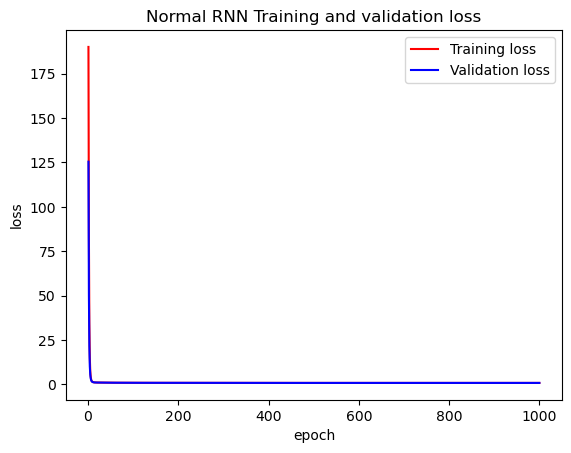

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_20452\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 0s 1ms/step
(3706, 10, 2)


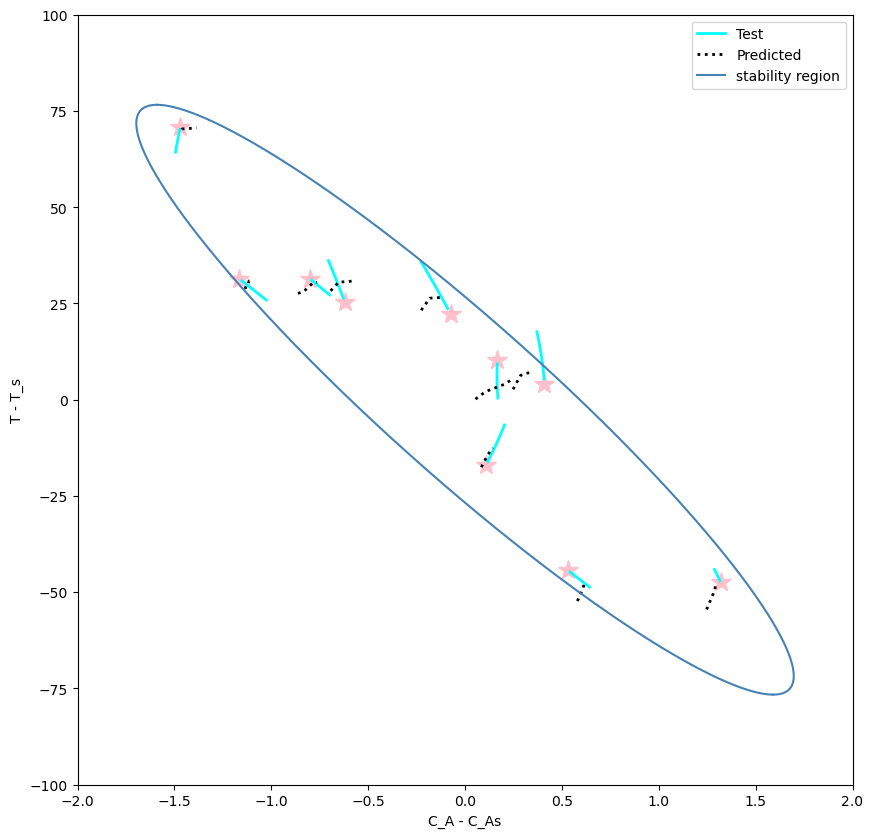

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()